**Table of contents**<a id='toc0_'></a>    
- [Fitting the ZnPc XRR Data](#toc1_)    
  - [Fit 250 eV Data](#toc1_1_)    
    - [Load the 250 eV data](#toc1_1_1_)    
    - [Masking 250 eV](#toc1_1_2_)    
    - [Construct the slab structure for the data](#toc1_1_3_)    
    - [Construct the Objective Function](#toc1_1_4_)    
      - [Constraining the parameters](#toc1_1_4_1_)    
    - [Fitting the data](#toc1_1_5_)    
  - [Fit 283.7 eV Data](#toc1_2_)    
    - [Load the 283.7 eV data](#toc1_2_1_)    
      - [Various Masking Attempts](#toc1_2_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [45]:
from sys import path as syspath
from pathlib import Path

syspath.append(str(Path().home() / "pyref" / "src"))

In [46]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}
</style>

In [47]:
import pyref as rf
from pyref.style import science
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import numpy as np
from pypxr.structure import *
from pypxr.reflectivity import *
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
from refnx._lib.emcee.moves.de import DEMove
from typing import Literal

# <a id='toc1_'></a>[Fitting the ZnPc XRR Data](#toc0_)
**Harlan Heilman**
---
## <a id='toc1_1_'></a>[Fit 250 eV Data](#toc0_)

The steps to fit the ZnPc XRR data are as follows:
1. Load the 250 eV data
    1. Convert the csv file to a pandas dataframe
    2. Plot the data and see if it looks reasonable - If not, mask the data
    3. Convert the data to a ReflectDataSet
2. Construct the slab structure for the data
    1. Vacuum | ZnPc | Amorphous Carbon | SiO2 | Si
3. Construct the Objective Function
    1. Create models for sp polarization
    2. Create objective functions for 250 eV
    3. Add thick - rough constraints to the prior for each layer
4. Fit the data

### <a id='toc1_1_1_'></a>[Load the 250 eV data](#toc0_)

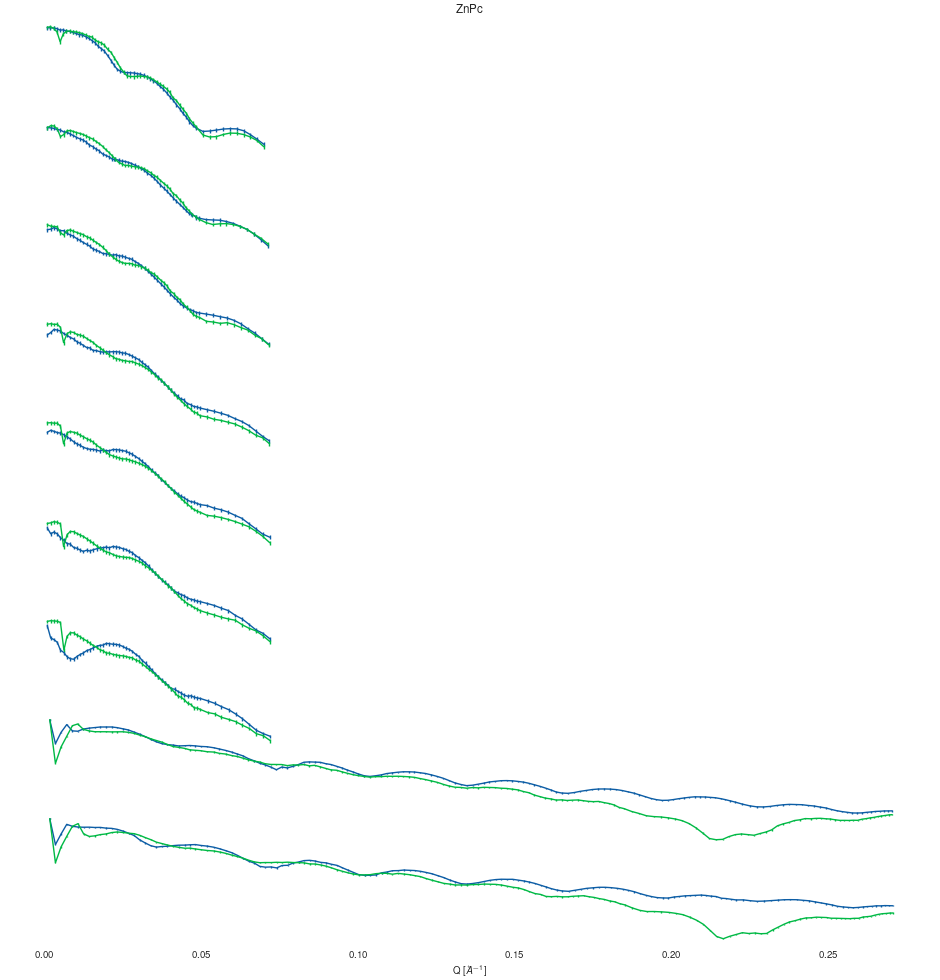

In [48]:
db = rf.db()

znpc_oc = db.get_oc("C32H16N8Zn")
znpc_mono = {
    # "250": {
    #     "s": db.get_refl("zrt_250.0_100.csv", "ZnPc"),
    #     "p": db.get_refl("zrt_250.0_190.csv", "ZnPc"),
    #     },
    "275": {
        "s": db.get_refl("275.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("275.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "280": {
        "s": db.get_refl("280.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("280.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "281": {
        "s": db.get_refl("281.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("281.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "282": {
        "s": db.get_refl("282.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("282.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "282.3": {
        "s": db.get_refl("282.3_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("282.3_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "282.7": {
        "s": db.get_refl("282.7_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("282.7_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "283.1": {
        "s": db.get_refl("283.1_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("283.1_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "283.7": {
        "s": db.get_refl("ZnPc_283.7_100.0 (CCD Scan 82865).parquet", "ZnPc"),
        "p": db.get_refl("ZnPc_283.7_190.0 (CCD Scan 82869).parquet", "ZnPc"),
    },
    "284.1": {
        "s": db.get_refl("ZnPc_284.0_100.0 (CCD Scan 82865).parquet", "ZnPc"),
        "p": db.get_refl("ZnPc_284.0_190.0 (CCD Scan 82869).parquet", "ZnPc"),
        },
}

fig, ax = plt.subplots(nrows = len(znpc_mono.keys()), figsize = (12, 12),sharex=True, gridspec_kw={"hspace":-.25})

for i, (k,v) in enumerate(znpc_mono.items()):
    v["s"].plot(ax = ax[i], x = "Q", y = "Refl", yerr = "Err", label = "s", logy = True, color = "C0", legend = False)
    v["p"].plot(ax = ax[i], x = "Q", y = "Refl", yerr = "Err", label = "p", logy = True, color = "C1", legend = False)

    if i == 0:
        ax[i].set(
            title = "ZnPc",
            ylabel = r"$I_r / I_0$",
        )
    elif i == len(znpc_mono.keys()) - 1:
        ax[i].set(
            xlabel = r"Q [$\AA^{-1}$]",
            ylabel = r"$I_r / I_0$",
        )
    ax[i].set(
        yticks = [],
        ylabel="",
    )
    ax[i].minorticks_off()
    ax[i].grid(False)
    ax[i].tick_params(axis="x", which="both", bottom=False, top=False)
    ax[i].spines["left"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)

In [49]:
def save_optical_constant(energy: float, slab: None | PXR_Slab = None, oc_df: pd.Series | None = None) -> pd.Series:
    if oc_df is None:
        oc_df = pd.Series(index=[
            "xx",
            "zz",
            "dxx",
            "dzz",
            "delta",
            "ddelta",
            "ixx",
            "izz",
            "dixx",
            "dizz",
            "beta",
            "dbeta",
            "energy"])
    if slab is None:
        return oc_df
    else:
        oc_df["xx"] = slab.sld.xx.value
        oc_df["zz"] = slab.sld.zz.value
        oc_df["dxx"] = slab.sld.xx.stderr
        oc_df["dzz"] = slab.sld.zz.stderr
        oc_df["delta"] = slab.sld.delta.value
        oc_df["ddelta"] = slab.sld.delta.stderr
        oc_df["ixx"] = slab.sld.ixx.value
        oc_df["izz"] = slab.sld.izz.value
        oc_df["dixx"] = slab.sld.ixx.stderr
        oc_df["dizz"] = slab.sld.izz.stderr
        oc_df["beta"] = slab.sld.beta.value
        oc_df["dbeta"] = slab.sld.beta.stderr
        oc_df["energy"] = energy
        return oc_df

### <a id='toc1_1_3_'></a>[Construct the slab structure for the data](#toc0_)

I have allready fit this structure several times. So I will just load the structure from a .json file. 

In [50]:
# Collect structure parameters
znpc_mono_struct_file = db.get_struct("ZnPc_RoomTemp")
znpc_oc = db.get_oc("C32H16N8Zn")

si_thick = znpc_mono_struct_file["Si"]["thickness"]
si_rough = znpc_mono_struct_file["Si"]["roughness"]
si_density = znpc_mono_struct_file["Si"]["density"]

sio2_thick = znpc_mono_struct_file["SiO2"]["thickness"]
sio2_rough = znpc_mono_struct_file["SiO2"]["roughness"]
sio2_density = znpc_mono_struct_file["SiO2"]["density"]

c_amor_thick = znpc_mono_struct_file["C"]["thickness"]
c_amor_rough = znpc_mono_struct_file["C"]["roughness"]
c_amor_density = znpc_mono_struct_file["C"]["density"]

znpc_thick = znpc_mono_struct_file["C32H16N8Zn"]["thickness"]
znpc_rough = znpc_mono_struct_file["C32H16N8Zn"]["roughness"]
znpc_density = znpc_mono_struct_file["C32H16N8Zn"]["density"]

In [51]:
znpc_density, znpc_thick

(1.37429051377332, 196.441)

## <a id='toc1_2_'></a>[Fit 275](#toc0_)

C:\Users\hduva\AppData\Local\Temp\ipykernel_4128\1495172484.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s_pol = s[(s["Q"] != 0.0757)][s["Q"] != 0.0740]
C:\Users\hduva\AppData\Local\Temp\ipykernel_4128\1495172484.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_pol = p[(p["Q"] != 0.0757)][p["Q"] != 0.0740]


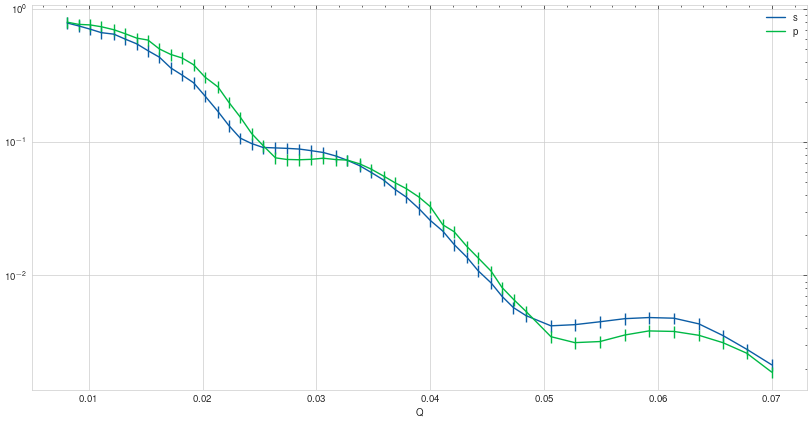

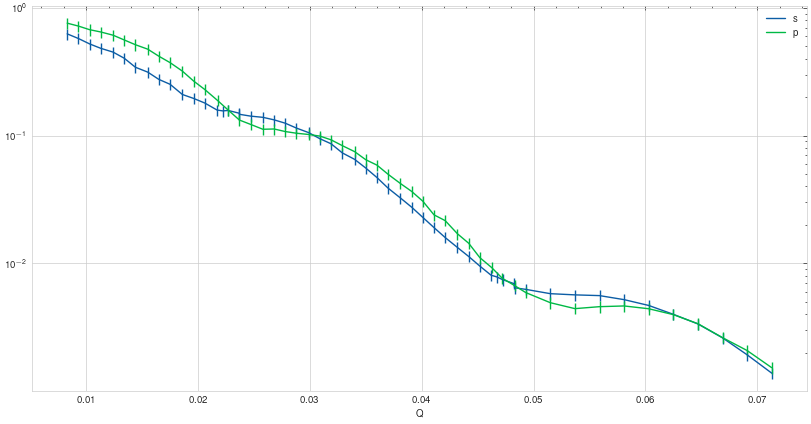

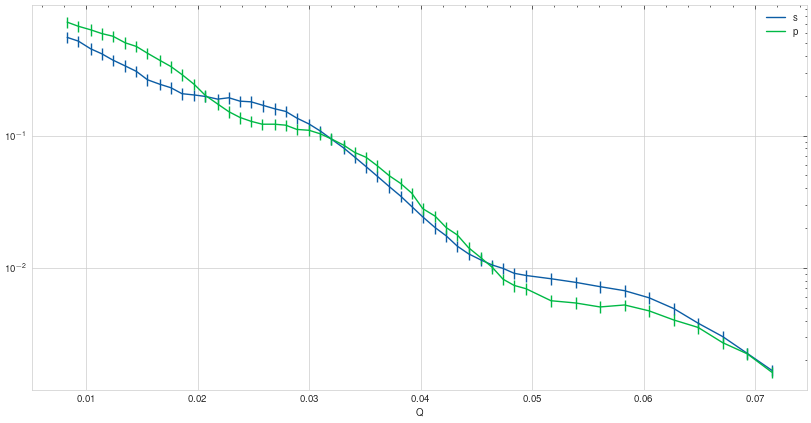

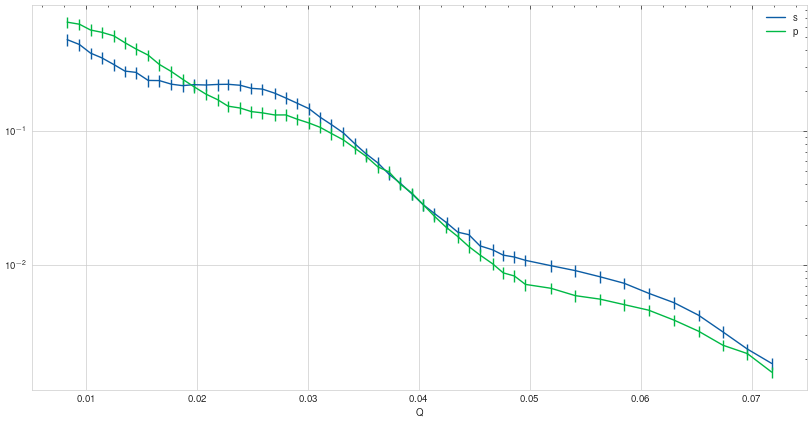

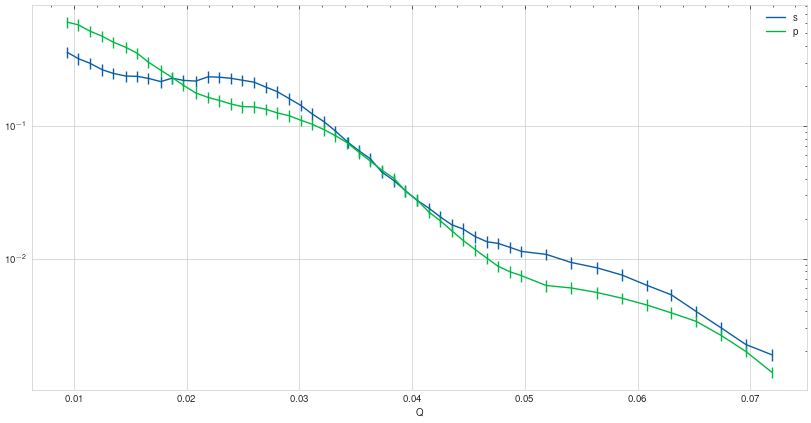

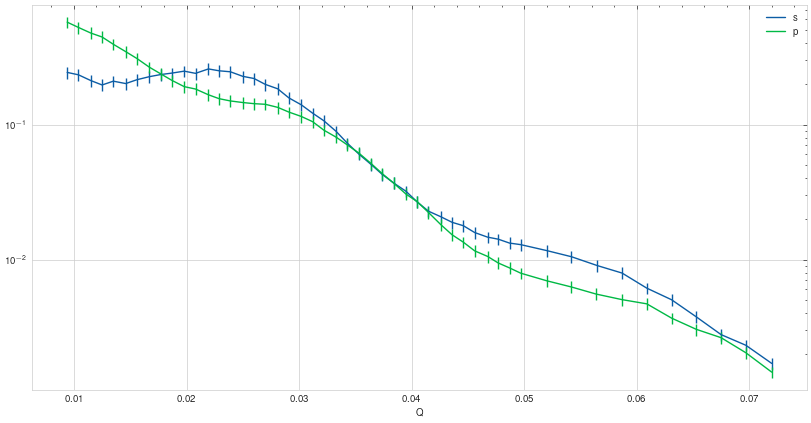

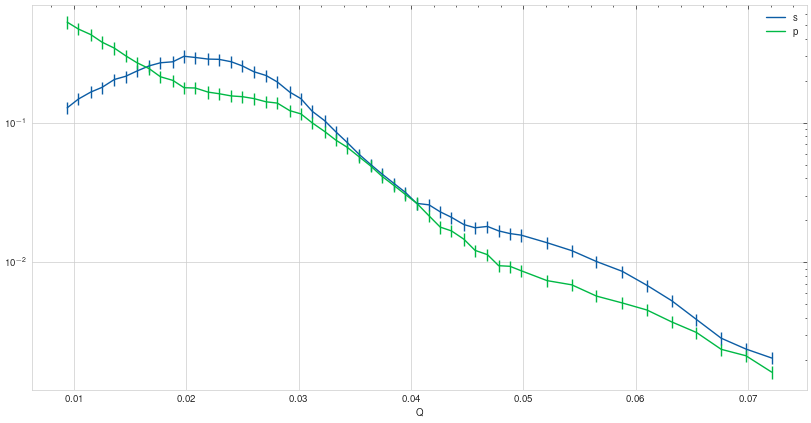

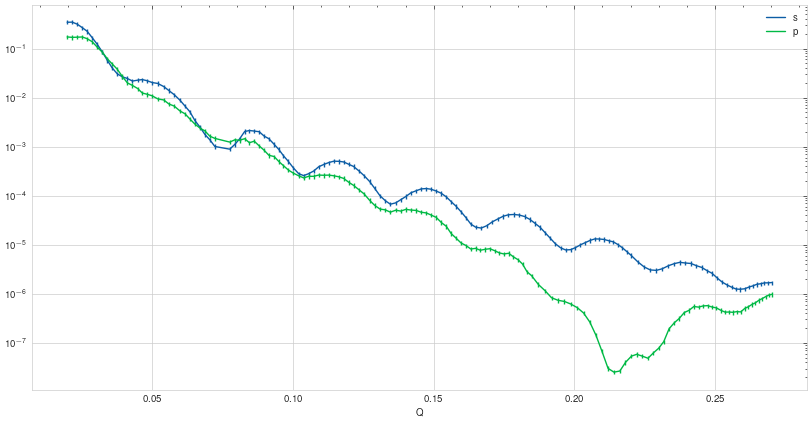

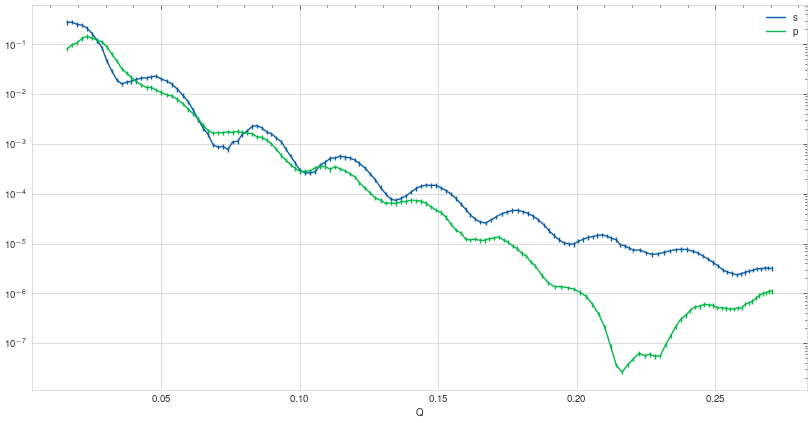

In [52]:
data = []
en:list[float] = [float(k) for k in znpc_mono.keys() if k != "250"]

def mask(s, p):
    s_pol = s[(s["Q"] != 0.0757)][s["Q"] != 0.0740]
    p_pol = p[(p["Q"] != 0.0757)][p["Q"] != 0.0740]
    return s_pol.iloc[10:], p_pol.iloc[10:]

for i, e in enumerate(znpc_mono.keys()):
    if e == "250":
        pass
    cutoff = 7 if i <= 3 else 8
    s = znpc_mono[f"{e}"]["s"].iloc[cutoff:]
    p = znpc_mono[f"{e}"]["p"].iloc[cutoff:]
    if e == "283.7":
        s, p = mask(znpc_mono[f"{e}"]["s"], znpc_mono[f"{e}"]["p"])


    fig, ax = plt.subplots()
    s.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err", logy = True, label = "s")
    p.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err", logy = True, label = "p")
    data.append(rf.to_refnx_dataset(s, pol="sp", second_pol=p))


In [53]:
from numpy import array, ndarray
from typing import Literal

type _bound = tuple[float, float]
type complex_bound = dict[Literal["r", "i"], _bound]
type bound = dict[Literal["xx", "zz"], complex_bound]



def n_limits(ens, density) -> tuple[list[bound], list[ndarray]]:
    bounds: list[complex_bound] = []
    ns = znpc_oc(ens,density=density)
    if not isinstance(ns, list):
        ns = [ns]
    for e in ens:
        xx_r = (znpc_oc.zz(e), znpc_oc.xx(e))
        xx_i = (znpc_oc.ixx(e), znpc_oc.izz(e))

        zz_r = xx_r
        zz_i = xx_i

        xx_bound: complex_bound = {"r": xx_r, "i": xx_i}
        zz_bound: complex_bound = {"r": zz_r, "i": zz_i}
        bounds.append({"xx": xx_bound, "zz": zz_bound})

    return bounds, ns


bounds, ns = n_limits(en, znpc_density)

In [54]:
bounds

[{'xx': {'r': (array(0.00082565), array(0.00116598)),
   'i': (array(0.00020137), array(0.00020137))},
  'zz': {'r': (array(0.00082565), array(0.00116598)),
   'i': (array(0.00020137), array(0.00020137))}},
 {'xx': {'r': (array(5.75211528e-05), array(0.00087331)),
   'i': (array(0.00019679), array(0.00019679))},
  'zz': {'r': (array(5.75211528e-05), array(0.00087331)),
   'i': (array(0.00019679), array(0.00019679))}},
 {'xx': {'r': (array(-0.00027381), array(0.00078964)),
   'i': (array(0.00019857), array(0.0001966))},
  'zz': {'r': (array(-0.00027381), array(0.00078964)),
   'i': (array(0.00019857), array(0.0001966))}},
 {'xx': {'r': (array(-0.00080107), array(0.000694)),
   'i': (array(0.00020139), array(0.00019684))},
  'zz': {'r': (array(-0.00080107), array(0.000694)),
   'i': (array(0.00020139), array(0.00019684))}},
 {'xx': {'r': (array(-0.001035), array(0.0006624)),
   'i': (array(0.00020248), array(0.00019751))},
  'zz': {'r': (array(-0.001035), array(0.0006624)),
   'i': (arra

________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:   '_thick'    , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:     'rho'     , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:   '_rough'    , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:   'ZnPc_surf'  
<Parameter:'ZnPc_surf_thick', value=10  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_surf_diso', value=0.000939089  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_surf_biso', value=0.000201374  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_surf_enOffset', value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_surf_xx' , value=0.000825646  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_surf_ixx', value=0.000201374  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_sur

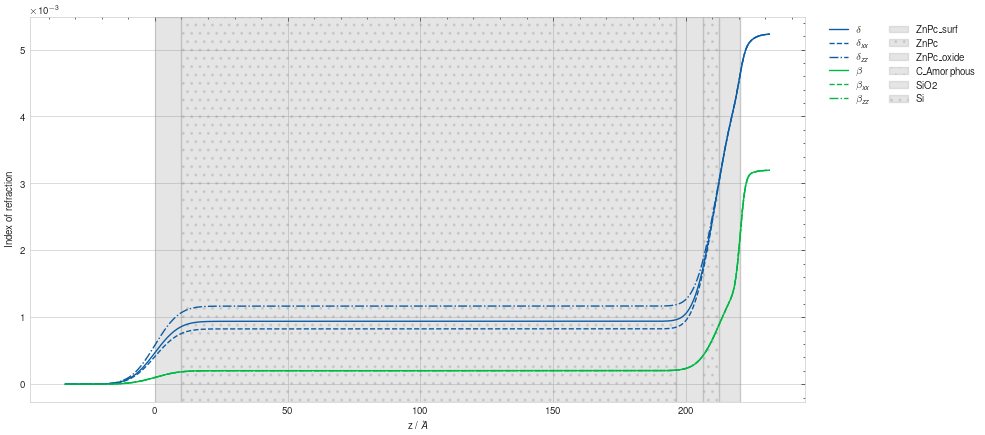

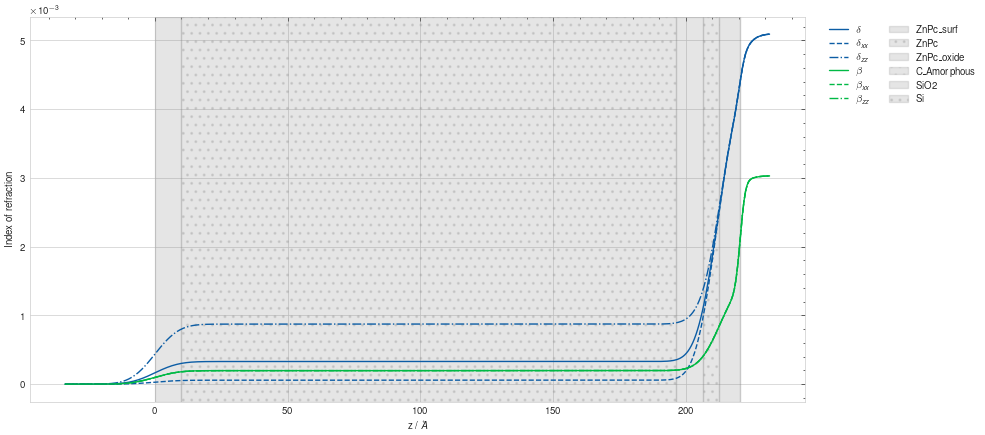

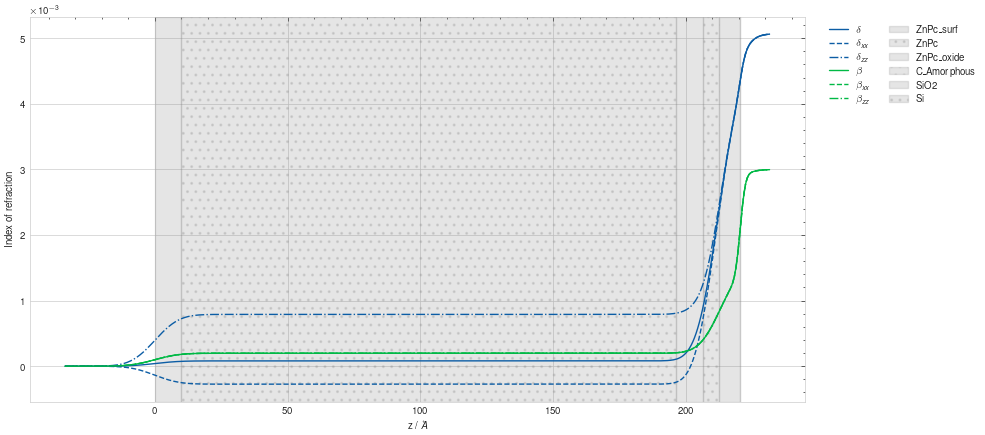

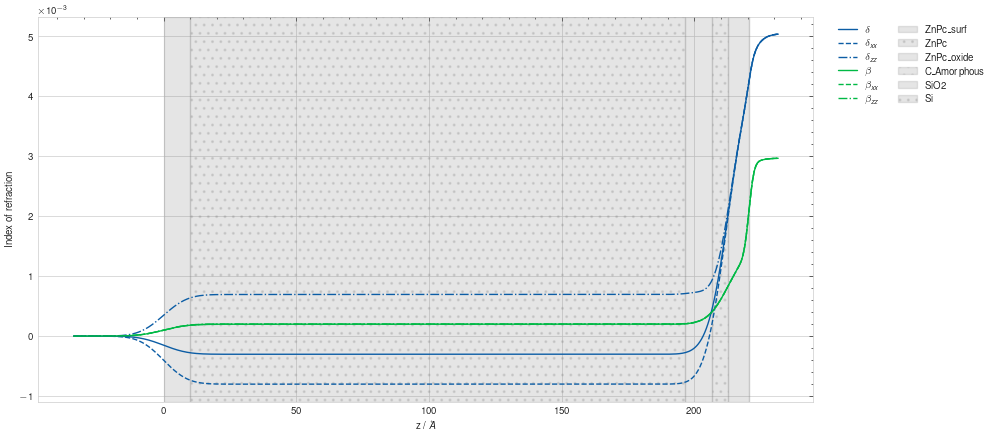

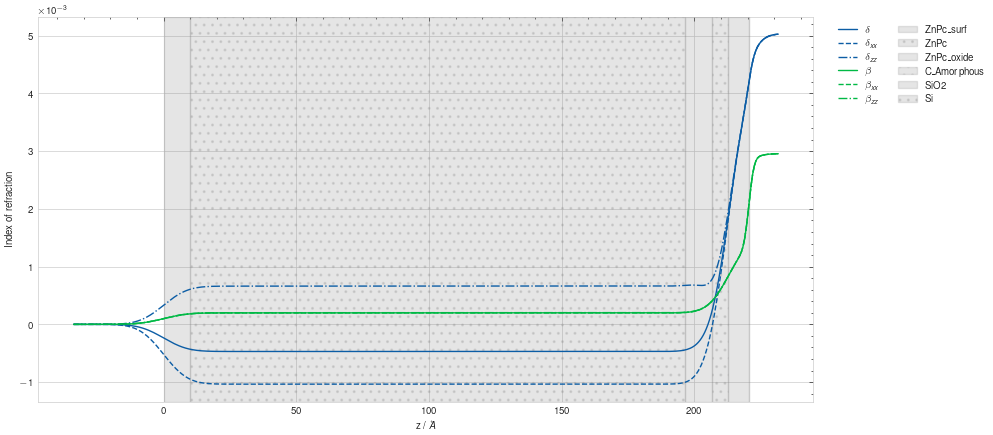

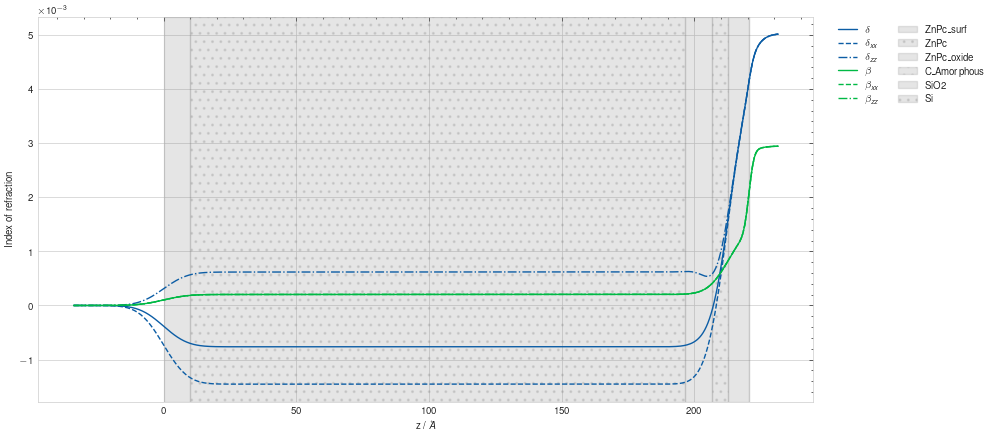

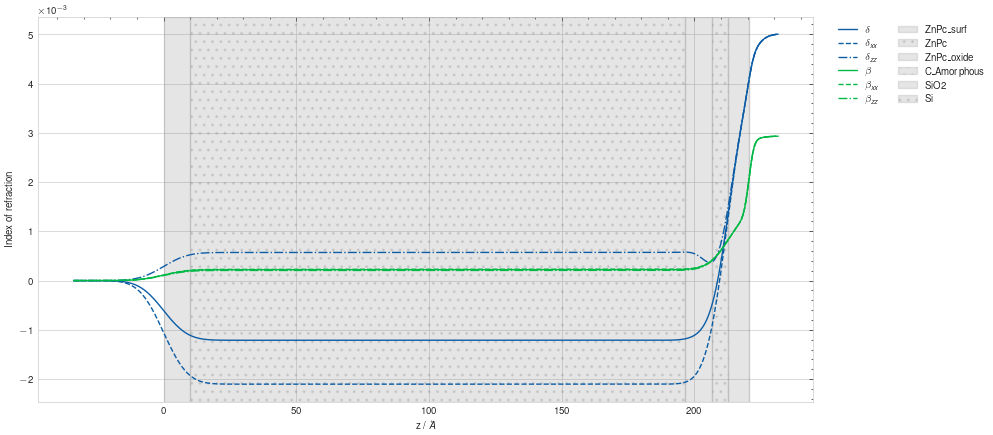

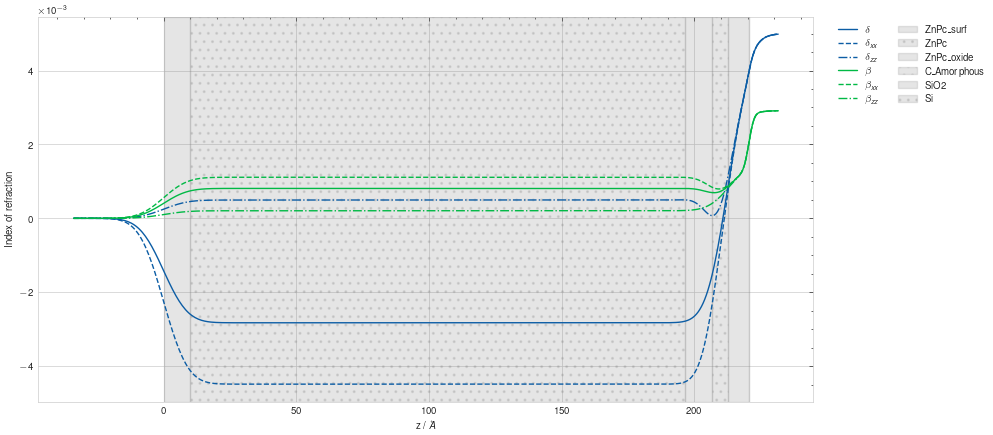

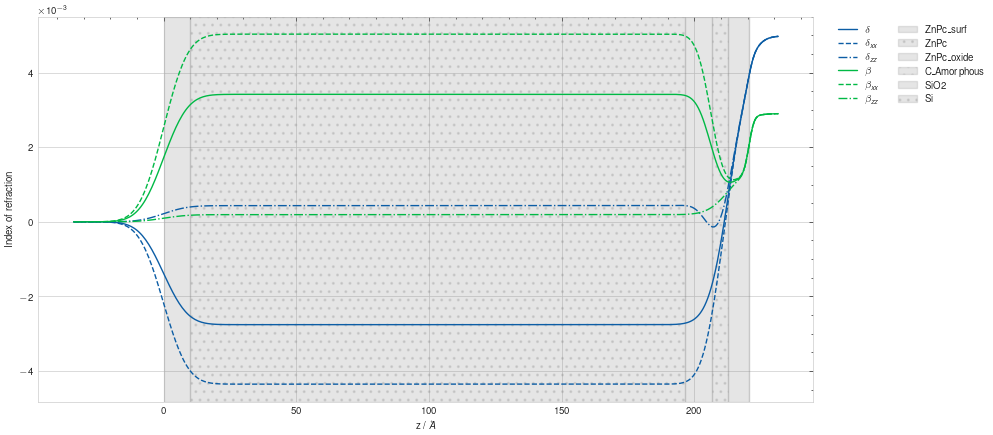

In [63]:
vac = [PXR_MaterialSLD("", 0, e)(0, 0) for e in en]
si = [PXR_MaterialSLD("Si", 2.33, e, name="Si")(si_thick, si_rough) for e in en]
sio2 = [
    PXR_MaterialSLD("SiO2", sio2_density, e, name="SiO2")(sio2_thick, sio2_rough)
    for e in en
]
c_amor = [
    PXR_MaterialSLD("C", c_amor_density, e, name="C_Amorphous")(
        c_amor_thick, c_amor_rough
    )
    for e in en
]

znpc_surf_thick = 10

znpc = [
    PXR_SLD(n[::-1], symmetry="uni", name="ZnPc")(
        znpc_thick - znpc_surf_thick, znpc_rough / 2
    )
    for n in ns
]

znpc_surf = [
    PXR_SLD(n[::-1], symmetry="uni", name="ZnPc_surf")(znpc_surf_thick, znpc_rough)
    for n in ns
]

znpc_pattern = [
    PXR_SLD(n[::-1], symmetry="uni", name="ZnPc_oxide")(znpc_surf_thick, znpc_rough)
    for n in ns
]

structs = [
    vac[i] | znpc_surf[i] | znpc[i] | znpc_pattern[i] |c_amor[i] | sio2[i] | si[i]
    for i in range(len(en))
]

for struc in structs:
    struc.plot()
    print(struc.parameters)

In [56]:
# ------------------------------------------------
# Constrain Model
# ------------------------------------------------

# Independent of polarization


for slab in si:
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)

for slab in sio2:
    slab.thick.setp(vary=None, constraint=sio2_thick)
    slab.rough.setp(vary=None, constraint=sio2_rough)
    slab.sld.density.setp(vary=False, bounds=slab.sld.density.value * array([0.8, 1.2]))


for slab in c_amor:
    slab.thick.setp(vary=True, bounds=(0, znpc_surf_thick))
    slab.rough.setp(vary=True, bounds=(0, znpc_rough))
    slab.sld.dense.setp(vary=False, bounds=slab.sld.density.value * array([0.8, 1.2]))


def sld_constraint(
    slab: PXR_Slab,
    bounds: bound | None = None,
    xx_bounds: _bound = (-0.005, 0.005),
    zz_bounds: _bound = (-0.005, 0.005),
    thick_bounds: _bound = None,
):
    if bounds is None:
        bounds = {"xx": {"r": xx_bounds, "i": xx_bounds}, "zz": {"r": zz_bounds, "i": zz_bounds}}
    slab.sld.xx.setp(vary=True, bounds=bounds["xx"]["r"])
    slab.sld.zz.setp(vary=True, bounds=bounds["zz"]["r"])
    slab.sld.ixx.setp(vary=True, bounds=bounds["xx"]["i"])
    slab.sld.izz.setp(vary=True, bounds=bounds["zz"]["i"])
    if thick_bounds is not None:
        slab.thick.setp(vary=True, bounds=thick_bounds)
    else:
        slab.thick.setp(vary=True, bounds=(0, znpc_thick))
    slab.rough.setp(vary=True, bounds=(0, znpc_rough))

In [57]:
_ = [sld_constraint(slab, bounds=bound) for (slab, bound) in zip(znpc, bounds)]
_ = [sld_constraint(slab, bounds=bound) for (slab, bound) in zip(znpc_surf, bounds)]
_ = [sld_constraint(slab, bounds=bound) for (slab, bound) in zip(c_amor, bounds)]

for i, slab in enumerate(znpc):
    slab.thick.setp(vary=None, constraint = znpc_thick - znpc_surf[i].thick.value)

def multi_en_constrant(slabs: list[PXR_Slab], bulk=True):
    for i, slab in enumerate(slabs):
        if i == 0 and bulk:
            slab.thick.setp(vary=None, constraint = znpc_thick - znpc_surf[0].thick.value)
        elif i > 0:
            slab.thick.setp(vary=None, constraint = slabs[0].thick.value)
            slab.rough.setp(vary=None, constraint = slabs[0].rough.value)

# multi_en_constrant(znpc_surf, bulk=False)
# multi_en_constrant(znpc_sub, bulk=False)
# multi_en_constrant(znpc, bulk=True)

for struc in structs:
    print(struc.parameters)

________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:   '_thick'    , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:     'rho'     , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:   '_rough'    , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:   'ZnPc_surf'  
<Parameter:'ZnPc_surf_thick', value=10          , bounds=[0.0, 49.11025]>
<Parameter:'ZnPc_surf_diso', value=0.000939089  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_surf_biso', value=0.000201374  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_surf_enOffset', value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_surf_xx' , value=0.000825646          , bounds=[0.0008256455504529046, 0.0011659769919970054]>
<Parameter:'ZnPc_surf_ixx', value=0.000201374          , b

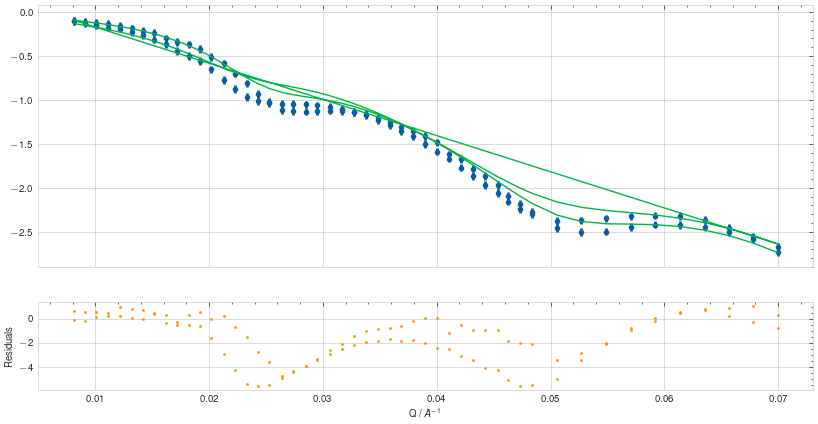

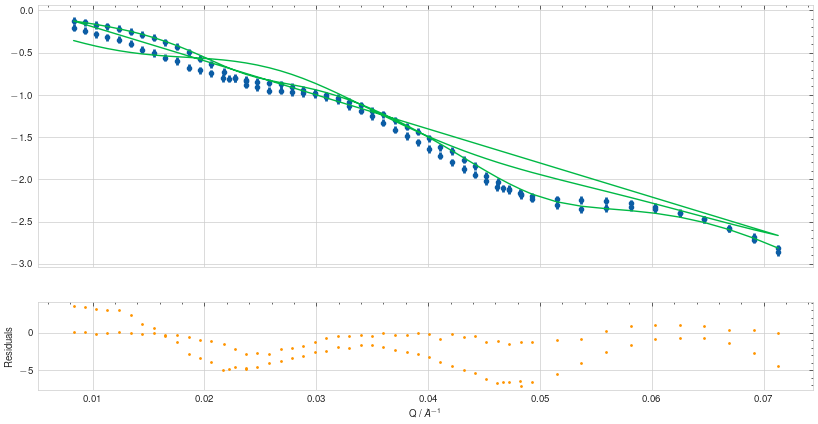

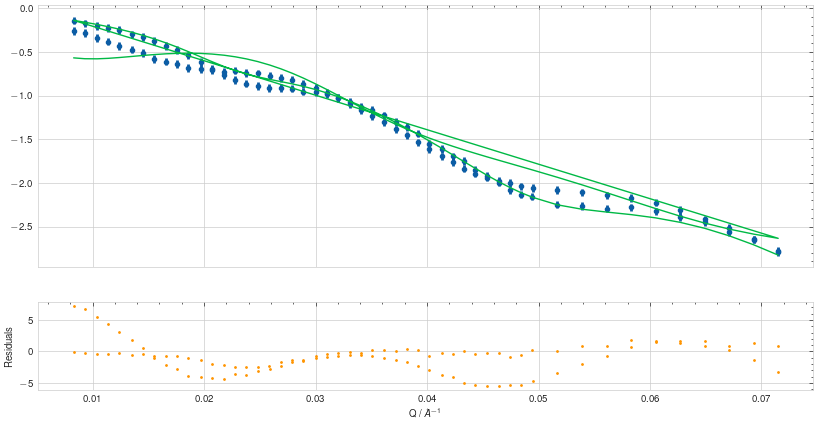

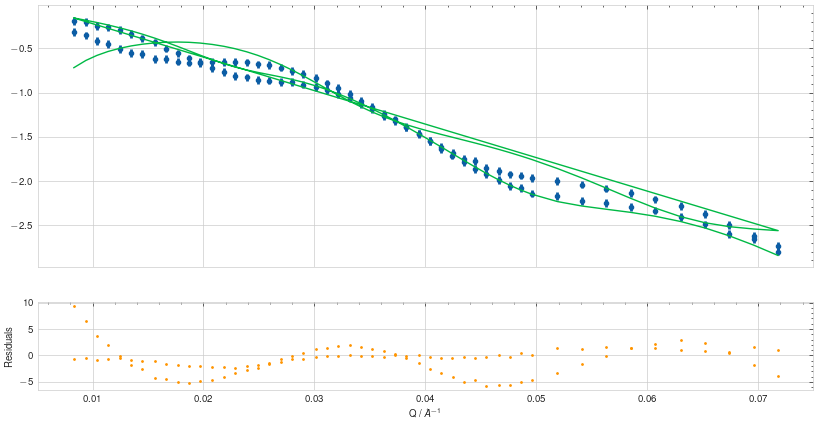

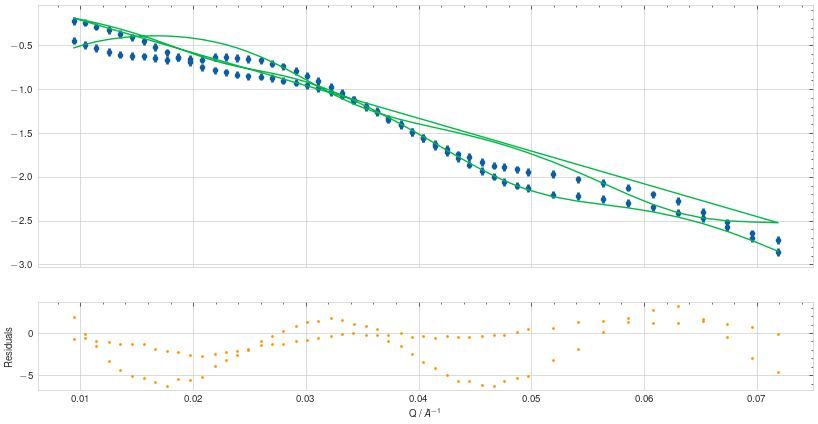

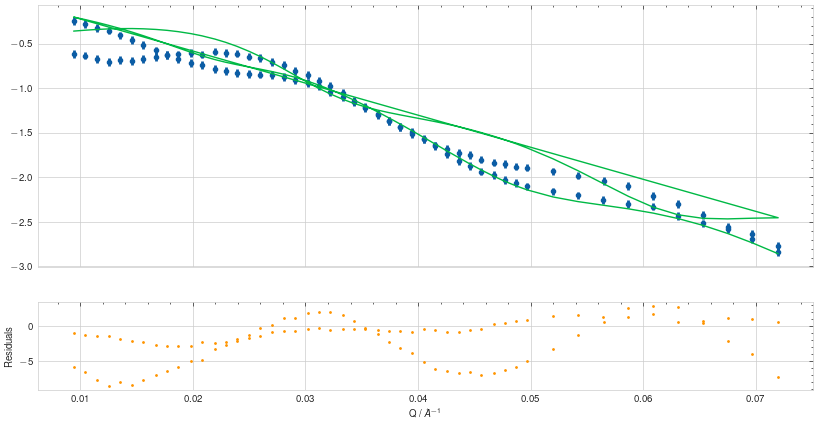

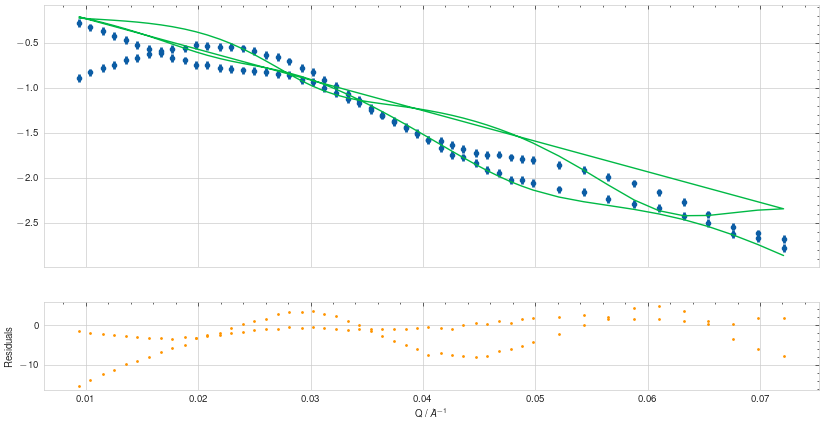

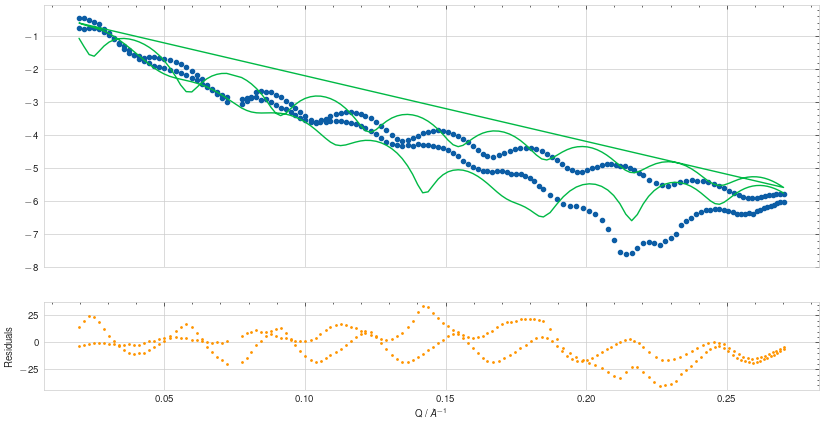

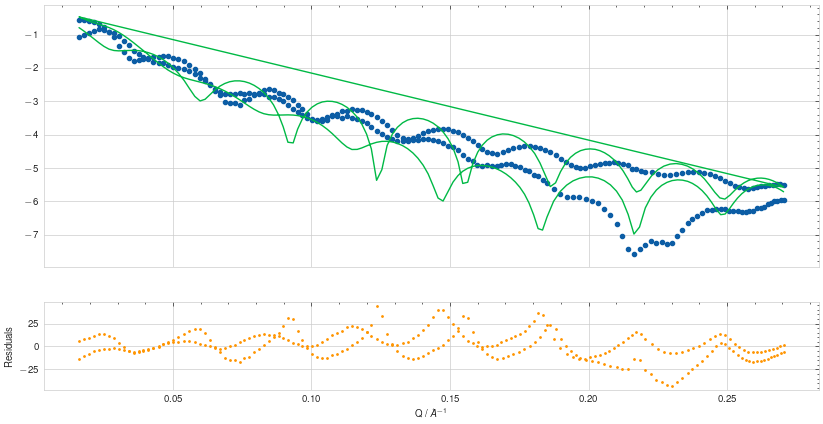

In [58]:
from pyref.fitting.logp import LogpExtra_rough as LogpExtra


objs = []
for i, e in enumerate(en):
    model = PXR_ReflectModel(structs[i], pol = "sp", energy = e, name = f"ZnPc Mono Layer {e}eV")
    model.scale_s.setp(vary = True, bounds = (0.6, 1.2))
    model.scale_p.setp(vary = True, bounds = (0.6, 1.2))
    model.theta_offset_s.setp(vary = True, bounds = (-1, 1))
    model.theta_offset_p.setp(vary = True, bounds = (-1, 1))

    obj_p = Objective(model, data[i], transform=Transform("logY"))
    lpe = LogpExtra(obj_p)
    obj_p.logp_extra = lpe
    obj_p.plot(resid=True)
    objs.append(obj_p)

In [59]:
import pickle as pkl

class Fitter:
    # Suppresses the warning
    from warnings import simplefilter

    simplefilter("ignore")

    def __init__(self, obj: Objective | GlobalObjective, en, walkers_per_param=10, burn_in = 0):
        self.obj = obj
        self.move = [
            (DEMove(sigma=1e-7), 0.90),
            (DEMove(sigma=1e-7, gamma0=1), 0.1),
        ]
        self.n_params = len(self.obj.data.data[0]) - len(self.obj.varying_parameters())
        self._n_walkers = walkers_per_param*len(self.obj.varying_parameters())
        self.burn_in = burn_in
        self.fitter = CurveFitter(obj, nwalkers=self._n_walkers, moves=self.move)
        self.en = en

    @property
    def n_walkers(self):
        return self._n_walkers

    @n_walkers.setter
    def n_walkers(self, value):
        self._n_walkers = value
        self.fitter = CurveFitter(self.obj, nwalkers=self._n_walkers, moves=self.move)

    def red_chisqr(self):
        return self.obj.chisqr() / self.n_params

    def fit(
        self,
        steps_per_param=1000,
        thin=1,
        seed=1,
        init: Literal["jitter", "prior"] = "jitter",
        show_output=False,
    ):
        steps = steps_per_param * self.n_params
        burn = int(steps * self.burn_in)
        print(f"Reduced χ2 = {self.red_chisqr()}")
        self.fitter.initialise(init, random_state=seed)
        self.chain = self.fitter.sample(
            steps,
            random_state=seed,
            nthin=thin,
            skip_initial_state_check=True,
            nburn=burn,
        )

        if show_output:
            self.show_output()
            self.export(f"{self.en}.pkl")

    def show_output(self):
        print(rf"Reduced χ2 = {self.red_chisqr()}")
        print(self.obj.varying_parameters())
        fig, ax = plt.subplots()
        lp = self.fitter.logpost
        ax.plot(-lp)
        fig.show()
        self.obj.plot(resid=True)
        plt.show()
        self.obj.model.structure.plot()
        self.export(f"{self.en}.pkl")

    def export(self, filename: str):
        with open(filename, "wb") as f:
            pkl.dump(self, f)

    def delete_obj(self):
        del self


class MultiEnFitter:
    def __init__(self, objs: list[Objective], en_list: list[float]):
        self.objs = objs
        self.ens = en_list

    def fit_obj(self,n: int, N: int = 1, fitter = None, reset = False):
        if fitter is None:
            fitter = Fitter(obj = self.objs[n], en = self.ens[n])
            fitter.fit(init="jitter", steps_per_param=20*N)

        if reset:
            fitter.fitter.reset()

        fitter.fit(init="jitter", steps_per_param=5*N)
        if fitter.red_chisqr() > 1 and N < 4:
            print(f"Red χ2 = {fitter.red_chisqr()}. Refitting with {N+1}x walkers")
            N+=2
            self.fit_obj(n, N, fitter, reset)
        else:
            fitter.show_output()
            fitter.export(f"{self.objs[n].model.name}.pkl")

    def fit(self, N: int = 1):
        for i in range(len(self.objs)):
            self.fit_obj(i, N)

Reduced χ2 = 215.54194563533503


100%|██████████| 2660/2660 [06:45<00:00,  6.55it/s]


Reduced χ2 = 227.63362436202192
________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=0.942018 +/- 0.189, bounds=[0.6, 1.2]>
<Parameter:   'scale_p'   , value=0.921464 +/- 0.181, bounds=[0.6, 1.2]>
<Parameter:'theta_offset_s', value=-0.141755 +/- 0.664, bounds=[-1.0, 1.0]>
<Parameter:'theta_offset_p', value=-0.199446 +/- 0.632, bounds=[-1.0, 1.0]>
<Parameter:'ZnPc_surf_thick', value=24.6288  +/- 13  , bounds=[0.0, 49.11025]>
<Parameter:'ZnPc_surf_xx' , value=-0.00156999 +/- 0.00134, bounds=[-0.004353865298063786, 0.00043369814471855256]>
<Parameter:'ZnPc_surf_ixx', value=0.00207106 +/- 0.0019, bounds=[0.00019208099663407647, 0.005032698973160992]>
<Parameter:'ZnPc_surf_zz' , value=-0.0018257 +/- 0.00173, bounds=[-0.004353865298063786, 0.00043369814471855256]>
<Parameter:'ZnPc_surf_izz', value=0.00329236 +/- 0.00192, bounds=[0.00019208099663407647, 0.005032698973160992]>
<Parameter:'ZnPc_surf_rough'

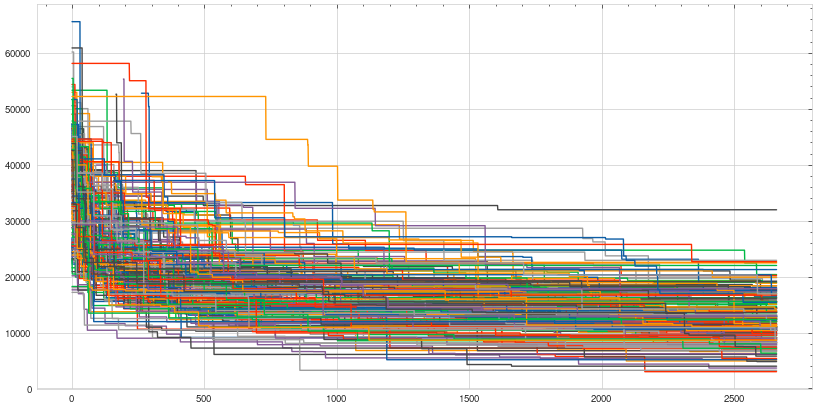

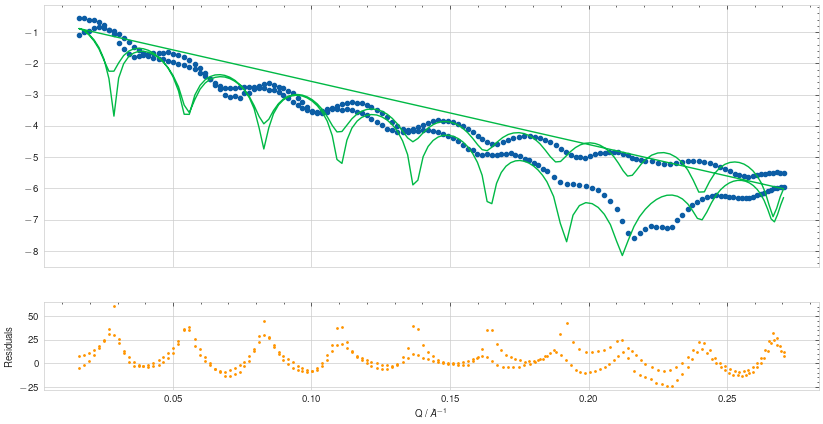

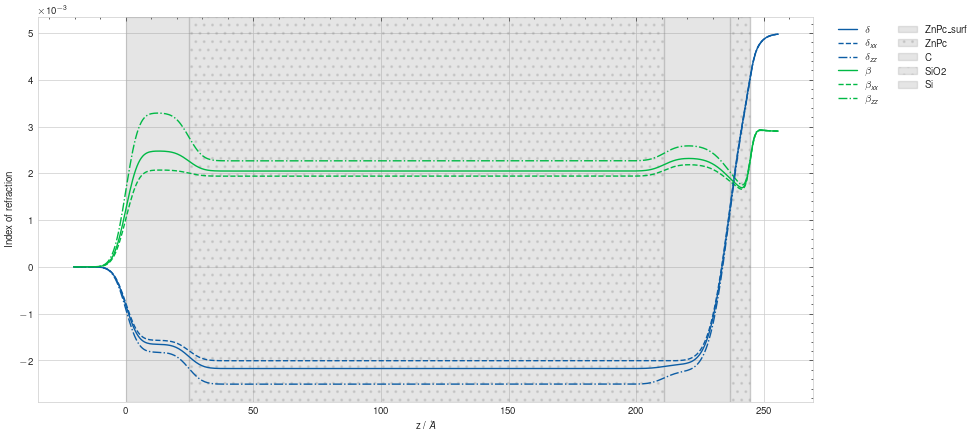

In [60]:
fitter_singel = Fitter(objs[8], en[8])
fitter_singel.fit(init="prior", steps_per_param=10)
fitter_singel.show_output()

In [62]:
fitter_singel.fit(init="jitter", steps_per_param=100)
fitter_singel.show_output()

Reduced χ2 = 19.21829203880368


  3%|▎         | 859/26600 [07:45<3:52:41,  1.84it/s]


KeyboardInterrupt: 

In [18]:
fitter = MultiEnFitter(objs, en)
fitter.fit()

Reduced χ2 = 7.926817921912844


100%|██████████| 1660/1660 [04:35<00:00,  6.02it/s]


Reduced χ2 = 2.370757051372503


 36%|███▌      | 150/415 [00:33<00:59,  4.44it/s]


KeyboardInterrupt: 

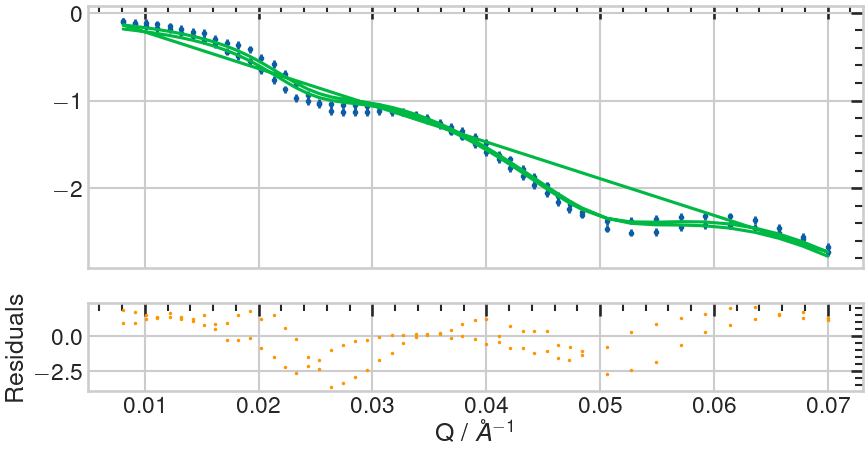

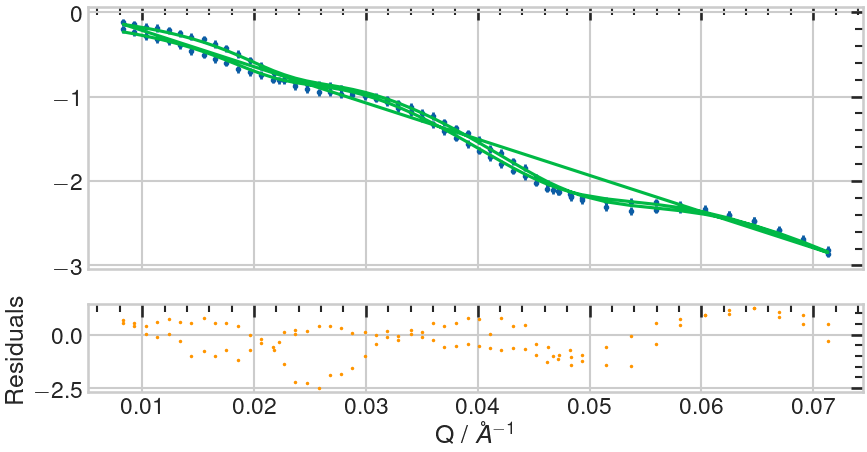

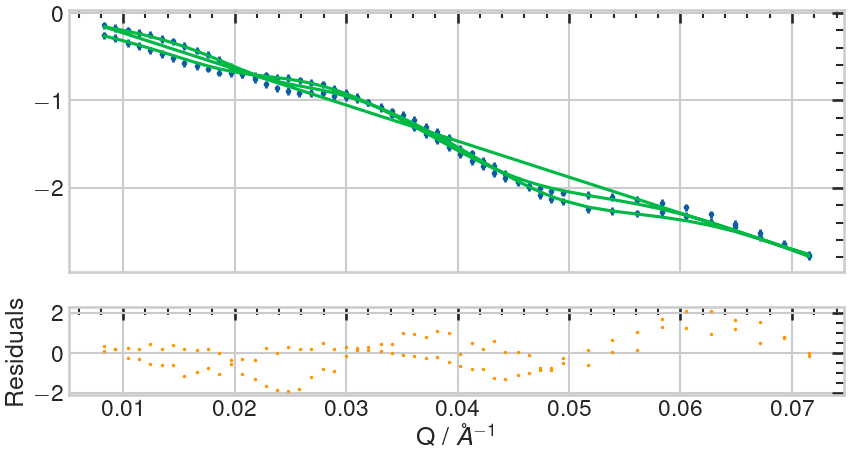

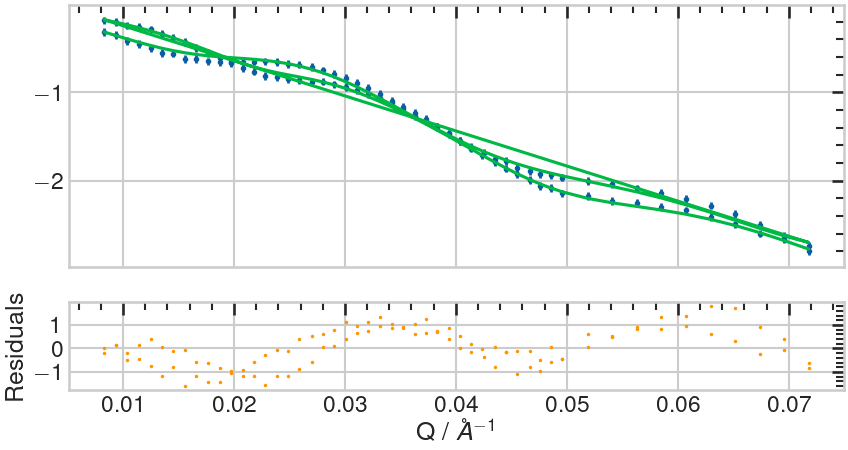

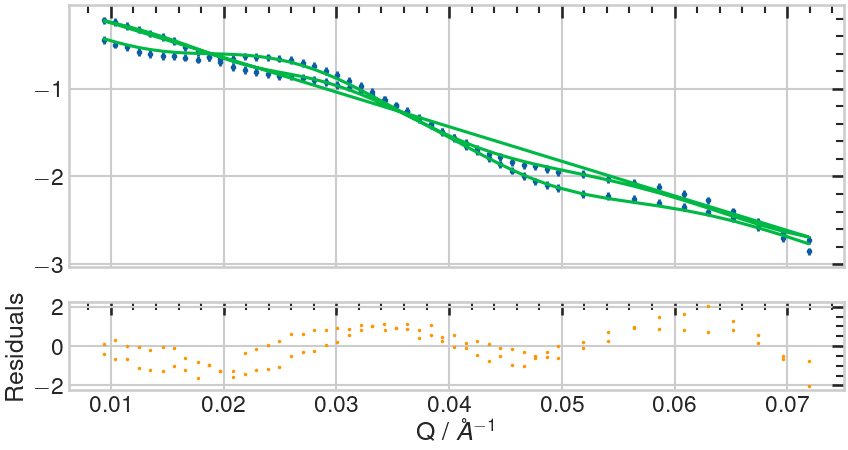

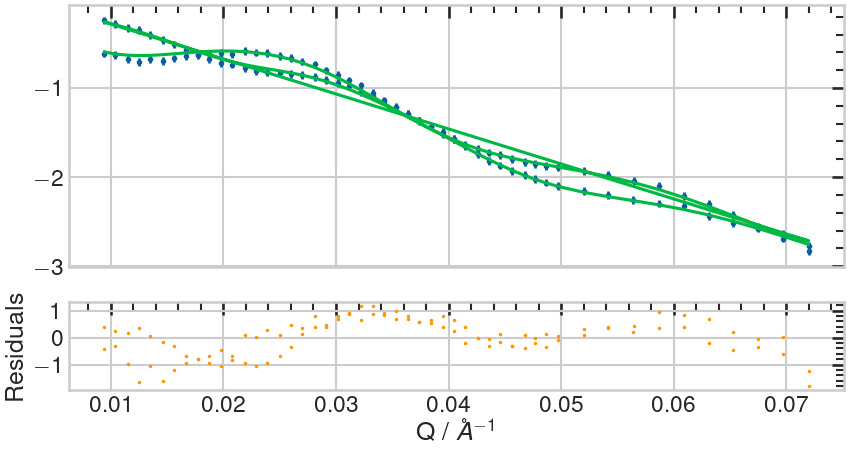

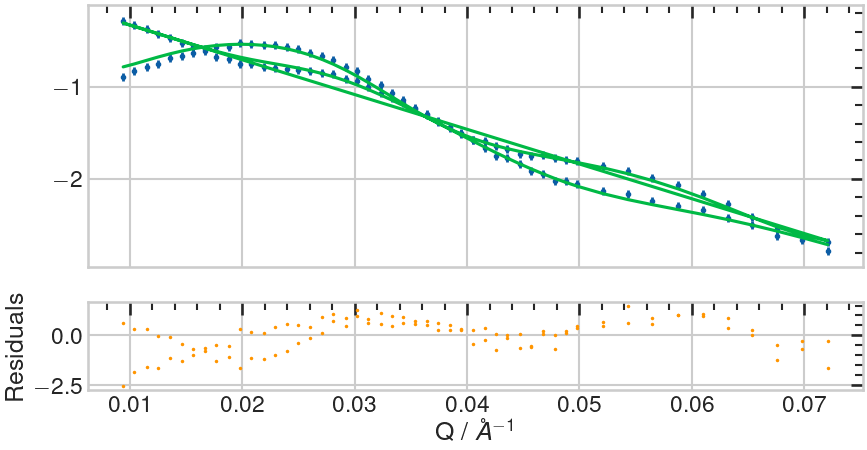

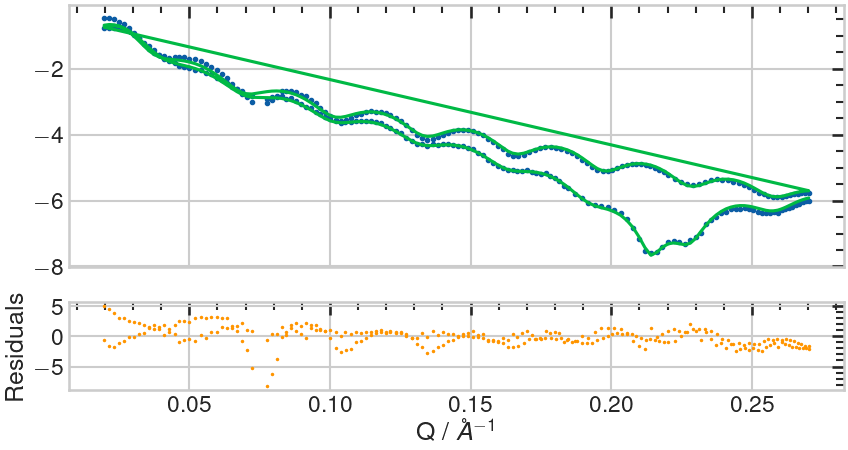

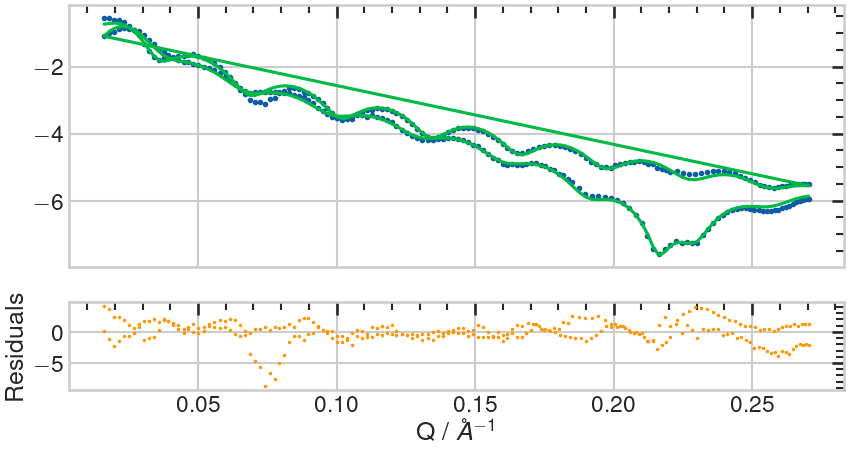

In [90]:
for obj in objs:
    obj.plot(resid=True)

AttributeError: 'PXR_ReflectModel' object has no attribute '_scale_s'

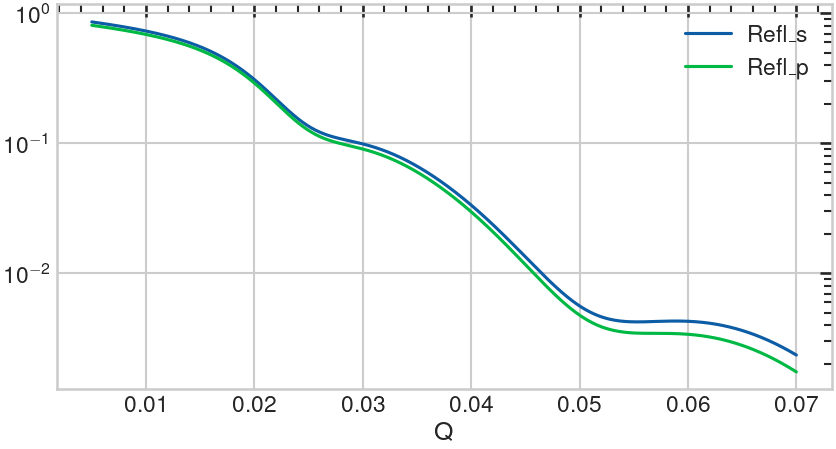

In [64]:
ocs = []
for e in en:
    pickle_path = f"{e}.pkl"
    try:
        with open(pickle_path, "rb") as f:
            fitter: Fitter = pkl.load(f)
            structure = fitter.obj.model.structure
            scale_s = fitter.obj.model.scale_s.value
            scale_p = fitter.obj.model.scale_p.value
            bkg = fitter.obj.model.bkg.value
            theta_offset_s = fitter.obj.model.theta_offset_s.value
            theta_offset_p = fitter.obj.model.theta_offset_p.value

            q_max = fitter.obj.data.data[0][-1]
            q = np.linspace(0.005, q_max, 1000)
            model_spol = PXR_ReflectModel(structure, pol="s", energy=e, theta_offset={"s": theta_offset_s}, bkg = bkg, scale = {"s": scale_s})
            model_ppol = PXR_ReflectModel(structure, pol="p", energy=e, theta_offset={"p": theta_offset_p}, bkg = bkg, scale = {"p": scale_p})

            model_results = pd.DataFrame(
                {
                    "Q": q,
                    "Refl_s": model_spol(q),
                    "Refl_p": model_ppol(q),
                }
            )
            model_results.plot(x = "Q", y = ["Refl_s", "Refl_p"], logy = True)
            model_results.to_csv(f"{e}_model.csv", index=False)

            znpc_slab = structure[2]
            oc_series = save_optical_constant(e, znpc_slab)
            ocs.append(oc_series)
    except FileNotFoundError:
        continue
oc_df = pd.DataFrame(ocs)
oc_df

In [ ]:
# oc_df.to_csv(db.res / "ZnPc_OC.csv", index=False)

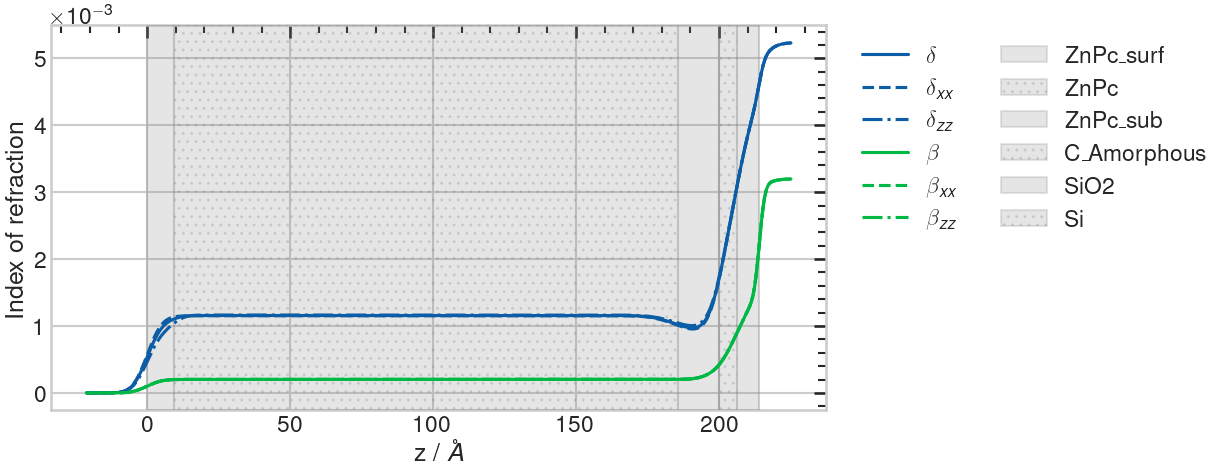

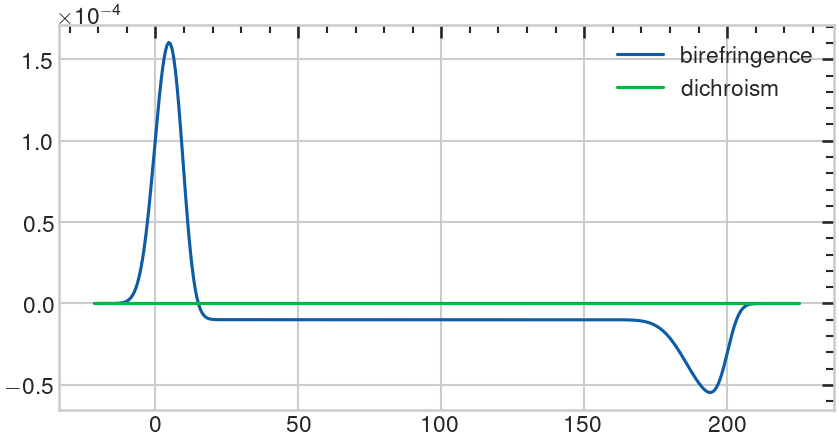

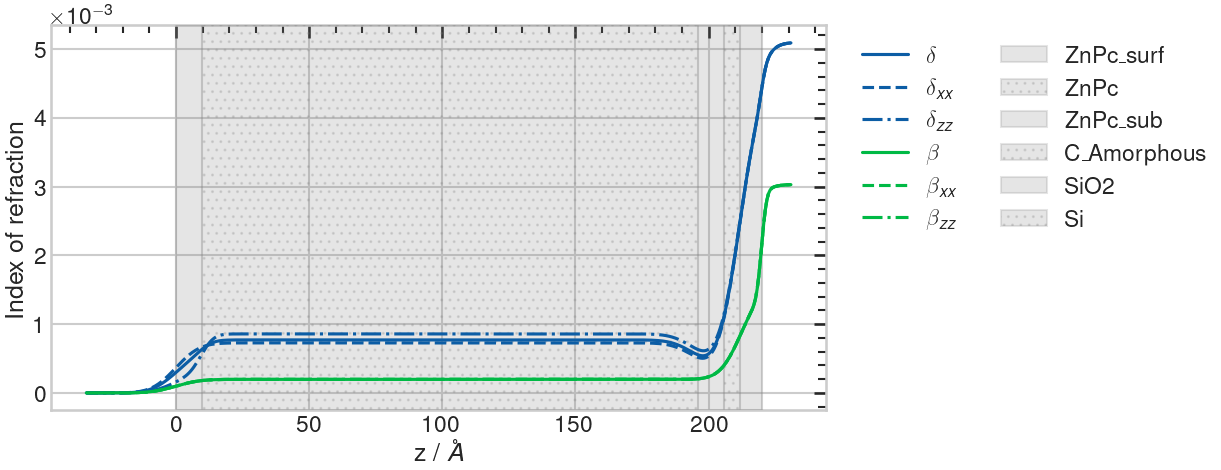

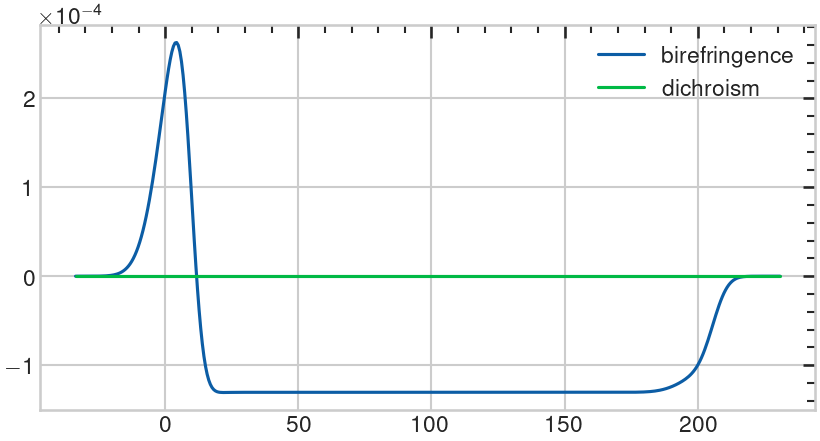

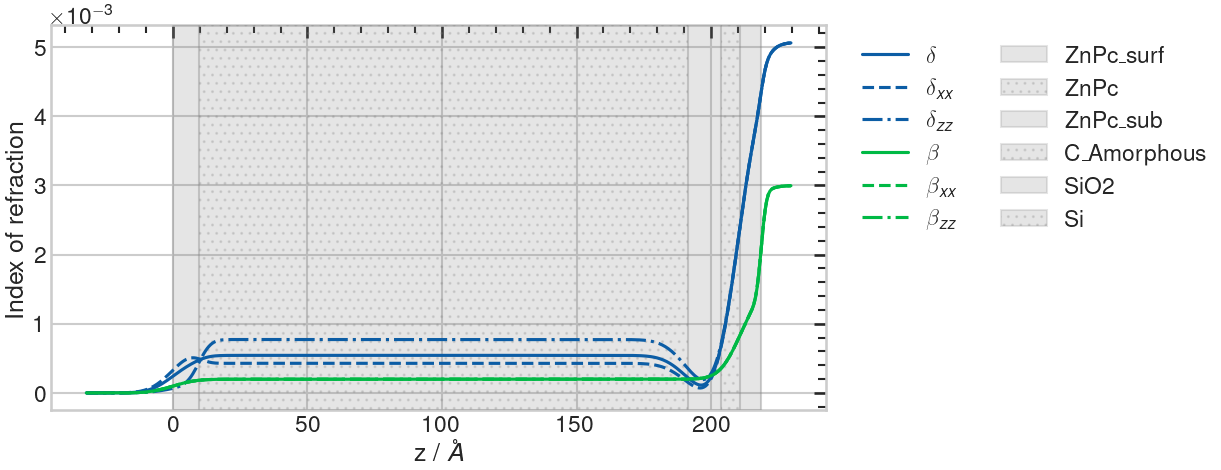

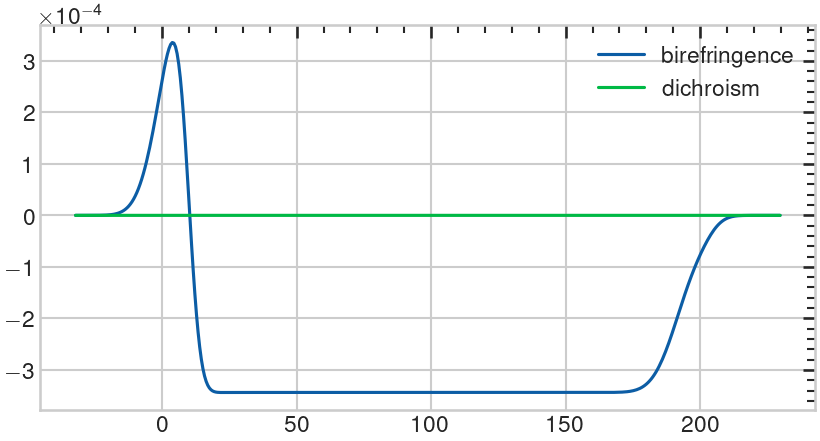

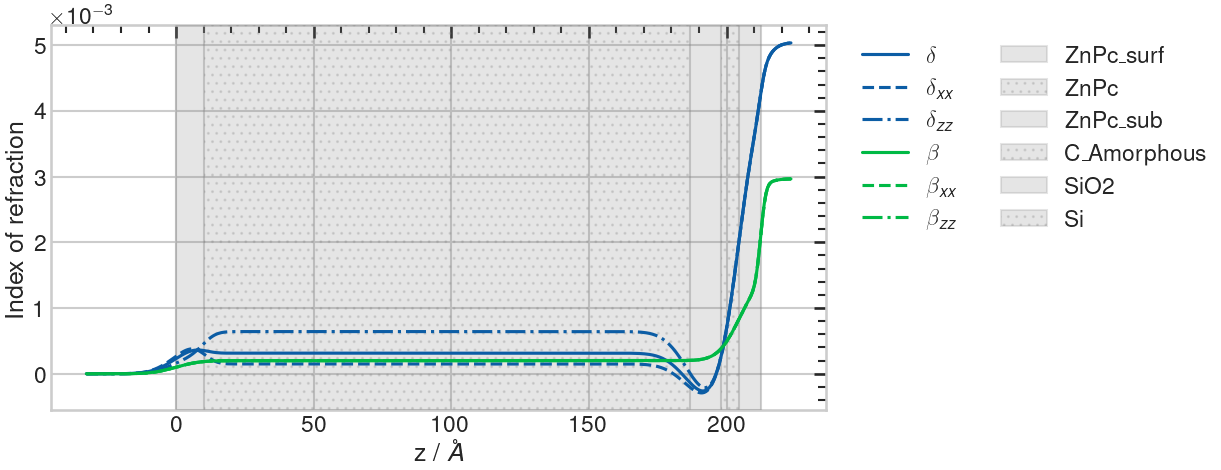

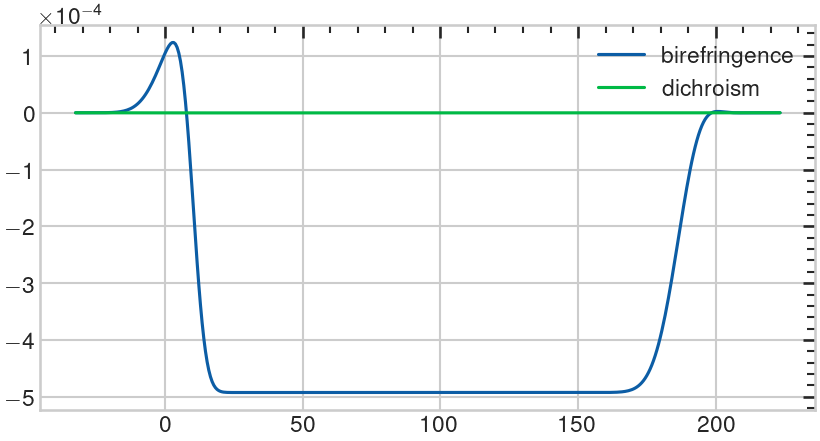

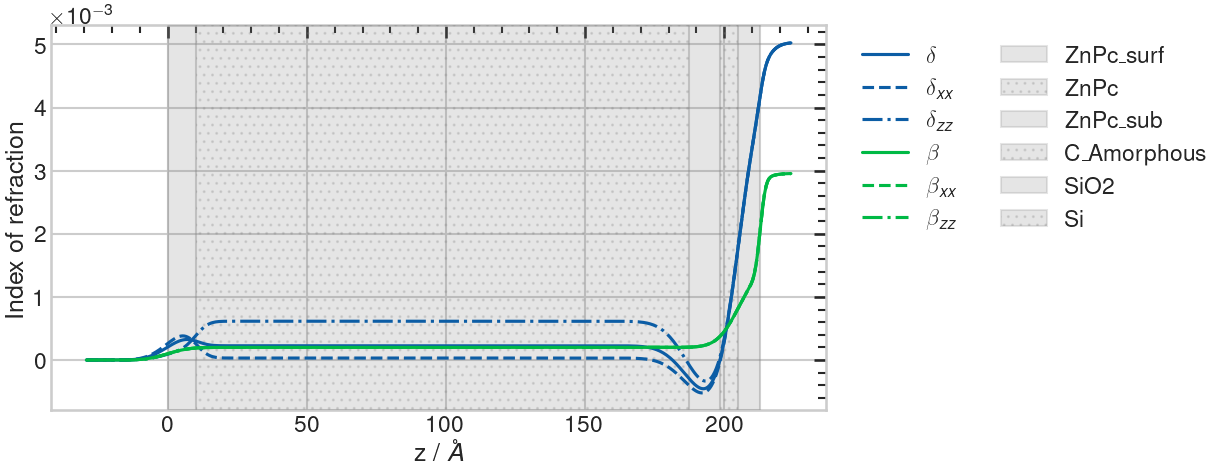

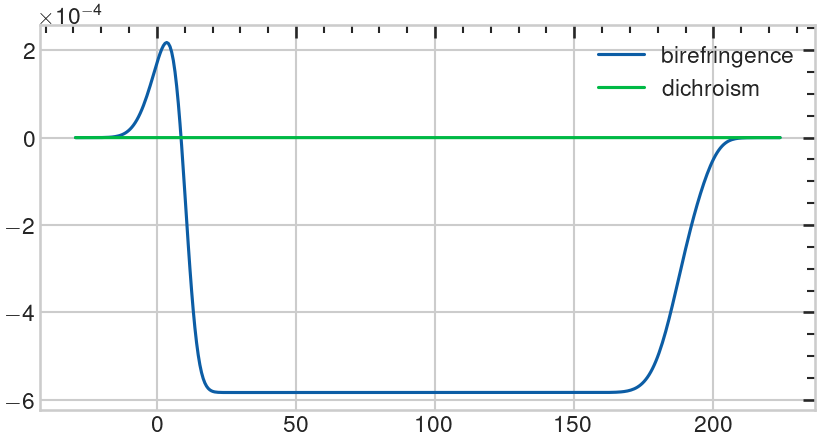

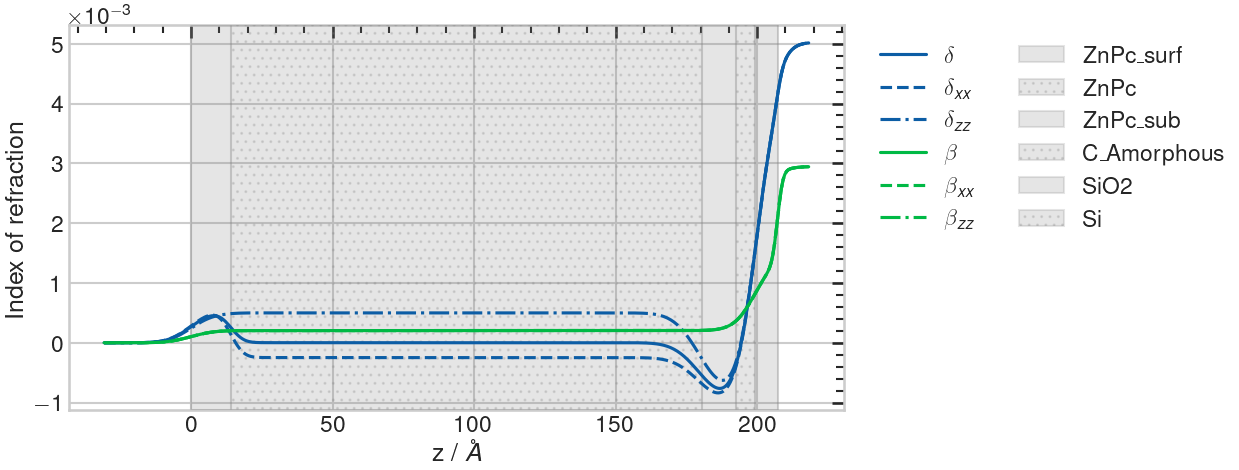

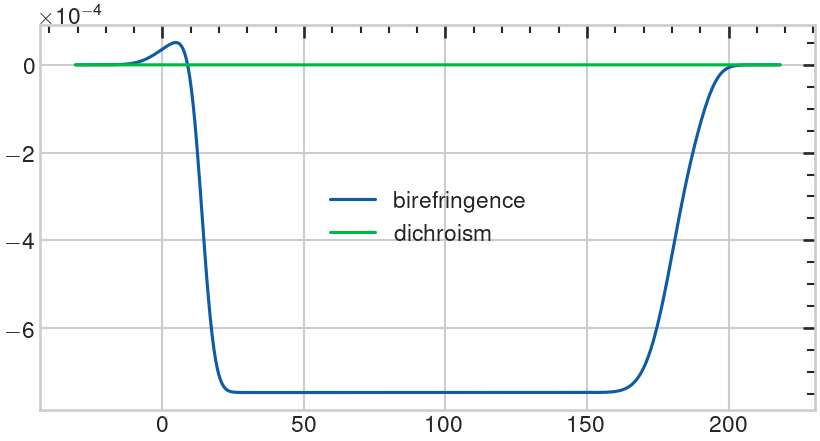

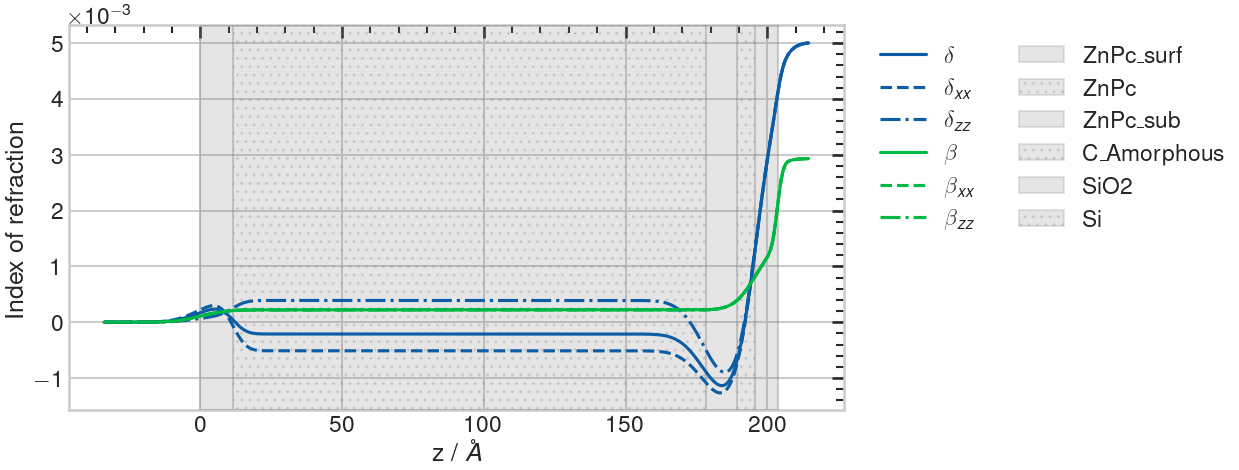

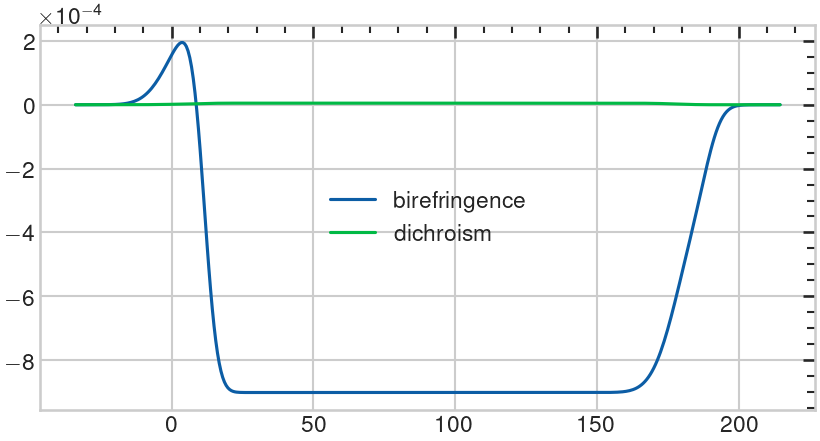

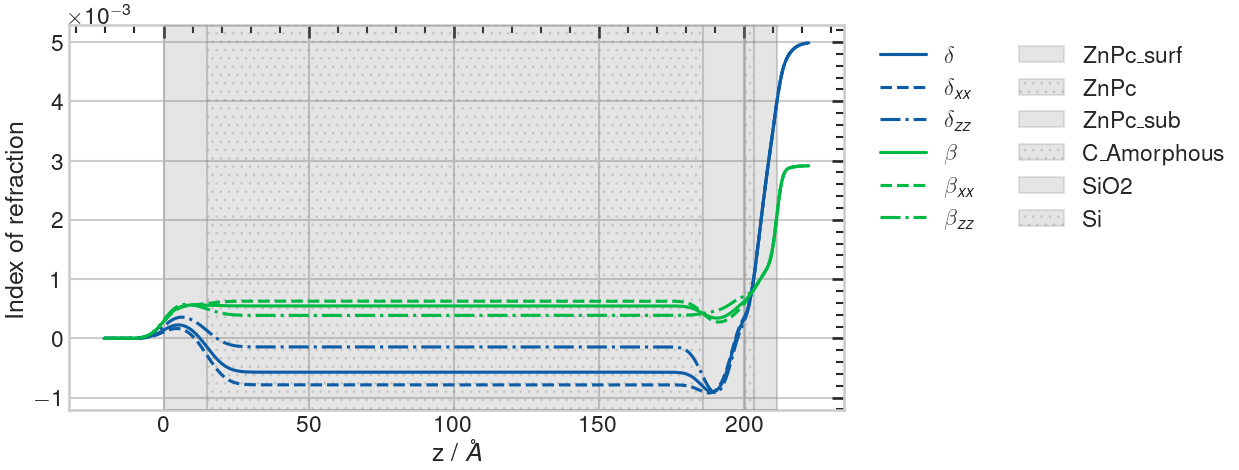

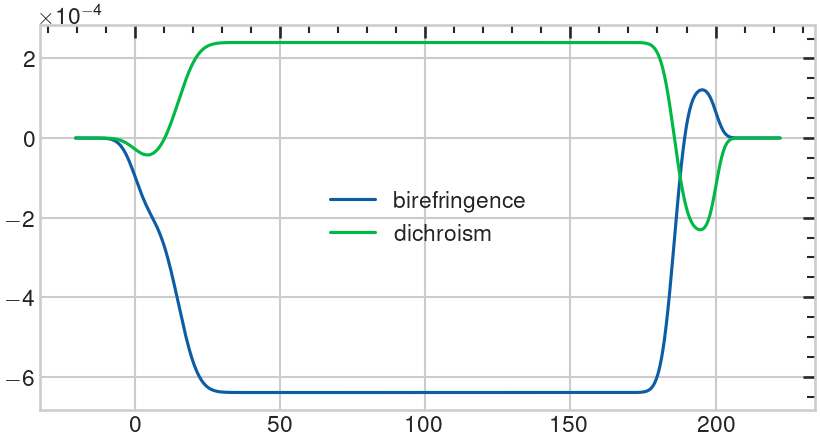

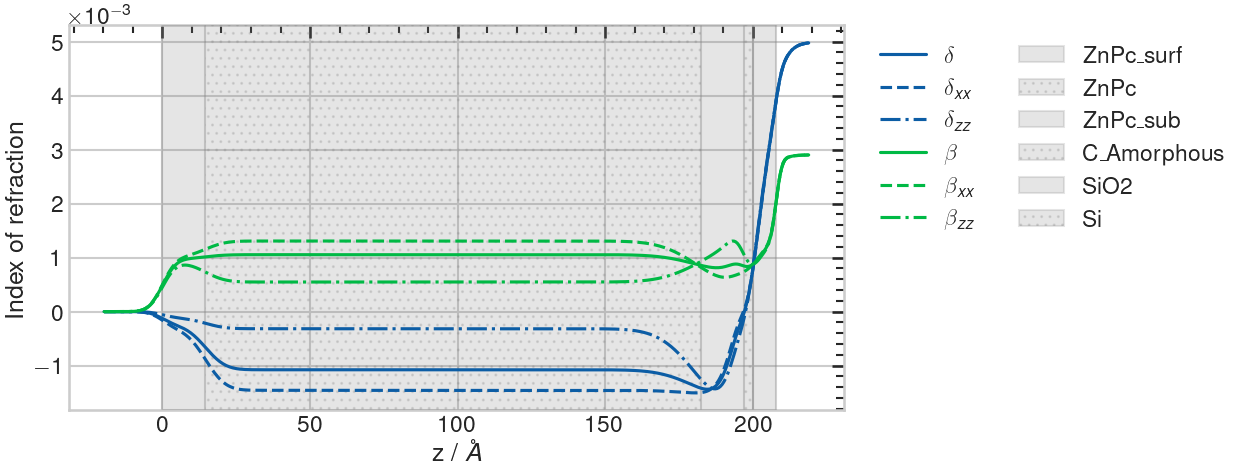

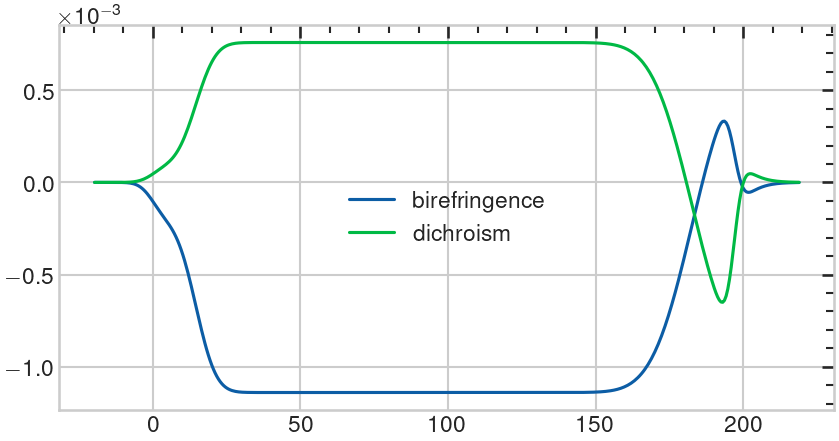

In [70]:
for struc in structs:
    struc.plot(difference = True)

0.07
0.0713
0.0715
0.0718
0.0719
0.072
0.0721
0.2702
0.2704


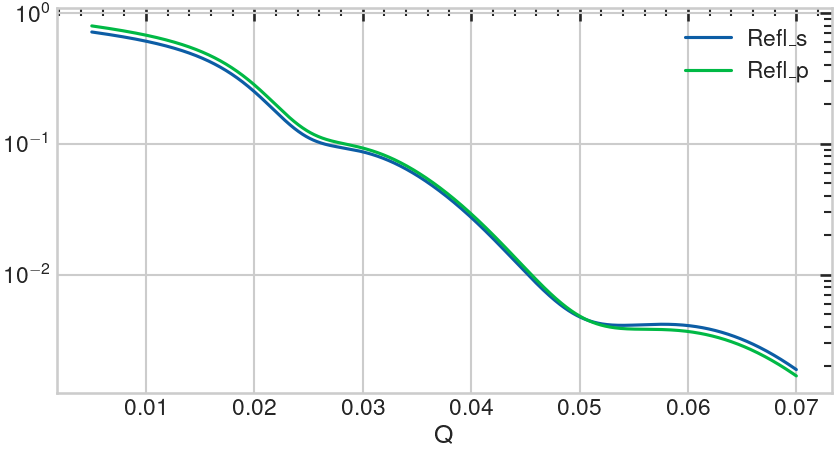

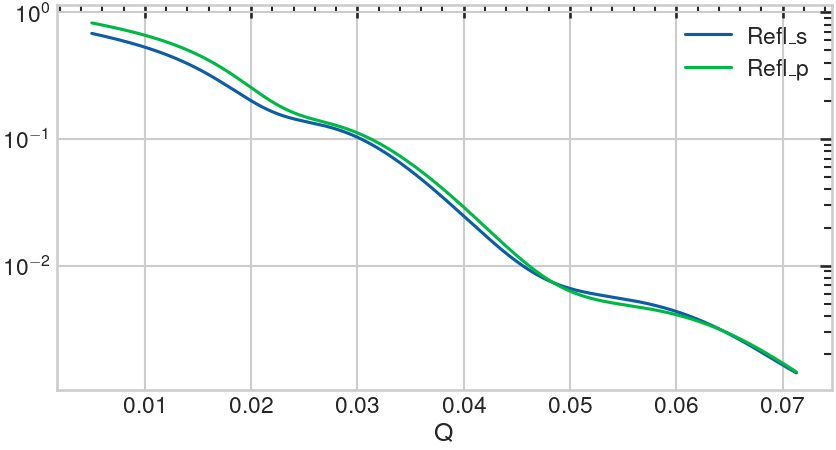

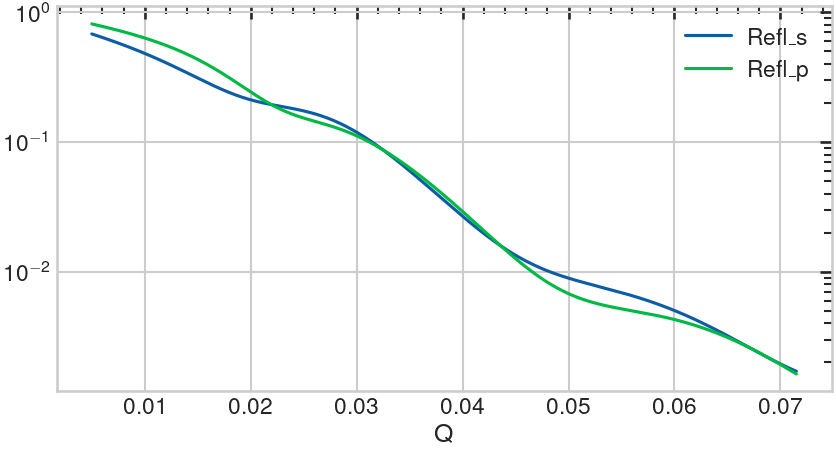

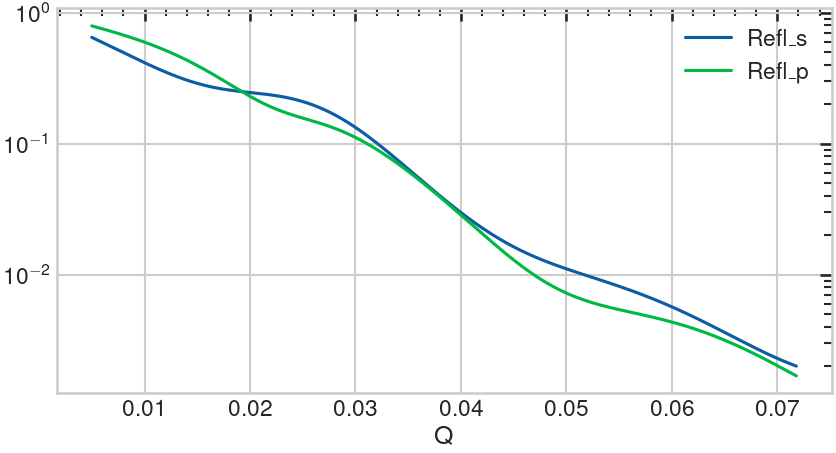

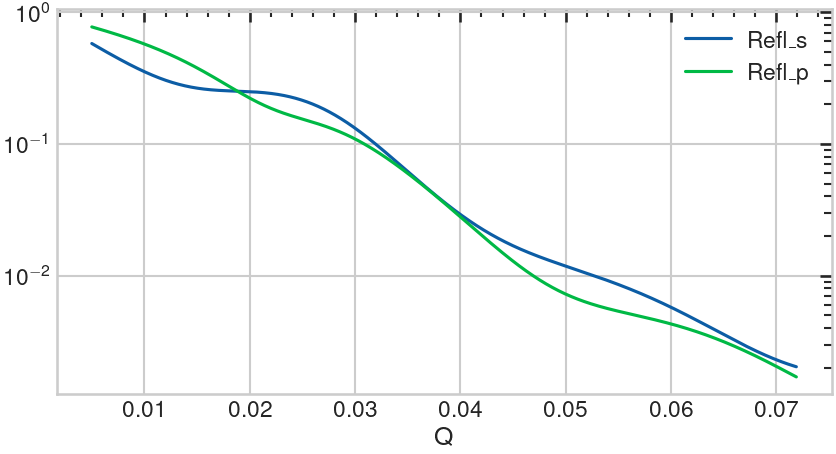

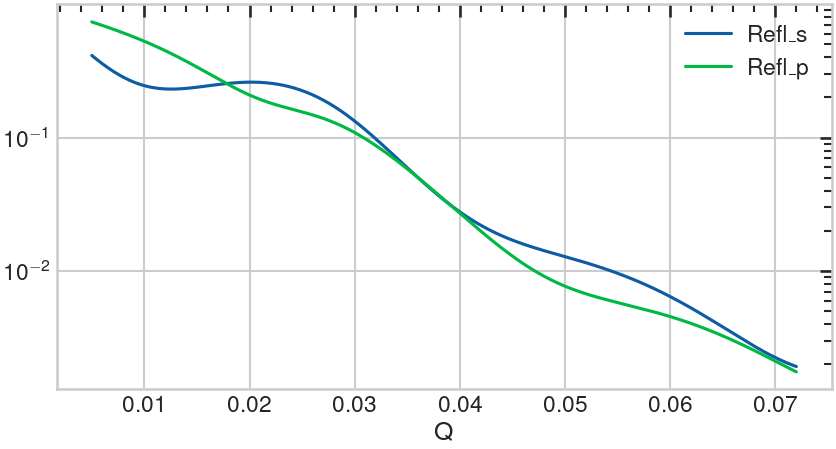

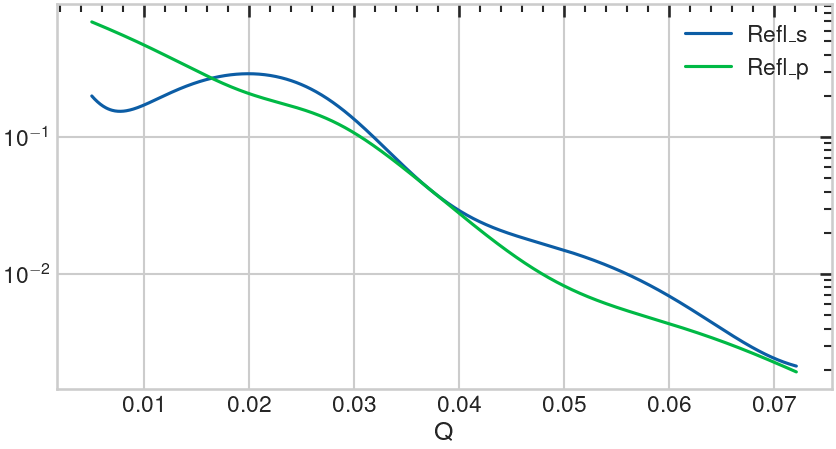

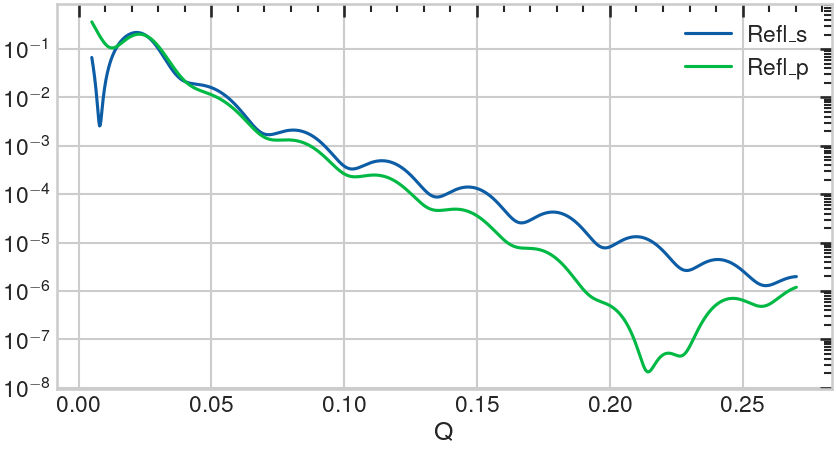

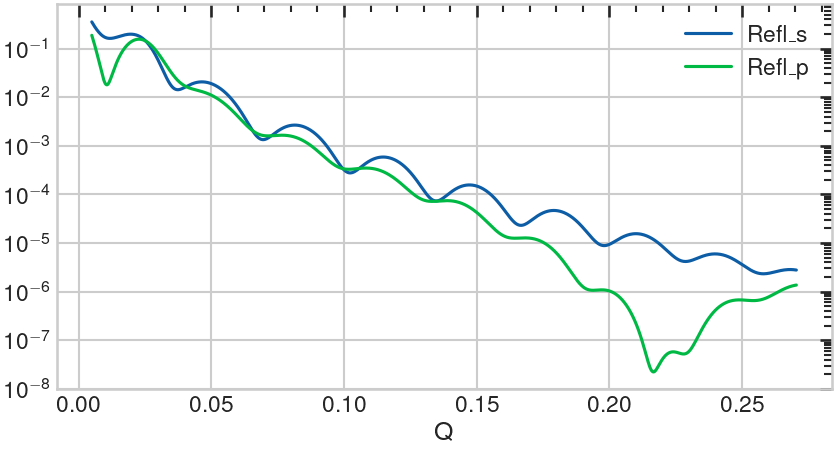

In [93]:
oc_list = []
model_res = []
def to_csv(obj):
    model = obj.model

    bkg = model.bkg.value
    scale_s = model.scale_s.value
    scale_p = model.scale_p.value
    theta_offset_s = model.theta_offset_s.value
    theta_offset_p = model.theta_offset_p.value

    structure = model.structure
    s_pol = PXR_ReflectModel(structure, energy = model.energy, pol="s", bkg=bkg, scale={"s": scale_s}, theta_offset={"s": theta_offset_s})
    p_pol = PXR_ReflectModel(structure, energy = model.energy, pol="p", bkg=bkg, scale={"p": scale_p}, theta_offset={"p": theta_offset_p})
    q_max = obj.data.data[0][-1]
    print(q_max)
    q = np.linspace(0.005, q_max, 1000)
    model_results = pd.DataFrame(
        {
            "Q": q,
            "Refl_s": s_pol(q),
            "Refl_p": p_pol(q),
        }
    )
    model_results.plot(x = "Q", y = ["Refl_s", "Refl_p"], logy = True)
    znpc_slab = structure[2]
    oc = save_optical_constant(model.energy, slab = znpc_slab)
    model_results.to_csv(f"{model.energy}_model.csv", index=False)
    model_res.append(model_results)
    oc_list.append(oc)
_ = [to_csv(obj) for obj in objs]
oc_df = pd.DataFrame(oc_list)
oc_df.to_csv(db.res / "ZnPc_OC.csv", index=False)

In [256]:
def struc_plot(
        struc:PXR_Structure, pvals=None, samples=0, fig=None, difference=False, slabs=True, align=0
    ):
        """
        Plot the structure.

        Requires matplotlib be installed.

        Parameters
        ----------
        pvals : np.ndarray, optional
            Numeric values for the Parameter's that are varying
        samples: number
            If this structures constituent parameters have been sampled, how
            many samples you wish to plot on the graph.
        fig: Figure instance, optional
            If `fig` is not supplied then a new figure is created. Otherwise
            the graph is created on the current axes on the supplied figure.
        difference: boolean, optional
            If True, plot the birefringence / dichroism on a separate graph.
        align: int, optional
            Aligns the plotted structures around a specified interface in the
            slab representation of a Structure. This interface will appear at
            z = 0 in the sld plot.

        Returns
        -------
        fig, ax : :class:`matplotlib.Figure`, :class:`matplotlib.Axes`
          `matplotlib` figure and axes objects.

        """
        import matplotlib.pyplot as plt

        params = struc.parameters

        if pvals is not None:
            params.pvals = pvals

        if fig is None:
            fig = plt.figure()
            ax = fig.add_subplot(111)
        else:
            ax = fig.gca()

        if samples > 0:
            saved_params = np.array(params)
            # Get a number of chains, chosen randomly, and plot the model.
            for pvec in struc.parameters.pgen(ngen=samples):
                params.pvals = pvec

                temp_zed, temp_prof = struc.sld_profile(align=align)
                temp_iso = temp_prof.sum(axis=1) / 3  # (nxx + nyy + nzz)/3
                ax.plot(temp_zed, temp_iso, color="k", alpha=0.01)

            # put back saved_params
            params.pvals = saved_params

        # parameters to plot
        zed, prof = struc.sld_profile(align=align)
        iso = prof.sum(axis=1) / 3
        ax.plot(zed, np.real(iso), color="C2", zorder=20, label=r"$\delta$")
        ax.plot(
            zed,
            np.real(prof[:, 0]),
            color="C2",
            zorder=10,
            label=r"$\delta_{xx}$",
            linestyle="--",
        )
        ax.plot(
            zed,
            np.real(prof[:, 2]),
            color="C2",
            zorder=10,
            label=r"$\delta_{zz}$",
            linestyle="-.",
        )
        ax.plot(zed, np.imag(iso), color="C0", zorder=20, label=r"$\beta$")
        ax.plot(
            zed,
            np.imag(prof[:, 0]),
            color="C0",
            zorder=10,
            label=r"$\beta_{xx}$",
            linestyle="--",
        )
        ax.plot(
            zed,
            np.imag(prof[:, 2]),
            color="C0",
            zorder=10,
            label=r"$\beta_{zz}$",
            linestyle="-.",
        )
        plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
        # ax.plot(*self.sld_profile(align=align), color='red', zorder=20)
        ax.set_ylabel("Index of Refraction")
        ax.set_xlabel("z / $\\AA$")
        ax.set_ylim(-1.5e-3, 2e-3)
        ax.grid(False)

        # if slabs:
        #     for i in range(1, len(struc.slabs())):
        #         start = np.sum(struc.slabs()[:i, 0])
        #         stop = start + struc.slabs()[i, 0]
        #         if i % 2 == 0:
        #             ax.axvspan(
        #                 start,
        #                 stop,
        #                 zorder=0,
        #                 color="C4",
        #                 alpha=0.2,
        #                 hatch="..",
        #             )
        #         else:
        #             ax.axvspan(
        #                 start,
        #                 stop,
        #                 zorder=0,
        #                 color="C0",
        #                 alpha=0.2,
        #                 hatch="x"
        #             )

        if difference:
            #  Add to the last axis a plot of birefringence
            diffax = ax.twinx()
            diffax.set_ylabel(r"$\delta_{xx}-\delta_{zz}$")
            diffax.tick_params(axis="y", which="both", colors="lightcoral", left=False)
            diffax.set_ylim(ax.get_ylim())

            diffax.get_yticklabels()[-1].set_visible(False)


            diff = prof[:, 0] - prof[:, 2]
            diffax.fill(
                zed, np.real(diff), color="lightcoral", zorder=0, alpha=.5
            )

            _min = np.min(np.real(diff))
            _max = np.max(np.real(diff))
            diffax.spines["right"].set_color("lightcoral")
            diffax.spines["right"].set_bounds(_min,_max)
            # Remove ytick_labels from the right axis if they are above or below the spine
            out_of_bounds = [
                i
                for i in diffax.get_yticklabels()
                if float(i.get_text()) > _max or float(i.get_text()) < _min
            ]
            for i in out_of_bounds:
                i.set_visible(False)

            diffax.grid(False)
            ax.legend()
            ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
        plt.legend(ncols=2)
        return fig, ax

In [203]:
plt.rcParams.update(
    {
        "figure.figsize": (10, 5),
        "figure.dpi": 100,
        "axes.facecolor": "(0, 0, 0, 0)",
        "axes.linewidth": 1.875,
        "lines.linewidth": 2.25,
        "lines.markersize": 9.0,
        "patch.linewidth": 1.5,
        "ytick.left": True,
        "xtick.bottom": True,
        "xtick.major.width": 1.875,
        "ytick.major.width": 1.875,
        "xtick.minor.width": 1.5,
        "ytick.minor.width": 1.5,
        "xtick.major.size": 9.0,
        "ytick.major.size": 9.0,
        "xtick.minor.size": 6.0,
        "ytick.minor.size": 6.0,
        "font.size": 18.0,
        "axes.labelsize": 18.0,
        "axes.titlesize": 18.0,
        "xtick.labelsize": 16.5,
        "ytick.labelsize": 16.5,
        "legend.fontsize": 16.5,
        "legend.title_fontsize": 18.0,
        "errorbar.capsize": 1.5,
    }
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


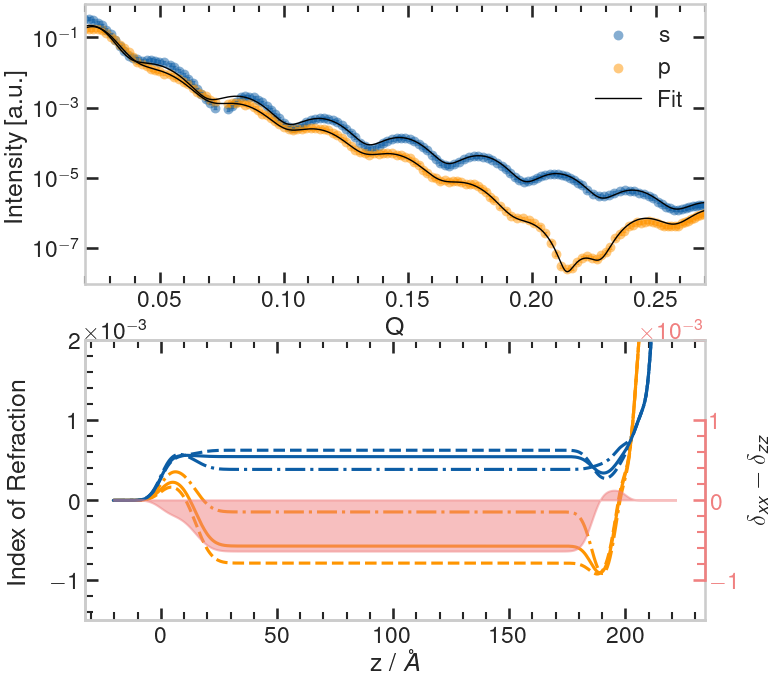

In [257]:
fig, ax = plt.subplots(nrows = 2, figsize=(8,8), gridspec_kw={"hspace":0.2})
# Plot data and fit for 183.7 eV
s, p = mask(znpc_mono[f"{283.7}"]["s"], znpc_mono[f"{283.7}"]["p"])

res = model_res[-2]
struc = structs[-2]
s.plot(ax = ax[0], x = "Q", y = "Refl", yerr = "Err", logy = True, label = "s", color="C0", zorder=1, s = 50, kind="scatter", alpha=0.5, linewidth=0)
p.plot(ax = ax[0], x = "Q", y = "Refl", yerr = "Err", logy = True, label = "p", color="C2", zorder=1, s = 50, kind="scatter", alpha=0.5, linewidth=0)
ax[0].plot(res["Q"], res["Refl_s"], label = "Fit", color = "k", zorder=2, linewidth=1)
ax[0].plot(res["Q"], res["Refl_p"], color = "k", zorder=2, linewidth=1)
ax[0].legend()
ax[0].set(
    ylabel = r"Intensity [a.u.]",
    xlim = (0.02, 0.27),
)
ax[0].grid(False)

struc_plot(struc, fig=fig, difference=True)


ax[1].yaxis.set_label_coords(-0.09, 0.5)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

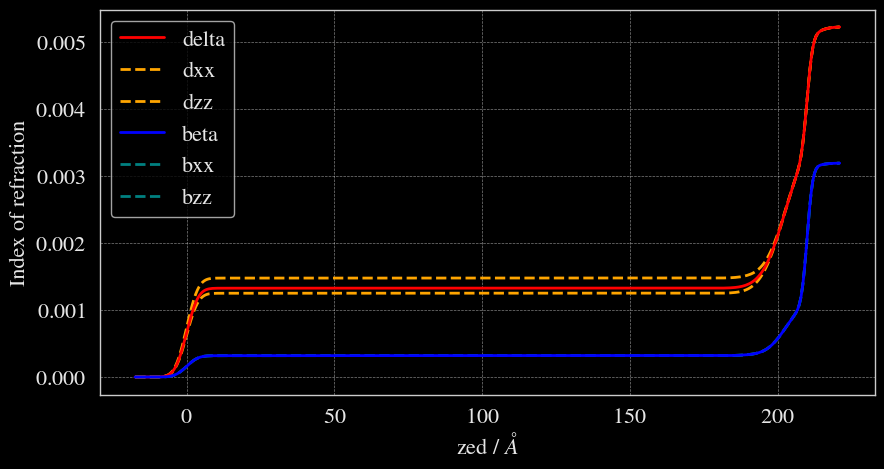

In [42]:
structs[0].plot()

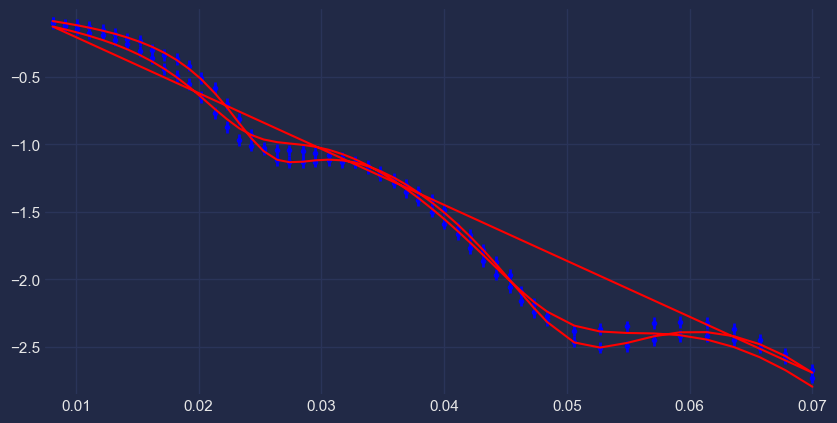

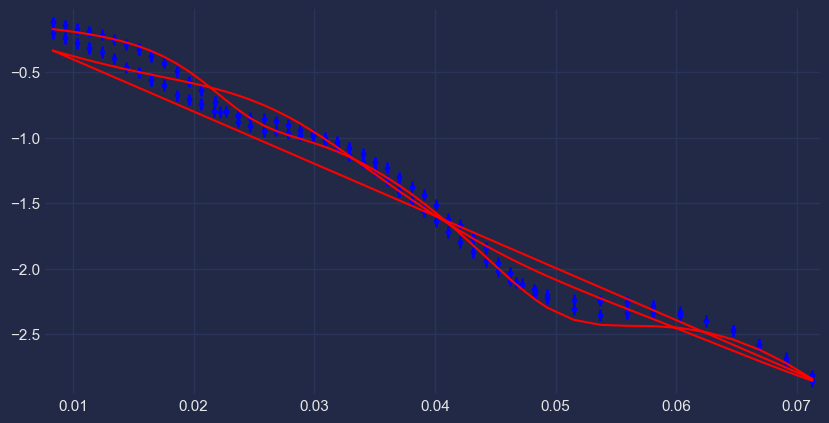

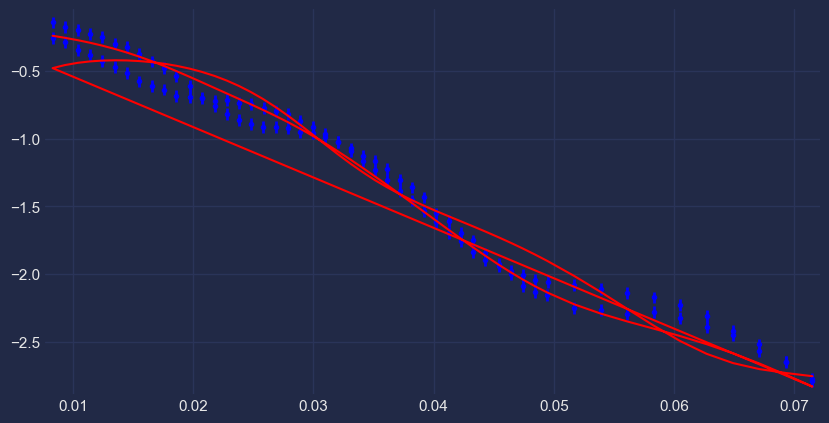

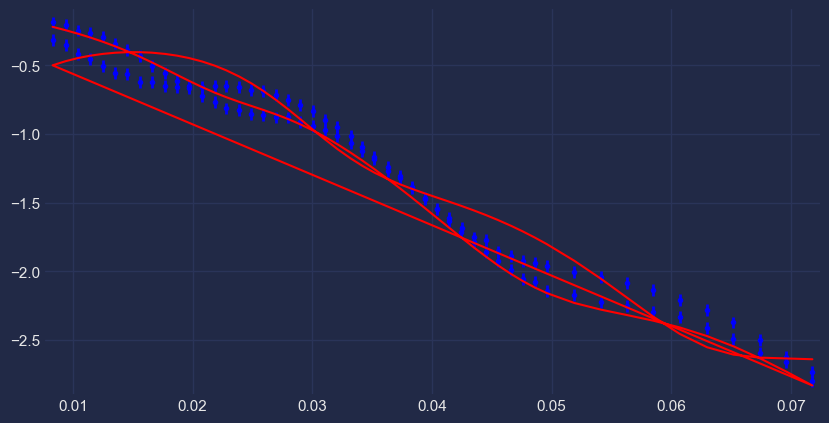

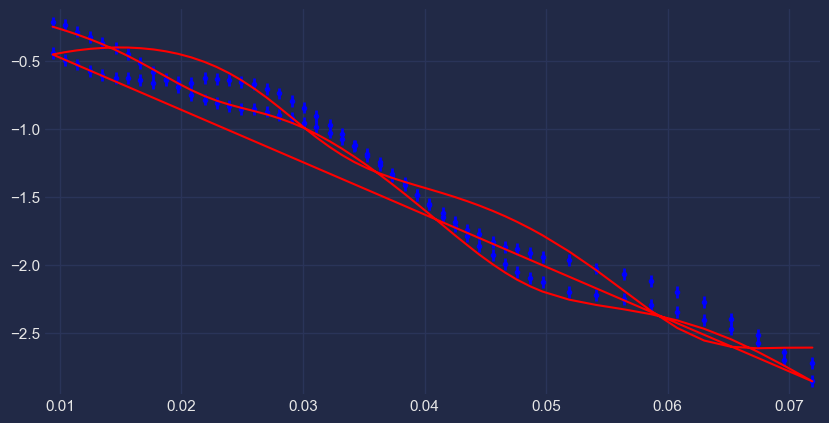

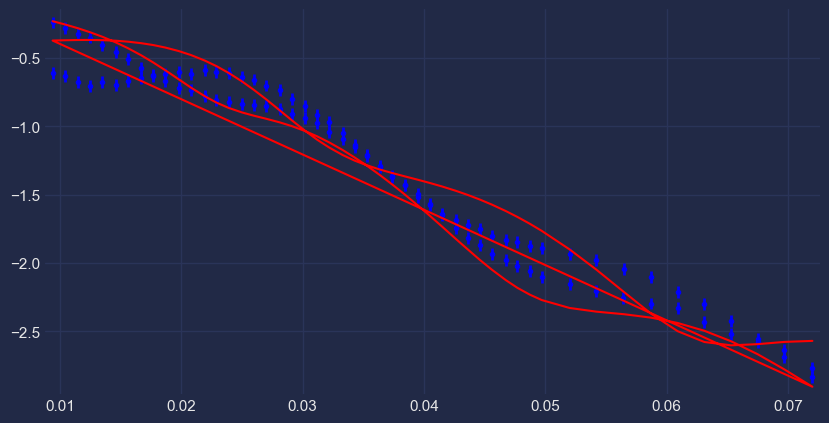

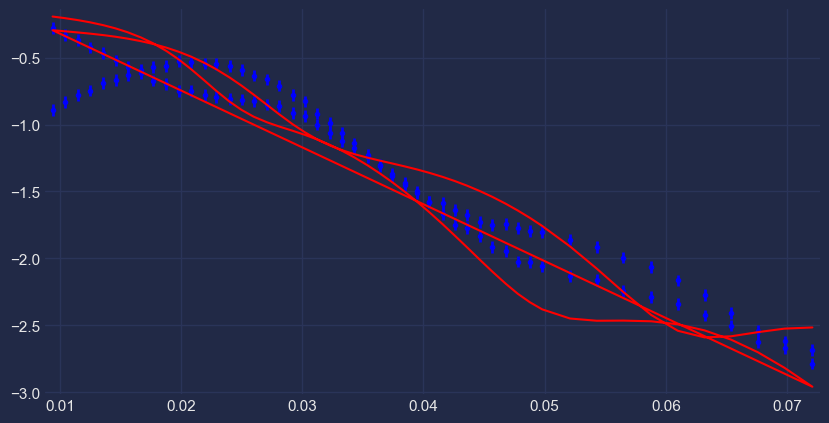

In [23]:
for i, _ in enumerate(ens):
    objs[i].plot()

[Text(0.5, 1.0, '$200 \\AA$ ZnPc Mono Layer Reflectivity Data'),
 Text(0, 0.5, '$I_R / I_0$ [a.u.]'),
 None]

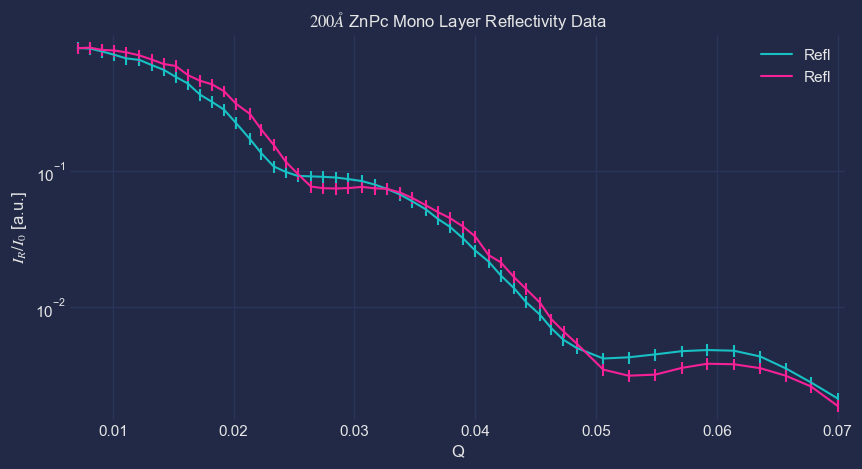

In [24]:
fig, ax = plt.subplots()

znpc_mono_275_s = znpc_mono["275"]["s"].iloc[6:]
znpc_mono_275_p = znpc_mono["275"]["p"].iloc[6:]

znpc_mono_275_s.plot(ax = ax, x = "Q", y = "Refl", yerr="Err")
znpc_mono_275_p.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err")

znpc_mono_275 = rf.to_refnx_dataset(znpc_mono_275_s, pol = "sp", second_pol=znpc_mono_275_p)

ax.set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

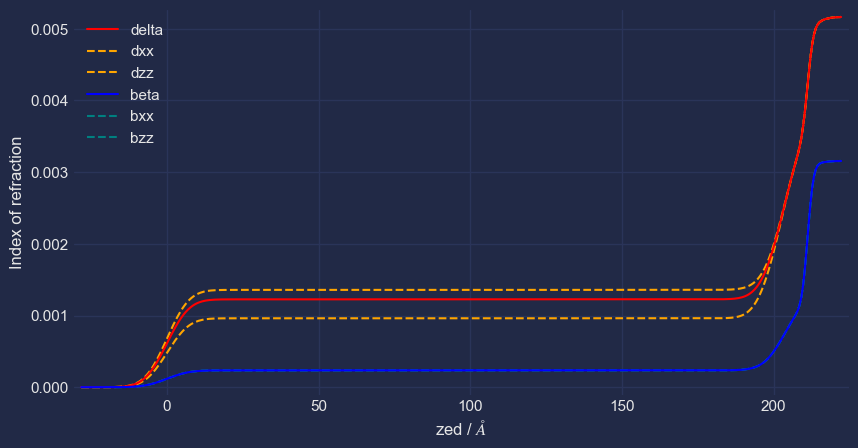

In [25]:
e = 275
vac = PXR_MaterialSLD("", 0, e)(0, 0)
si_1 = PXR_MaterialSLD("Si", si.sld.density, e, name="Si")(si_thick,si_rough)
sio2_1 = PXR_MaterialSLD("SiO2", sio2.sld.density, e, name="SiO2")(sio2_thick,sio2_rough)
c_amor_1 = PXR_MaterialSLD("C", c_amor.sld.density, e, name="C_Amorphous")(c_amor_thick, c_amor_rough)

n = np.array([znpc_oc["xx"].n(e), znpc_oc["zz"].n(e)])

znpc_1 = PXR_SLD(n, symmetry="uni", name = "ZnPc")(znpc_thick, znpc_rough)

struct_275 = vac | znpc_1 | c_amor_1 | sio2_1 | si_1
struct_275.plot()

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

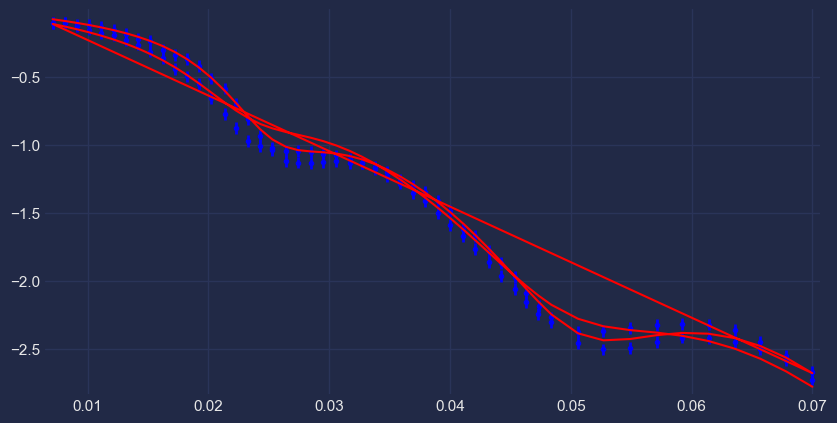

In [284]:
model_275 = PXR_ReflectModel(struct_275, pol = "sp", energy = e, name = "ZnPc Mono Layer 275eV")
model_275.scale.setp(vary = True, bounds = (0.6, 1.2))
model_275.bkg.setp(vary = True, bounds = (1e-9, 1e-6))


obj_275 = Objective(model_275, znpc_mono_275, transform=Transform("logY"))
obj_275.logp_extra = logp

obj_275.plot()

In [285]:
si_1.thick.setp(vary = False)
si_1.rough.setp(vary = False)

sio2_1.thick.setp(vary = None, constraint=sio2_thick)
sio2_1.rough.setp(vary = None, constraint=sio2_rough)
sio2_1.sld.density.setp(vary = None, constraint=sio2_density)

c_amor_1.thick.setp(vary = None, constraint=c_amor_thick)
c_amor_1.rough.setp(vary = None, constraint=c_amor_rough)
c_amor_1.sld.density.setp(vary = None, constraint=c_amor_density)

znpc_1.thick.setp(vary = None, constraint=znpc_thick)
znpc_1.rough.setp(vary = None, constraint=znpc_rough)

znpc_1.sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_1.sld.delta.setp(vary = True, bounds = (0,.002))

znpc_1.sld.xx.setp(vary = True, bounds = (znpc_1.sld.delta, .002))
znpc_1.sld.zz.setp(vary = True, bounds = (0, znpc_1.sld.delta))
znpc_1.sld.ixx.setp(vary = None, constraint = znpc_1.sld.beta)
znpc_1.sld.izz.setp(vary = None, constraint = znpc_1.sld.beta)

100%|██████████| 200/200 [01:34<00:00,  2.11it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.01279 +/- 0.0343, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=5.04535e-07 +/- 3.38e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=0.00119909 +/- 0.000584, bounds=[0.0, 0.002]>
<Parameter:  'ZnPc_biso'  , value=0.000293302 +/- 4.15e-05, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=0.00126716 +/- 5.92e-05, bounds=[0.001225398173210506, 0.002]>
<Parameter:   'ZnPc_zz'   , value=0.00121116 +/- 0.000109, bounds=[0.0, 0.001225398173210506]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

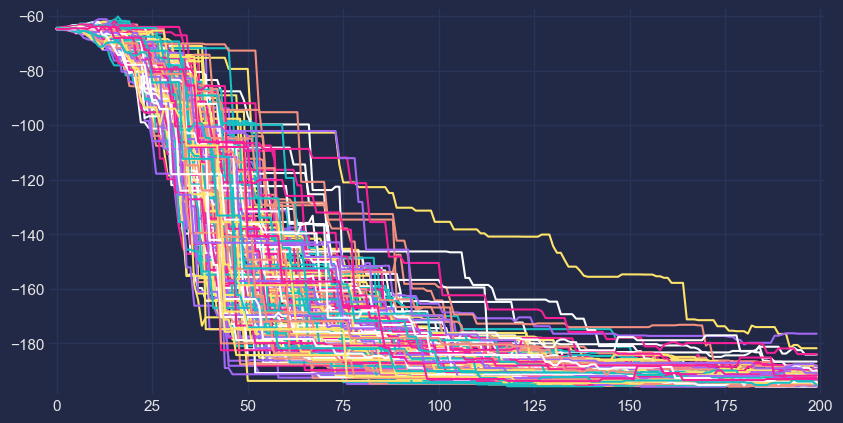

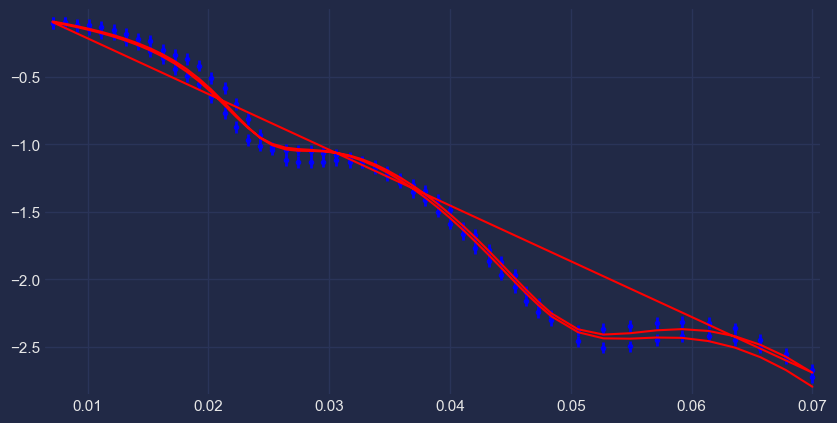

In [286]:
fitter = CurveFitter(obj_275, nwalkers=nwalkers, moves = move)
fitter.initialise("jitter")
chain = fitter.sample(int(nwalkers), random_state=random_state)
lp = fitter.logpost
plt.plot(-lp)

print(obj_275.varying_parameters())
obj_275.plot()

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

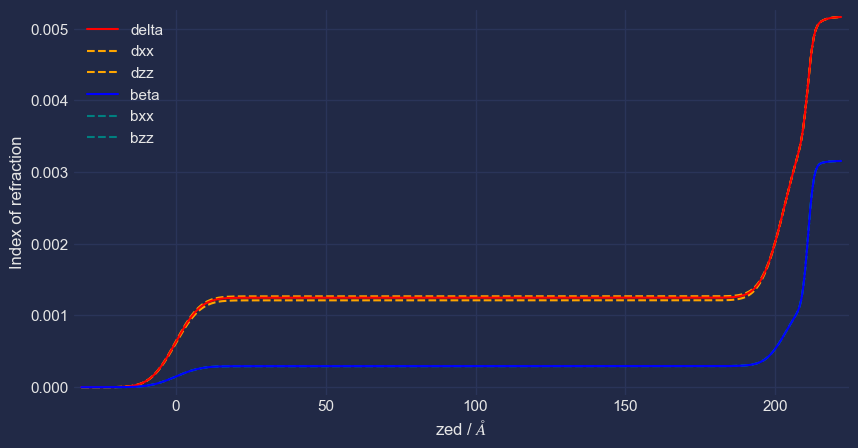

In [287]:
struct_275.plot()

In [288]:
# to_json(struct_275, db.res / "ZnPc_275eV_struct.json")
# to_json(obj_275, db.res / "ZnPc_275eV_obj.json")

# model_275_s = PXR_ReflectModel(struct_275, pol = "s", energy = 275, name = "ZnPc Mono Layer 275eV")(q)
# model_275_p = PXR_ReflectModel(struct_275, pol = "p", energy = 275, name = "ZnPc Mono Layer 275eV")(q)

# np.savetxt(db.res / "ZnPc_275eV_s_fit.txt", np.row_stack([q, model_275_s]), delimiter = ",")
# np.savetxt(db.res / "ZnPc_275eV_p_fit.txt", np.row_stack([q, model_275_p]), delimiter = ",")


oc_res.loc[oc_res["energy"] == "275", "xx"] = znpc_1.sld.xx.value
oc_res.loc[oc_res["energy"] == "275", "zz"] = znpc_1.sld.zz.value
oc_res.loc[oc_res["energy"] == "275", "dxx"] = znpc_1.sld.xx.stderr
oc_res.loc[oc_res["energy"] == "275", "dzz"] = znpc_1.sld.zz.stderr
oc_res.loc[oc_res["energy"] == "275", "delta"] = znpc_1.sld.delta.value
oc_res.loc[oc_res["energy"] == "275", "ddelta"] = znpc_1.sld.delta.stderr
oc_res.loc[oc_res["energy"] == "275", "ixx"] = znpc_1.sld.ixx.value
oc_res.loc[oc_res["energy"] == "275", "izz"] = znpc_1.sld.izz.value
oc_res.loc[oc_res["energy"] == "275", "dixx"] = znpc_1.sld.ixx.stderr
oc_res.loc[oc_res["energy"] == "275", "dizz"] = znpc_1.sld.izz.stderr
oc_res.loc[oc_res["energy"] == "275", "beta"] = znpc_1.sld.beta.value
oc_res.loc[oc_res["energy"] == "275", "dbeta"] = znpc_1.sld.beta.stderr


oc_res

C:\Users\Harlan Heilman\AppData\Local\Temp\ipykernel_21672\3862221966.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0012671579928020648' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  oc_res.loc[oc_res["energy"] == "275", "xx"] = znpc_1.sld.xx.value
C:\Users\Harlan Heilman\AppData\Local\Temp\ipykernel_21672\3862221966.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0012111617575859854' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  oc_res.loc[oc_res["energy"] == "275", "zz"] = znpc_1.sld.zz.value
C:\Users\Harlan Heilman\AppData\Local\Temp\ipykernel_21672\3862221966.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.916137065707021e-05' has dtype incompatible with int64, p

xx        zz       dxx       dzz     delta    ddelta       ixx  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.001267  0.001211  0.000059  0.000109  0.001199  0.000584  0.000293   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        izz      dixx      dizz      beta     dbeta energy  
0  0.000000  0.000000  0.000000  0.000000  0.000000    250  
1  0.000293  0.000042  0.000042  0.000293  0.000042    275  
2  0.000000  0.000000  0.000000  0.000000  0.000000    280  
3  0.000000  0.000000  0.000000  0.000000  0.000000    281  
4  0.000000  0.000000  0.000000  0.000000  0.000000    282  
5  0.000000  0.000000  0.000000  0.000000  0.000000  282.3  
6  0.000000  0.000000  0.000000  0.000000  0.000000  282.7  
7  0.000000  0.000000  0.000000  0.000000  0.000000  283.1  
8  0.000000  0.000000  0.000000  0.000000  0.000000  283.7  
9  0.000000  0.000000  0.000000  0.000000  0.000000  284.1

## Fit 280, 281, 281.2

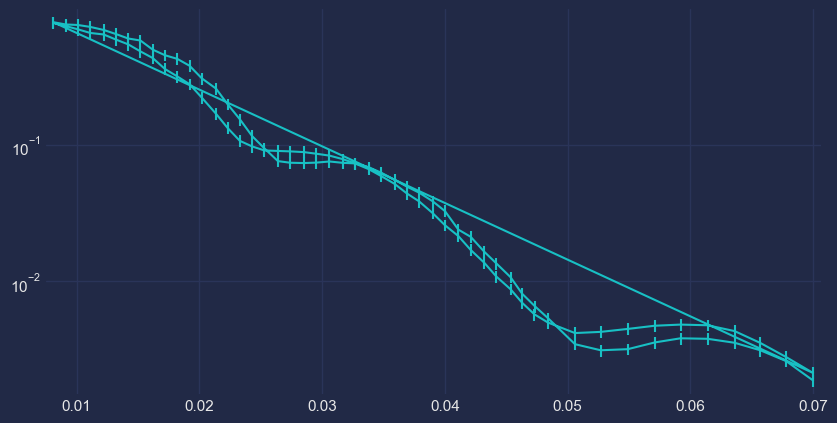

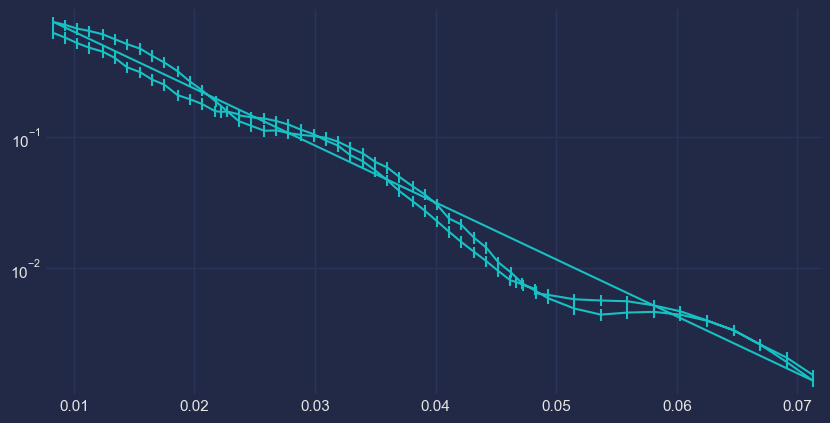

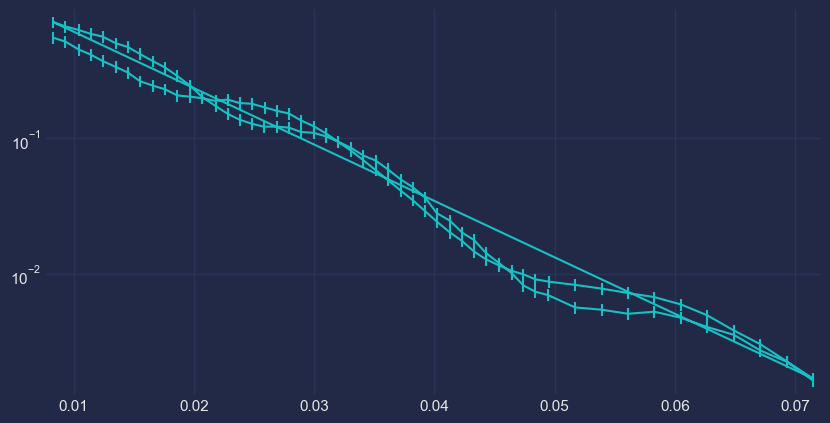

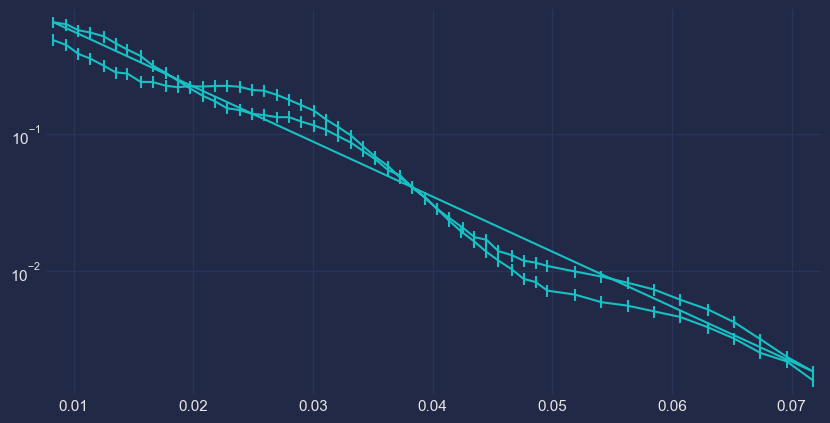

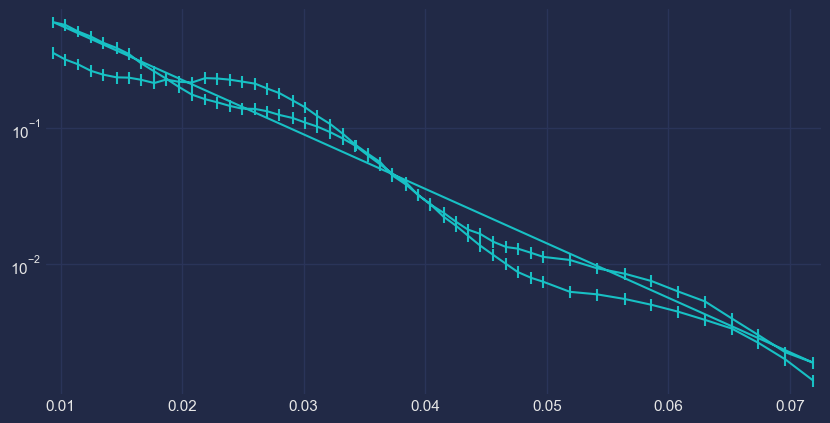

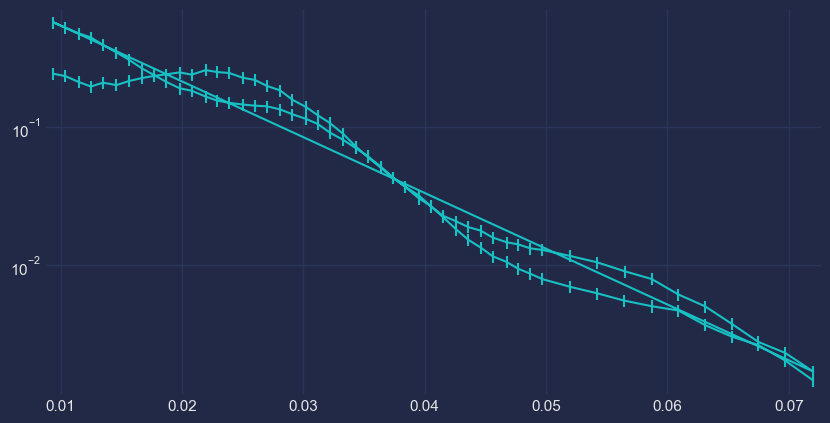

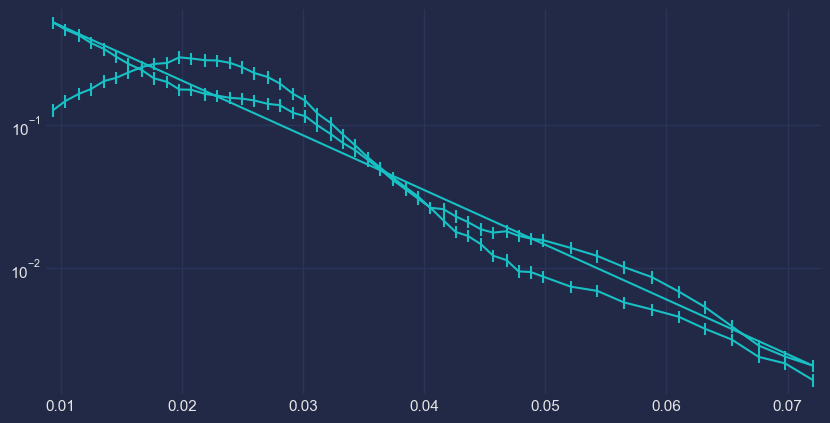

In [310]:
znpc_mono_series = []

for i, e in enumerate(ens):
    cutoff = 7 if i <= 3 else 8
    s = znpc_mono[f"{e}"]["s"].iloc[cutoff:]
    p = znpc_mono[f"{e}"]["p"].iloc[cutoff:]
    refl_data = rf.to_refnx_dataset(s, pol = "sp", second_pol=p)
    refl_data.plot()
    plt.yscale("log")
    znpc_mono_series.append(refl_data)

In [290]:
print(znpc_oc["xx"].n(281))
oc_res.loc[oc_res["energy"] == "281", "zz"]

(0.0009193269123370804+0.00023118639358234467j)


3    0.0
Name: zz, dtype: float64

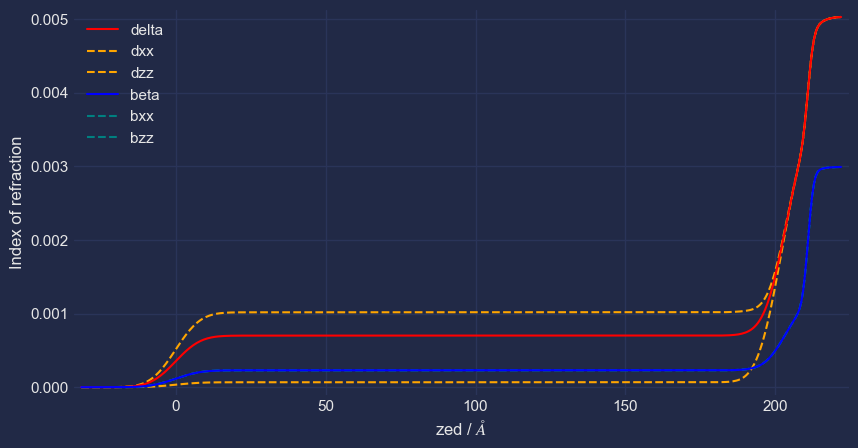

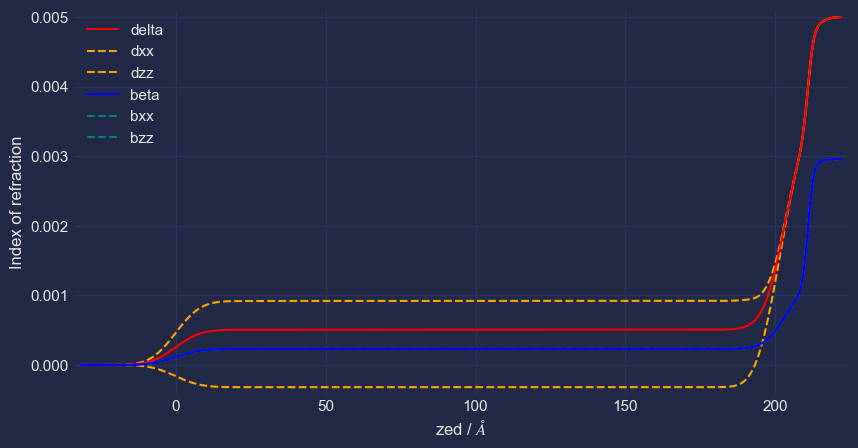

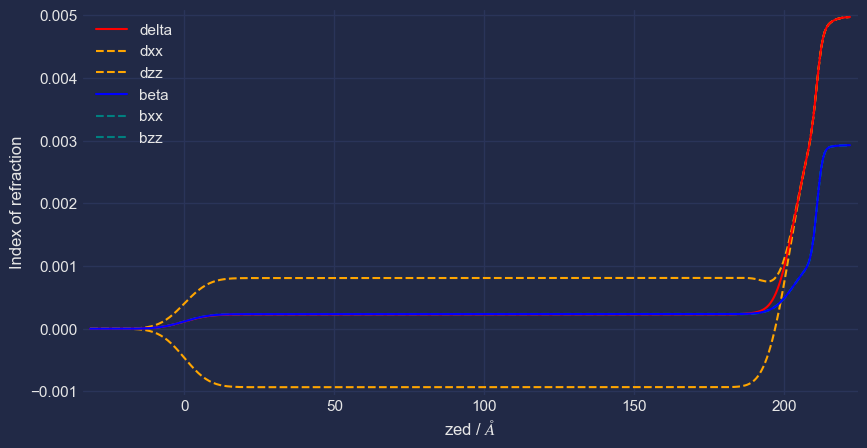

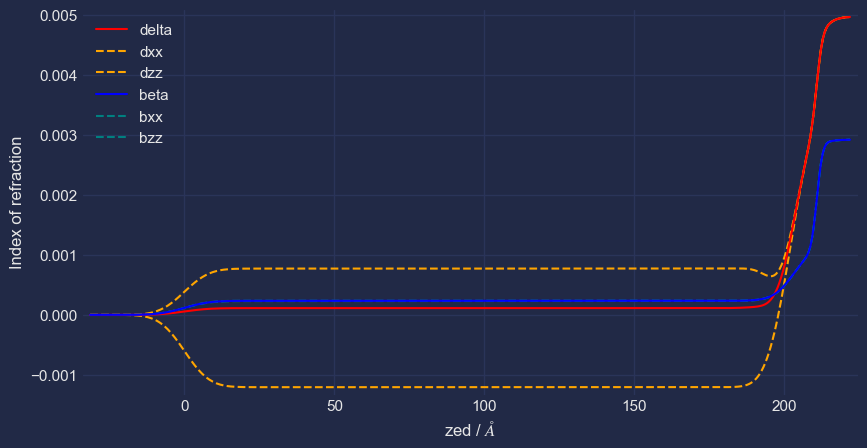

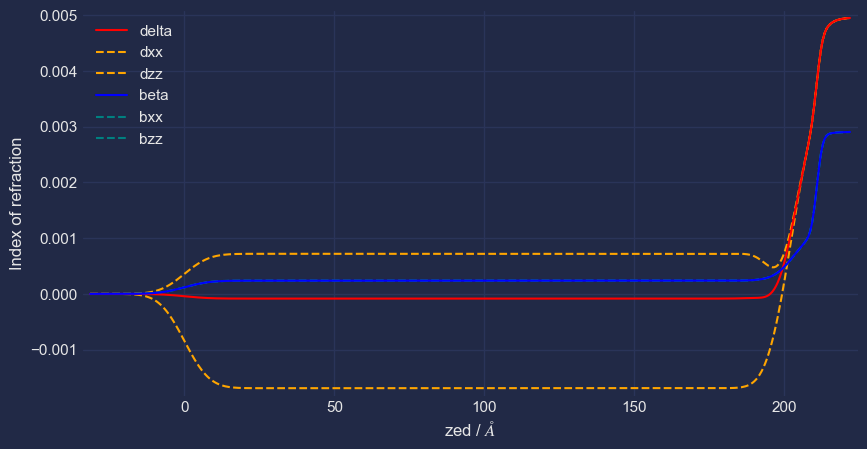

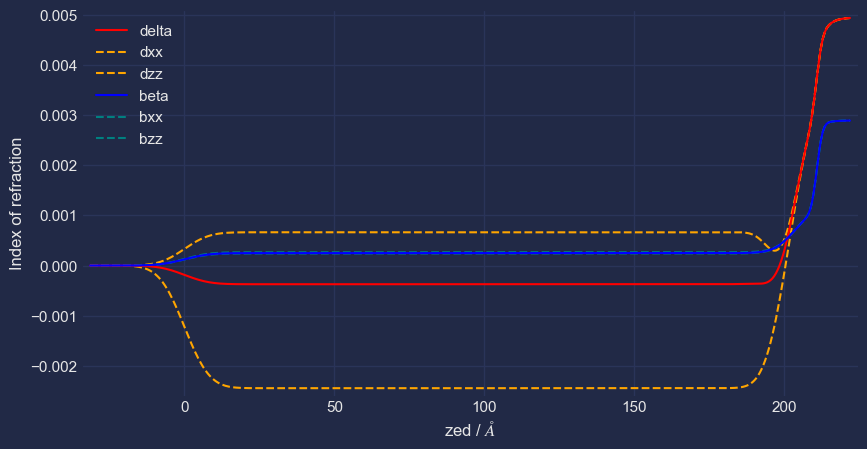

In [291]:
vac = [PXR_MaterialSLD("", 0, en)(0, 0) for en in ens]
si_2 = [PXR_MaterialSLD("Si", si.sld.density, en, name="Si")(si_thick,si_rough) for en in ens]
sio2_2 = [PXR_MaterialSLD("SiO2", sio2.sld.density, en, name="SiO2")(sio2_thick,sio2_rough) for en in ens]
c_amor_2 = [PXR_MaterialSLD("C", c_amor.sld.density, en, name="C_Amorphous")(c_amor_thick, c_amor_rough) for en in ens]

znpc_2 = [PXR_SLD(np.array([znpc_oc["xx"].n(en), znpc_oc["zz"].n(en)]), symmetry="uni", name = "ZnPc")(znpc_thick, znpc_rough) for en in ens]

structs = [vac[i] | znpc_2[i] | c_amor_2[i] | sio2_2[i] | si_2[i] for i in range(len(ens))]

for struc in structs:
    struc.plot()

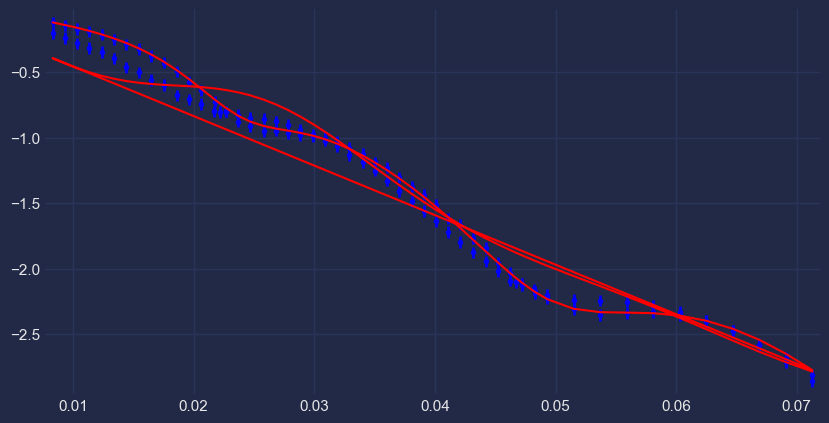

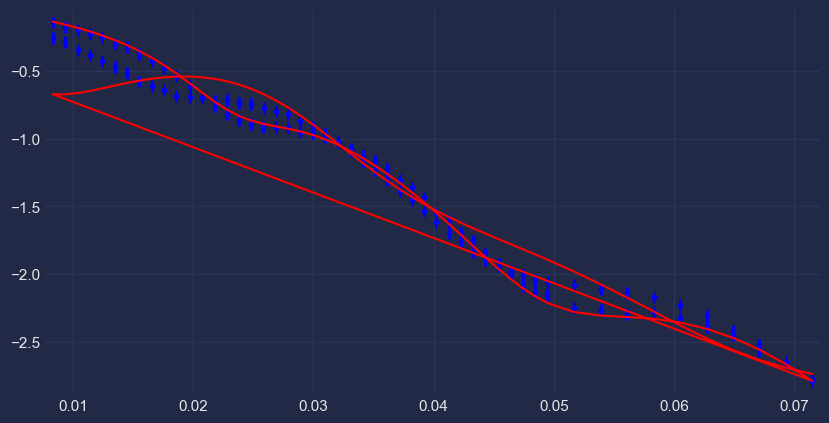

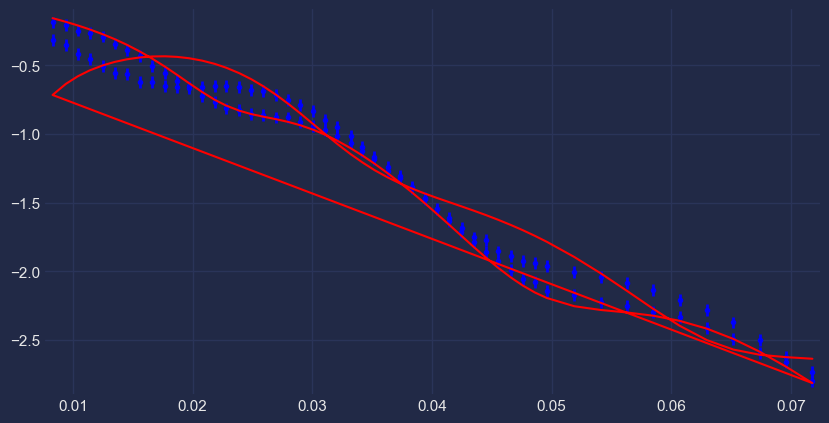

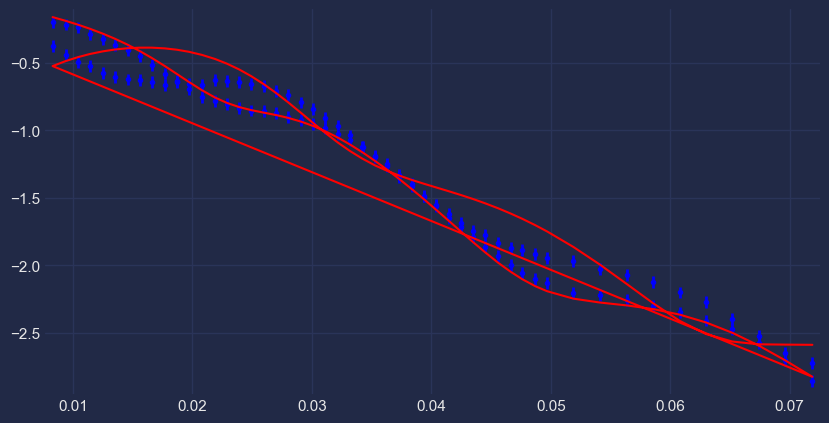

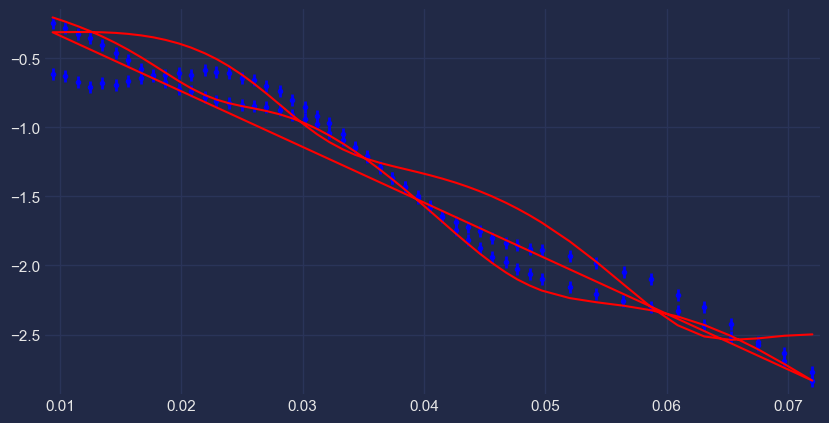

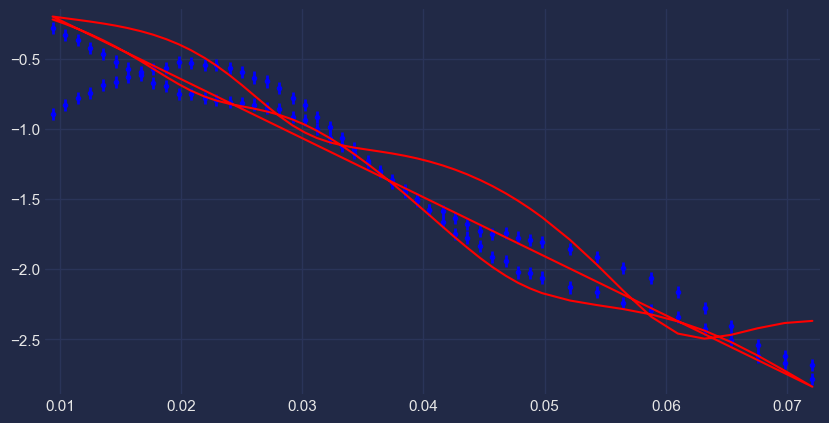

In [292]:
models = [PXR_ReflectModel(structs[i], pol = "sp", energy = ens[i], name = "ZnPc Mono Layer " + str(ens[i]) + "eV") for i in range(len(ens))]

for model in models:
    model.scale.setp(vary = True, bounds = (0.6, 1.2))
    model.bkg.setp(vary = True, bounds = (1e-9, 1e-6))

objs = [Objective(models[i], znpc_mono_series[i], transform=Transform("logY")) for i in range(len(ens))]
for obj in objs:
    logp = LogpExtra_rough(obj)
    obj.logp_extra = logp

global_obj = GlobalObjective(objs)

for obj in objs:
    obj.plot()

### 280 eV

In [293]:
si_2[0].thick.setp(vary = False)
si_2[0].rough.setp(vary = False)

sio2_2[0].thick.setp(vary = None, constraint=sio2_thick)
sio2_2[0].rough.setp(vary = None, constraint=sio2_rough)
sio2_2[0].sld.density.setp(vary = None, constraint=sio2_density)

c_amor_2[0].thick.setp(vary = None, constraint=c_amor_thick)
c_amor_2[0].rough.setp(vary = None, constraint=c_amor_rough)
c_amor_2[0].sld.density.setp(vary = None, constraint=c_amor_density)

znpc_2[0].thick.setp(vary = None, constraint=znpc_thick)
znpc_2[0].rough.setp(vary = None, constraint=znpc_rough)

znpc_2[0].sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_2[0].sld.delta.setp(vary = True, bounds = (-.0001,.002))

znpc_2[0].sld.xx.setp(vary = True, bounds = (znpc_2[0].sld.delta, .002))
znpc_2[0].sld.zz.setp(vary = True, bounds = (-.0001, znpc_2[0].sld.delta))
znpc_2[0].sld.ixx.setp(vary = None, constraint = znpc_2[0].sld.beta)
znpc_2[0].sld.izz.setp(vary = None, constraint = znpc_2[0].sld.beta)

100%|██████████| 200/200 [00:15<00:00, 13.13it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.951573 +/- 0.0184, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=5.29682e-07 +/- 2.91e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=0.000980198 +/- 0.000648, bounds=[-0.0001, 0.002]>
<Parameter:  'ZnPc_biso'  , value=0.000237094 +/- 1.18e-05, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=0.000732874 +/- 2.97e-05, bounds=[0.0007001495016958878, 0.002]>
<Parameter:   'ZnPc_zz'   , value=0.000695671 +/- 7.08e-06, bounds=[-0.0001, 0.0007001495016958878]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

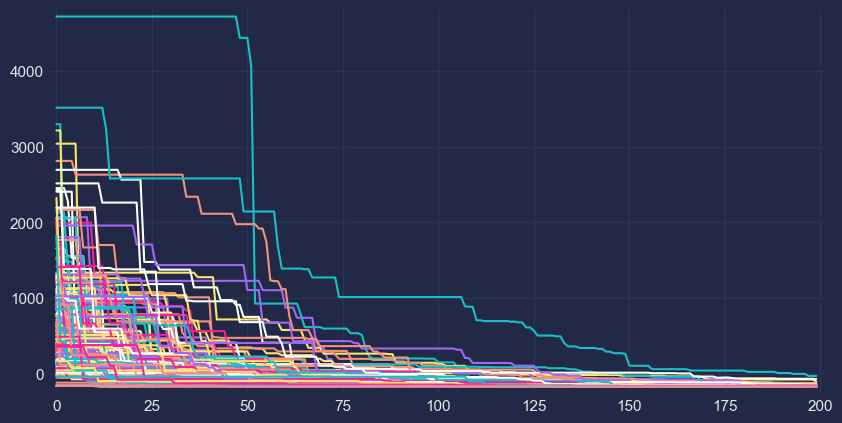

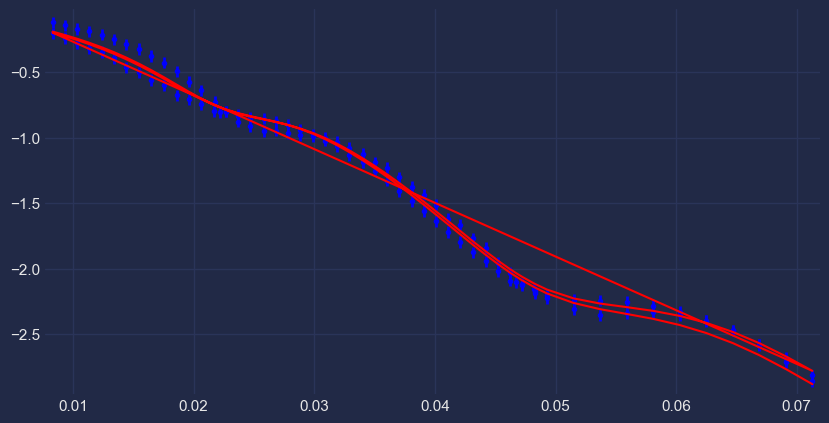

In [294]:
fitter_280 = CurveFitter(objs[0], nwalkers=nwalkers, moves = move)
fitter_280.initialise("prior")
chain_280 = fitter_280.sample(int(nwalkers), random_state=random_state)
lp_280 = fitter_280.logpost
plt.plot(-lp_280)

fitter_280.initialise("jitter")
chain_280 = fitter_280.sample(int(nwalkers), random_state=random_state)
lp_280 = fitter_280.logpost
plt.plot(-lp_280)

print(objs[0].varying_parameters())
objs[0].plot()

In [295]:
print(ens)

[280, 281, 282, 282.3, 282.7, 283.1]


In [296]:
import json


to_json(structs[0], db.res / "ZnPc_280eV_struct.json")
to_json(objs[0], db.res / "ZnPc_280eV_obj.json")



model_280_s = PXR_ReflectModel(structs[0], pol = "s", energy = ens[0], name = "ZnPc Mono Layer 280eV")(q)
model_280_p = PXR_ReflectModel(structs[0], pol = "p", energy = ens[0], name = "ZnPc Mono Layer 280eV")(q)

np.savetxt(db.res / "ZnPc_280eV_s_fit.txt", np.row_stack([q, model_280_s]), delimiter = ",")
np.savetxt(db.res / "ZnPc_280eV_p_fit.txt", np.row_stack([q, model_280_p]), delimiter = ",")

oc_res.loc[oc_res["energy"] == "280", "xx"] = znpc_2[0].sld.xx.value
oc_res.loc[oc_res["energy"] == "280", "zz"] = znpc_2[0].sld.zz.value
oc_res.loc[oc_res["energy"] == "280", "dxx"] = znpc_2[0].sld.xx.stderr
oc_res.loc[oc_res["energy"] == "280", "dzz"] = znpc_2[0].sld.zz.stderr
oc_res.loc[oc_res["energy"] == "280", "delta"] = znpc_2[0].sld.delta.value
oc_res.loc[oc_res["energy"] == "280", "ddelta"] = znpc_2[0].sld.delta.stderr
oc_res.loc[oc_res["energy"] == "280", "ixx"] = znpc_2[0].sld.ixx.value
oc_res.loc[oc_res["energy"] == "280", "izz"] = znpc_2[0].sld.izz.value
oc_res.loc[oc_res["energy"] == "280", "dixx"] = znpc_2[0].sld.ixx.stderr
oc_res.loc[oc_res["energy"] == "280", "dizz"] = znpc_2[0].sld.izz.stderr
oc_res.loc[oc_res["energy"] == "280", "beta"] = znpc_2[0].sld.beta.value
oc_res.loc[oc_res["energy"] == "280", "dbeta"] = znpc_2[0].sld.beta.stderr


oc_res

c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:115: RuntimeWarning: invalid value encountered in arcsin
  theta_exp = np.pi/2 - np.arcsin(flatq[:]  / (2*k0))
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:196: RuntimeWarning: invalid value encountered in sqrt
  kz_ord = np.sqrt(e_o * k0**2 - k_par[:]**2)#, dtype=np.complex128)
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:240: RuntimeWarning: invalid value encountered in divide
  knorm = kvec / kdiv [:,:,None]#(np.linalg.norm(kvec,axis=-1)[:,:,None])
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:251: RuntimeWarning: invalid value encountered in divide
  dpol_temp[:,0,:] = np.subtract(opticaxis[None, :], ((1 + nu)/(1+nu*kpol[:, 0, None]**2))*kpol[:, 0, None] * knorm[:, 0, :])
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:252: RuntimeWarning: invalid value encountered

xx        zz       dxx       dzz     delta    ddelta       ixx  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.001267  0.001211  0.000059  0.000109  0.001199  0.000584  0.000293   
2  0.000733  0.000696  0.000030  0.000007  0.000980  0.000648  0.000237   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        izz      dixx      dizz      beta     dbeta energy  
0  0.000000  0.000000  0.000000  0.000000  0.000000    250  
1  0.000293  0.000042  0.000042  0.000293  0.000042    275  
2  0.000237  0.000012  0.000012  0.000237  0.000012    280  
3  0.000000  0.000000  0.000000  0.000000  0.000000    281  
4  0.000000  0.000000  0.000000  0.000000  0.000000    282  
5  0.000000  0.000000  0.000000  0.000000  0.000000  282.3  
6  0.000000  0.000000  0.000000  0.000000  0.000000  282.7  
7  0.000000  0.000000  0.000000  0.000000  0.000000  283.1  
8  0.000000  0.000000  0.000000  0.000000  0.000000  283.7  
9  0.000000  0.000000  0.000000  0.000000  0.000000  284.1

### 281 eV

In [297]:
si_2[1].thick.setp(vary = False)
si_2[1].rough.setp(vary = False)

sio2_2[1].thick.setp(vary = None, constraint=sio2_thick)
sio2_2[1].rough.setp(vary = None, constraint=sio2_rough)
sio2_2[1].sld.density.setp(vary = None, constraint=sio2_density)

c_amor_2[1].thick.setp(vary = None, constraint=c_amor_thick)
c_amor_2[1].rough.setp(vary = None, constraint=c_amor_rough)
c_amor_2[1].sld.density.setp(vary = None, constraint=c_amor_density)

znpc_2[1].thick.setp(vary = None, constraint=znpc_thick)
znpc_2[1].rough.setp(vary = None, constraint=znpc_rough)

znpc_2[1].sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_2[1].sld.delta.setp(vary = True, bounds = (-.001,.002))

znpc_2[1].sld.xx.setp(vary = True, bounds = (znpc_2[1].sld.delta, .002))
znpc_2[1].sld.zz.setp(vary = True, bounds = (-.001, znpc_2[1].sld.delta))
znpc_2[1].sld.ixx.setp(vary = None, constraint = znpc_2[1].sld.beta)
znpc_2[1].sld.izz.setp(vary = None, constraint = znpc_2[1].sld.beta)

100%|██████████| 200/200 [00:16<00:00, 12.19it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.05148 +/- 0.0289, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.90342e-07 +/- 2.97e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=0.000403802 +/- 0.000777, bounds=[-0.001, 0.002]>
<Parameter:  'ZnPc_biso'  , value=0.000258254 +/- 1.52e-05, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=0.000518187 +/- 2.4e-05, bounds=[0.0005066260315914997, 0.002]>
<Parameter:   'ZnPc_zz'   , value=0.000501954 +/- 1.49e-05, bounds=[-0.001, 0.0005066260315914997]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

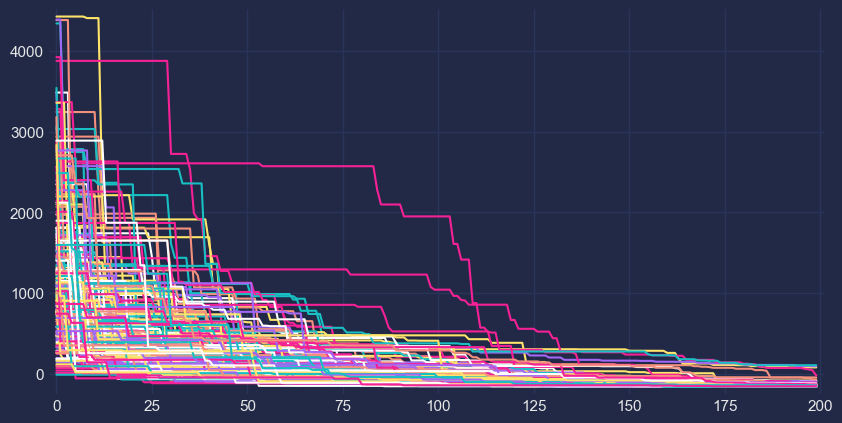

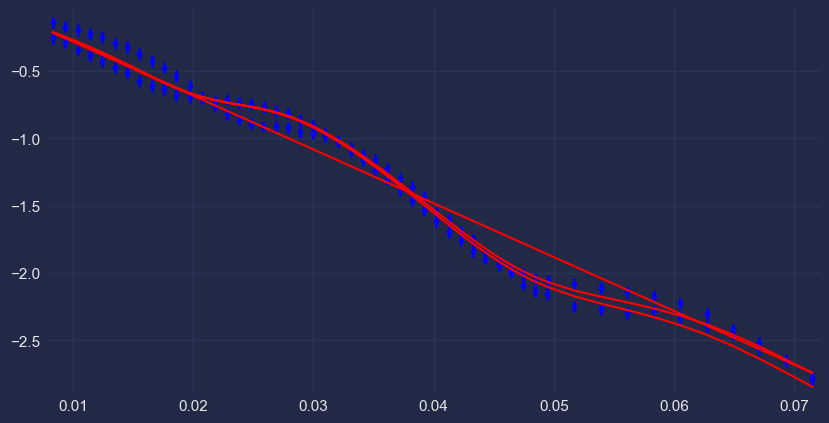

In [298]:
fitter_281 = CurveFitter(objs[1], nwalkers=nwalkers, moves = move)
fitter_281.initialise("prior")
chain_281 = fitter_281.sample(int(nwalkers), random_state=random_state)
lp_281 = fitter_281.logpost
plt.plot(-lp_281)

fitter_281.initialise("jitter")
chain_281 = fitter_281.sample(int(nwalkers), random_state=random_state)
lp_281 = fitter_281.logpost

print(objs[1].varying_parameters())
objs[1].plot()

In [299]:
to_json(structs[1], db.res / "ZnPc_281eV_struct.json")
to_json(objs[1], db.res / "ZnPc_281eV_obj.json")

model_281_s = PXR_ReflectModel(structs[1], pol = "s", energy = ens[1], name = "ZnPc Mono Layer 281eV")(q)
model_281_p = PXR_ReflectModel(structs[1], pol = "p", energy = ens[1], name = "ZnPc Mono Layer 281eV")(q)

np.savetxt(db.res / "ZnPc_281eV_s_fit.txt", np.row_stack([q, model_281_s]), delimiter = ",")
np.savetxt(db.res / "ZnPc_281eV_p_fit.txt", np.row_stack([q, model_281_p]), delimiter = ",")

c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:115: RuntimeWarning: invalid value encountered in arcsin
  theta_exp = np.pi/2 - np.arcsin(flatq[:]  / (2*k0))
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:196: RuntimeWarning: invalid value encountered in sqrt
  kz_ord = np.sqrt(e_o * k0**2 - k_par[:]**2)#, dtype=np.complex128)
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:240: RuntimeWarning: invalid value encountered in divide
  knorm = kvec / kdiv [:,:,None]#(np.linalg.norm(kvec,axis=-1)[:,:,None])
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:251: RuntimeWarning: invalid value encountered in divide
  dpol_temp[:,0,:] = np.subtract(opticaxis[None, :], ((1 + nu)/(1+nu*kpol[:, 0, None]**2))*kpol[:, 0, None] * knorm[:, 0, :])
c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:252: RuntimeWarning: invalid value encountered

### 282 eV

In [300]:
si_2[2].thick.setp(vary = False)
si_2[2].rough.setp(vary = False)

sio2_2[2].thick.setp(vary = None, constraint=sio2_thick)
sio2_2[2].rough.setp(vary = None, constraint=sio2_rough)
sio2_2[2].sld.density.setp(vary = None, constraint=sio2_density)

c_amor_2[2].thick.setp(vary = None, constraint=c_amor_thick)
c_amor_2[2].rough.setp(vary = None, constraint=c_amor_rough)
c_amor_2[2].sld.density.setp(vary = None, constraint=c_amor_density)

znpc_2[2].thick.setp(vary = None, constraint=znpc_thick)
znpc_2[2].rough.setp(vary = None, constraint=znpc_rough)

znpc_2[2].sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_2[2].sld.delta.setp(vary = True, bounds = (-.001,.002))

znpc_2[2].sld.xx.setp(vary = True, bounds = (znpc_2[2].sld.delta, .002))
znpc_2[2].sld.zz.setp(vary = True, bounds = (-.002, znpc_2[2].sld.delta))
znpc_2[2].sld.ixx.setp(vary = None, constraint = znpc_2[2].sld.beta)
znpc_2[2].sld.izz.setp(vary = None, constraint = znpc_2[2].sld.beta)

100%|██████████| 200/200 [00:14<00:00, 13.34it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.07716 +/- 0.0343, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=5.23478e-07 +/- 2.96e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=0.000435712 +/- 0.000837, bounds=[-0.001, 0.002]>
<Parameter:  'ZnPc_biso'  , value=0.00023552 +/- 1.69e-05, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=0.000243827 +/- 3.57e-05, bounds=[0.00022777608805737713, 0.002]>
<Parameter:   'ZnPc_zz'   , value=0.000223503 +/- 2.21e-05, bounds=[-0.002, 0.00022777608805737713]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

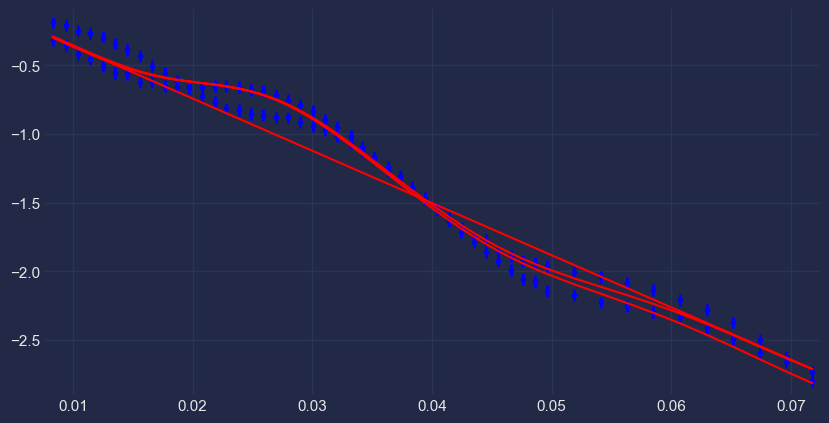

In [301]:
fitter_282 = CurveFitter(objs[2], nwalkers=nwalkers, moves = move)
fitter_282.initialise("prior")
chain_282 = fitter_282.sample(int(nwalkers), random_state=random_state)

fitter_282.initialise("jitter")
chain_282 = fitter_282.sample(int(nwalkers), random_state=random_state)
lp_282 = fitter_282.logpost

print(objs[2].varying_parameters())
objs[2].plot()

In [302]:
to_json(structs[2], db.res / "ZnPc_282eV_struct.json")
to_json(objs[2], db.res / "ZnPc_282eV_obj.json")

model_282_s = PXR_ReflectModel(structs[2], pol = "s", energy = ens[2], name = "ZnPc Mono Layer 282eV")(q)
model_282_p = PXR_ReflectModel(structs[2], pol = "p", energy = ens[2], name = "ZnPc Mono Layer 282eV")(q)

np.savetxt(db.res / "ZnPc_282eV_s_fit.txt", np.row_stack([q, model_282_s]), delimiter = ",")
np.savetxt(db.res / "ZnPc_282eV_p_fit.txt", np.row_stack([q, model_282_p]), delimiter = ",")

### 282.3

In [303]:
si_2[3].thick.setp(vary = False)
si_2[3].rough.setp(vary = False)

sio2_2[3].thick.setp(vary = None, constraint=sio2_thick)
sio2_2[3].rough.setp(vary = None, constraint=sio2_rough)
sio2_2[3].sld.density.setp(vary = None, constraint=sio2_density)

c_amor_2[3].thick.setp(vary = None, constraint=c_amor_thick)
c_amor_2[3].rough.setp(vary = None, constraint=c_amor_rough)
c_amor_2[3].sld.density.setp(vary = None, constraint=c_amor_density)

znpc_2[3].thick.setp(vary = None, constraint=znpc_thick)
znpc_2[3].rough.setp(vary = None, constraint=znpc_rough)

znpc_2[3].sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_2[3].sld.delta.setp(vary = True, bounds = (-.002,.002))

znpc_2[3].sld.xx.setp(vary = True, bounds = (znpc_2[3].sld.delta, .002))
znpc_2[3].sld.zz.setp(vary = True, bounds = (-.002, znpc_2[3].sld.delta))
znpc_2[3].sld.ixx.setp(vary = None, constraint = znpc_2[3].sld.beta)
znpc_2[3].sld.izz.setp(vary = None, constraint = znpc_2[3].sld.beta)

100%|██████████| 200/200 [00:16<00:00, 12.11it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.02619 +/- 0.0379, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=5.17947e-07 +/- 2.99e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=0.000136708 +/- 0.00103, bounds=[-0.002, 0.002]>
<Parameter:  'ZnPc_biso'  , value=0.000216001 +/- 1.91e-05, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=0.000132472 +/- 3.56e-05, bounds=[0.0001124709313397924, 0.002]>
<Parameter:   'ZnPc_zz'   , value=0.000101753 +/- 5.68e-05, bounds=[-0.002, 0.0001124709313397924]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

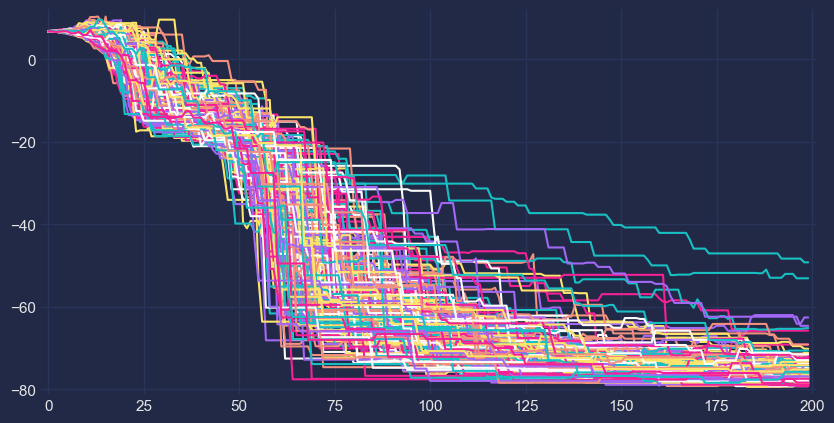

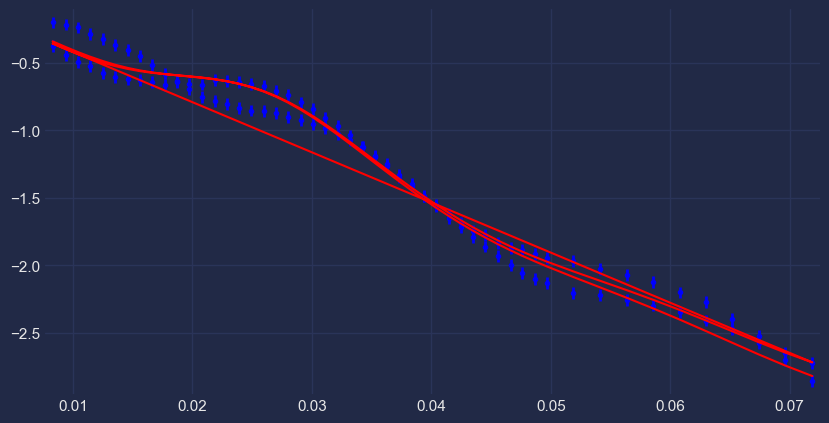

In [304]:
fitter_282p3 = CurveFitter(objs[3], nwalkers=nwalkers, moves = move)
fitter_282p3.initialise("prior")
chain_282p3 = fitter_282p3.sample(int(nwalkers), random_state=random_state)

fitter_282p3.initialise("jitter")
chain_282p3 = fitter_282p3.sample(int(nwalkers), random_state=random_state)
lp_282p3 = fitter_282p3.logpost
plt.plot(-lp_282p3)

print(objs[3].varying_parameters())
objs[3].plot()

In [305]:
to_json(structs[3], db.res / "ZnPc_282.3eV_struct.json")
to_json(objs[3], db.res / "ZnPc_282.3eV_obj.json")

model_282p3_s = PXR_ReflectModel(structs[3], pol = "s", energy = ens[3], name = "ZnPc Mono Layer 282.3eV")(q)
model_282p3_p = PXR_ReflectModel(structs[3], pol = "p", energy = ens[3], name = "ZnPc Mono Layer 282.3eV")(q)

np.savetxt(db.res / "ZnPc_282.3eV_s_fit.txt", np.row_stack([q, model_282p3_s]), delimiter = ",")
np.savetxt(db.res / "ZnPc_282.3eV_p_fit.txt", np.row_stack([q, model_282p3_p]), delimiter = ",")

### 282.7

In [306]:
si_2[4].thick.setp(vary = False)
si_2[4].rough.setp(vary = False)

sio2_2[4].thick.setp(vary = None, constraint=sio2_thick)
sio2_2[4].rough.setp(vary = None, constraint=sio2_rough)
sio2_2[4].sld.density.setp(vary = None, constraint=sio2_density)

c_amor_2[4].thick.setp(vary = None, constraint=c_amor_thick)
c_amor_2[4].rough.setp(vary = None, constraint=c_amor_rough)
c_amor_2[4].sld.density.setp(vary = None, constraint=c_amor_density)

znpc_2[4].thick.setp(vary = None, constraint=znpc_thick)
znpc_2[4].rough.setp(vary = None, constraint=znpc_rough)

znpc_2[4].sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_2[4].sld.delta.setp(vary = True, bounds = (-.003,.002))

znpc_2[4].sld.xx.setp(vary = True, bounds = (znpc_2[4].sld.delta, .002))
znpc_2[4].sld.zz.setp(vary = True, bounds = (-.003, znpc_2[4].sld.delta))
znpc_2[4].sld.ixx.setp(vary = None, constraint = znpc_2[4].sld.beta)
znpc_2[4].sld.izz.setp(vary = None, constraint = znpc_2[4].sld.beta)

In [307]:
fitter_282p7 = CurveFitter(objs[4], nwalkers=nwalkers, moves = move)
fitter_282p7.initialise("prior")
chain_282p7 = fitter_282p7.sample(int(nwalkers), random_state=random_state)

fitter_282p7.initialise("jitter")
chain_282p7 = fitter_282p7.sample(int(nwalkers), random_state=random_state)
lp_282p7 = fitter_282p7.logpost
plt.plot(-lp_282p7)

print(objs[4].varying_parameters())
objs[4].plot()

100%|██████████| 200/200 [00:14<00:00, 14.07it/s]


KeyboardInterrupt: 

In [ ]:
to_json(structs[4], db.res / "ZnPc_282.7eV_struct.json")
to_json(objs[4], db.res / "ZnPc_282.7eV_obj.json")

model_282p7_s = PXR_ReflectModel(structs[4], pol = "s", energy = ens[4], name = "ZnPc Mono Layer 282.7eV")(q)
model_282p7_p = PXR_ReflectModel(structs[4], pol = "p", energy = ens[4], name = "ZnPc Mono Layer 282.7eV")(q)

np.savetxt(db.res / "ZnPc_282.7eV_s_fit.txt", np.row_stack([q, model_282p7_s]), delimiter = ",")
np.savetxt(db.res / "ZnPc_282.7eV_p_fit.txt", np.row_stack([q, model_282p7_p]), delimiter = ",")

### 283.1

In [ ]:
si_2[5].thick.setp(vary = False)
si_2[5].rough.setp(vary = False)

sio2_2[5].thick.setp(vary = None, constraint=sio2_thick)
sio2_2[5].rough.setp(vary = None, constraint=sio2_rough)
sio2_2[5].sld.density.setp(vary = None, constraint=sio2_density)

c_amor_2[5].thick.setp(vary = None, constraint=c_amor_thick)
c_amor_2[5].rough.setp(vary = None, constraint=c_amor_rough)
c_amor_2[5].sld.density.setp(vary = None, constraint=c_amor_density)

znpc_2[5].thick.setp(vary = None, constraint=znpc_thick)
znpc_2[5].rough.setp(vary = None, constraint=znpc_rough)

znpc_2[5].sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_2[5].sld.delta.setp(vary = True, bounds = (-.003,.002))

znpc_2[5].sld.xx.setp(vary = True, bounds = (znpc_2[5].sld.delta, .002))
znpc_2[5].sld.zz.setp(vary = True, bounds = (-.003, znpc_2[5].sld.delta))
znpc_2[5].sld.ixx.setp(vary = True, bounds = (-.003, .002))
znpc_2[5].sld.izz.setp(vary = True, bounds = (-.003, .002))

100%|██████████| 200/200 [00:15<00:00, 12.60it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.16524 +/- 0.122, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.75956e-07 +/- 2.91e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=-0.000430629 +/- 0.00123, bounds=[-0.003, 0.002]>
<Parameter:  'ZnPc_biso'  , value=0.000239965 +/- 0.000141, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=-0.000406245 +/- 0.000233, bounds=[-0.003, 0.002]>
<Parameter:  'ZnPc_ixx'   , value=0.000309083 +/- 4.07e-05, bounds=[-0.003, 0.002]>
<Parameter:   'ZnPc_zz'   , value=0.000389781 +/- 0.000412, bounds=[-0.003, 0.002]>
<Parameter:  'ZnPc_izz'   , value=0.00030336 +/- 5.41e-05, bounds=[-0.003, 0.002]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

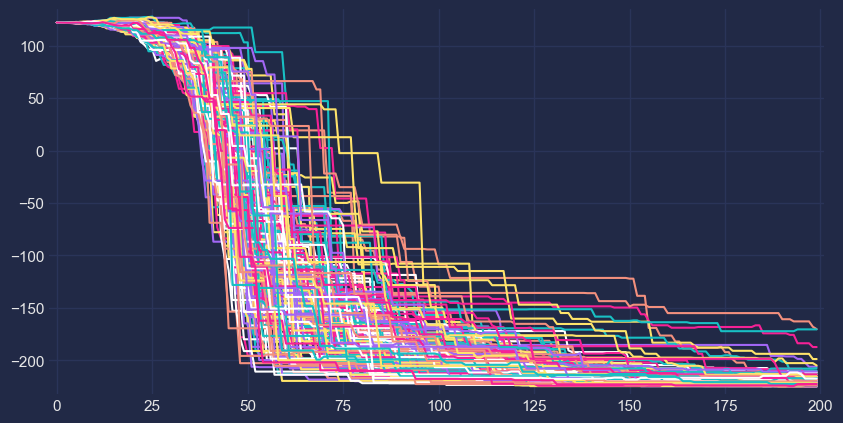

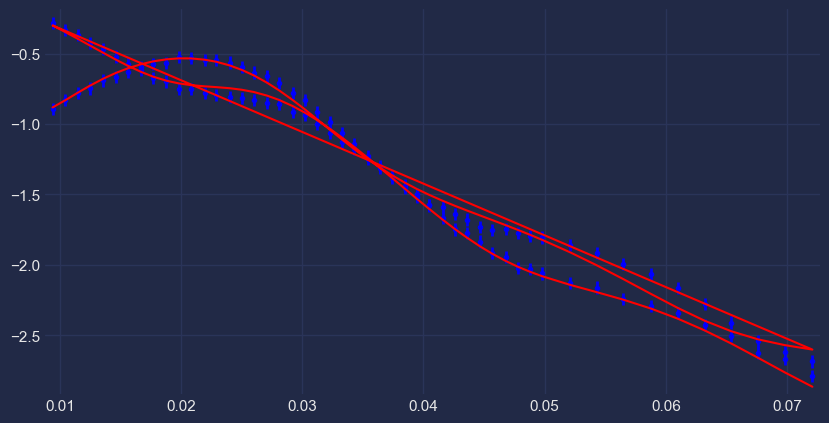

In [ ]:
fitter_283p1 = CurveFitter(objs[5], nwalkers=nwalkers, moves = move)
fitter_283p1.initialise("prior")
chain_283p1 = fitter_283p1.sample(int(nwalkers), random_state=random_state)

fitter_283p1.initialise("jitter")
chain_283p1 = fitter_283p1.sample(int(nwalkers), random_state=random_state)

lp_283p1 = fitter_283p1.logpost
plt.plot(-lp_283p1)

print(objs[5].varying_parameters())
objs[5].plot()

xx        zz       dxx       dzz     delta    ddelta       ixx  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.001244  0.001442  0.000072  0.000226  0.001222  0.000602  0.000325   
2  0.000749  0.000987  0.000027  0.000029  0.000995  0.000665  0.000285   
3  0.000464  0.000850  0.000026  0.000028  0.000446  0.000874  0.000313   
4  0.000230  0.000674  0.000026  0.000028  0.000445  0.000894  0.000300   
5  0.000126  0.000651  0.000025  0.000028 -0.000053  0.000993  0.000308   
6 -0.000061  0.000554  0.000031  0.000028 -0.000447  0.001352  0.000315   
7 -0.000406  0.000390  0.000233  0.000412 -0.000431  0.001225  0.000309   
8  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        izz      dixx      dizz      beta     dbeta energy  
0  0.000000  0.000000  0.000000  0.000000  0.000000    250  
1  0.000325  0.000051  0.000051  0.000325  0.000051    275  
2  0.000285  0.000011  0.000011  0.000285  0.000011    280  
3  0.000313  0.000012  0.000012  0.000313  0.000012    281  
4  0.000300  0.000009  0.000009  0.000300  0.000009    282  
5  0.000308  0.000009  0.000009  0.000308  0.000009  282.3  
6  0.000315  0.000009  0.000009  0.000315  0.000009  282.7  
7  0.000303  0.000041  0.000054  0.000240  0.000141  283.1  
8  0.000000  0.000000  0.000000  0.000000  0.000000  283.7  
9  0.000000  0.000000  0.000000  0.000000  0.000000  284.1

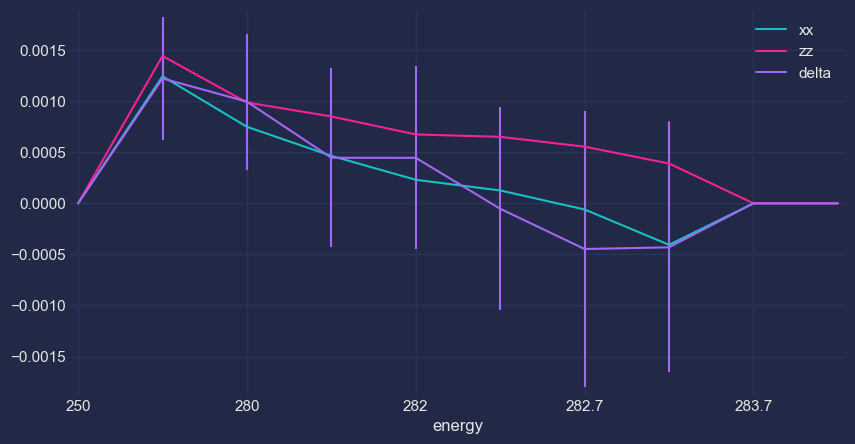

In [ ]:
for i,  e in enumerate(ens):
    oc_res.loc[oc_res["energy"] == str(e), "xx"] = znpc_2[i].sld.xx.value
    oc_res.loc[oc_res["energy"] == str(e), "zz"] = znpc_2[i].sld.zz.value
    oc_res.loc[oc_res["energy"] == str(e), "dxx"] = znpc_2[i].sld.xx.stderr
    oc_res.loc[oc_res["energy"] == str(e), "dzz"] = znpc_2[i].sld.zz.stderr
    oc_res.loc[oc_res["energy"] == str(e), "delta"] = znpc_2[i].sld.delta.value
    oc_res.loc[oc_res["energy"] == str(e), "ddelta"] = znpc_2[i].sld.delta.stderr
    oc_res.loc[oc_res["energy"] == str(e), "ixx"] = znpc_2[i].sld.ixx.value
    oc_res.loc[oc_res["energy"] == str(e), "izz"] = znpc_2[i].sld.izz.value
    oc_res.loc[oc_res["energy"] == str(e), "dixx"] = znpc_2[i].sld.ixx.stderr
    oc_res.loc[oc_res["energy"] == str(e), "dizz"] = znpc_2[i].sld.izz.stderr
    oc_res.loc[oc_res["energy"] == str(e), "beta"] = znpc_2[i].sld.beta.value
    oc_res.loc[oc_res["energy"] == str(e), "dbeta"] = znpc_2[i].sld.beta.stderr

fig, ax = plt.subplots()
display(oc_res)
oc_res.plot(x = "energy", y = "xx", yerr = "dxx", ax = ax)
oc_res.plot(x = "energy", y = "zz", yerr = "dzz", ax = ax)
oc_res.plot(x = "energy", y = "delta", yerr = "ddelta", ax = ax)


In [172]:
to_json(structs[5], db.res / "ZnPc_283.1eV_struct.json")
to_json(objs[5], db.res / "ZnPc_283.1eV_obj.json")

model_283p1_s = PXR_ReflectModel(structs[5], pol = "s", energy = ens[5], name = "ZnPc Mono Layer 283.1eV")(q)
model_283p1_p = PXR_ReflectModel(structs[5], pol = "p", energy = ens[5], name = "ZnPc Mono Layer 283.1eV")(q)

np.savetxt(db.res / "ZnPc_283.1eV_s_fit.txt", np.row_stack([q, model_283p1_s]), delimiter = ",")
np.savetxt(db.res / "ZnPc_283.1eV_p_fit.txt", np.row_stack([q, model_283p1_p]), delimiter = ",")

oc_res.to_csv(db.res / "ZnPc_OC.csv", index = False)

# Junk

100%|██████████| 200/200 [06:06<00:00,  1.83s/it]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.997307 +/- 0.0146, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=5.03536e-07 +/- 3.4e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=0.000383594 +/- 2.61e-06, bounds=[3.348413000880585e-05, 0.0015251101838025388]>
<Parameter:  'ZnPc_biso'  , value=0.000229087 +/- 1.64e-06, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=6.70029e-05 +/- 6.45e-07, bounds=[3.348413000880585e-05, 0.0015251101838025388]>
<Parameter:   'ZnPc_zz'   , value=0.00101628 +/- 1.03e-05, bounds=[3.348413000880585e-05, 0.0015251101838025388]>
________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.00009 +/- 0.00577, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.77921e-07 +/- 3.39e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=9.39046e-

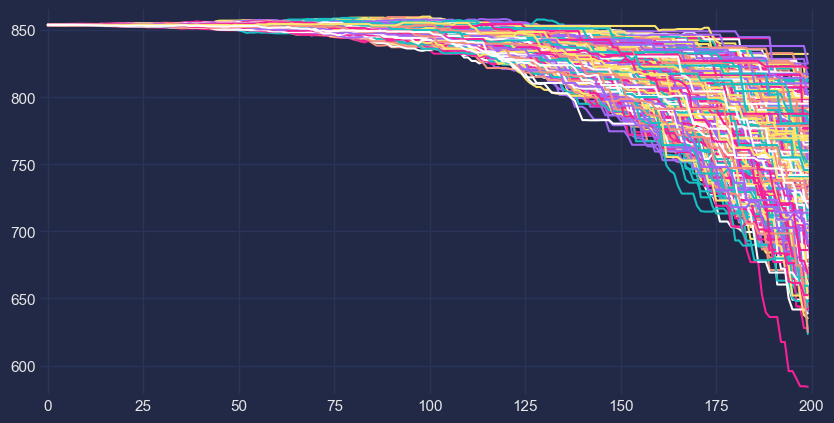

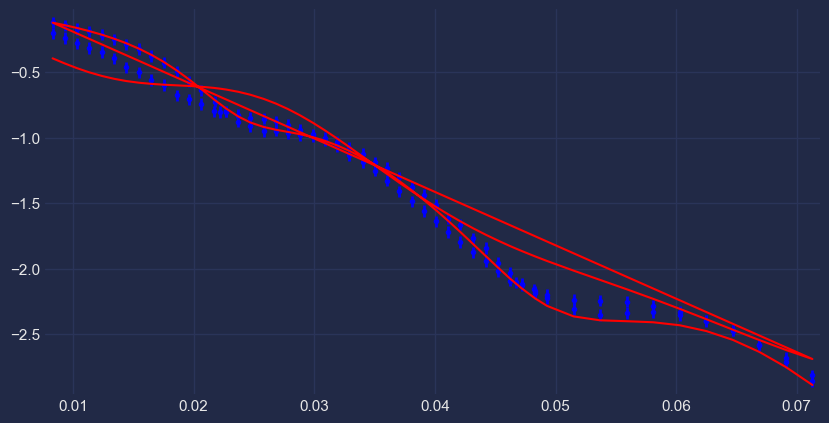

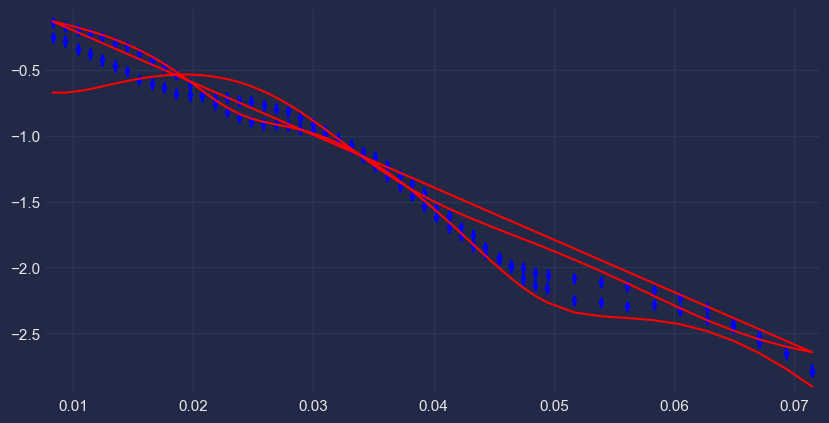

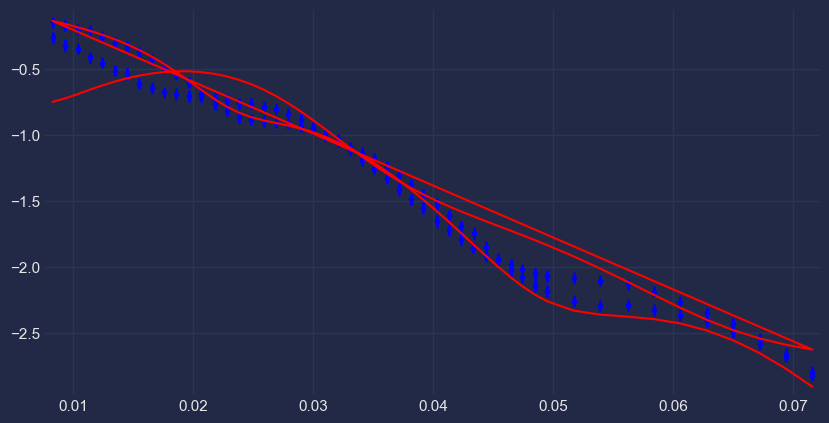

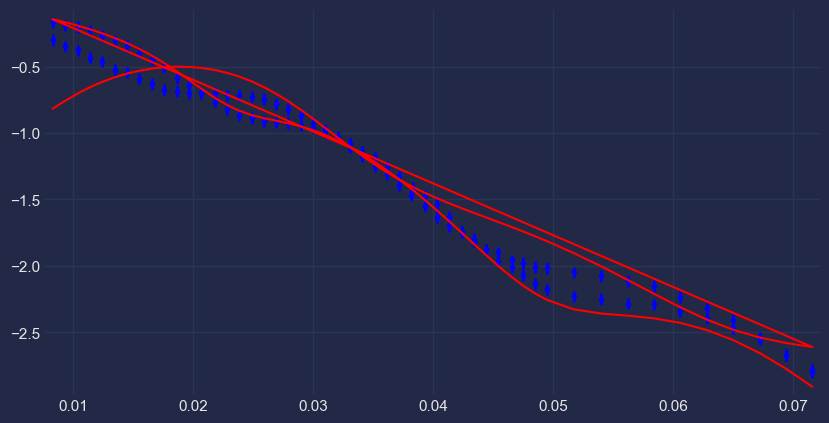

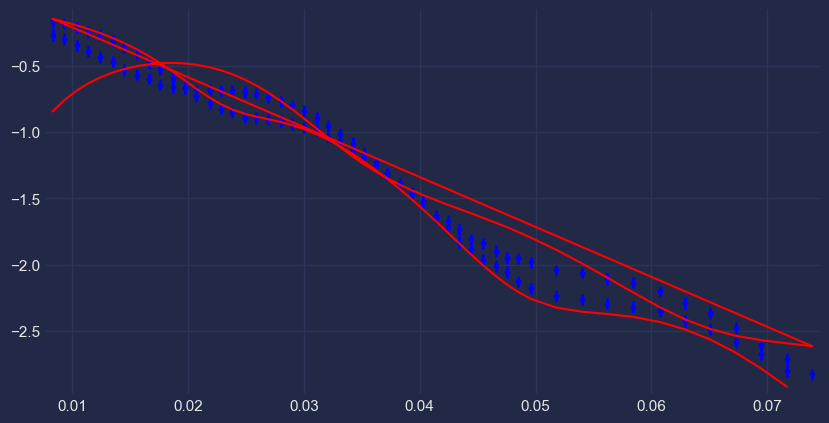

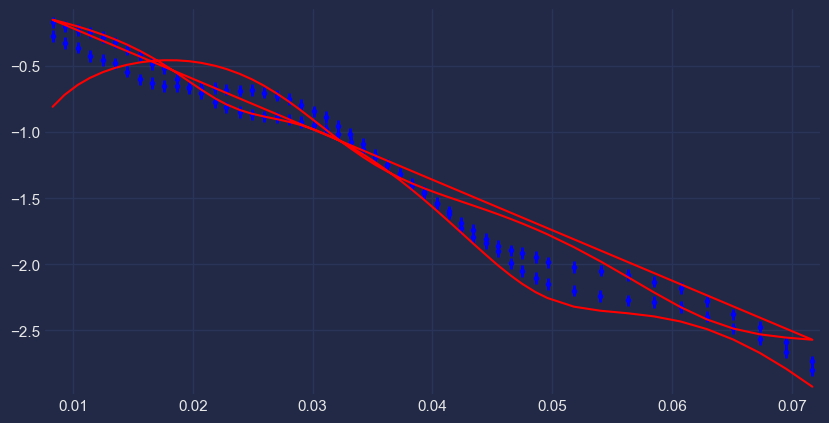

In [59]:
fitter_global = CurveFitter(global_obj, nwalkers=nwalkers * len(ens), moves = move)
fitter_global.initialise("jitter")
chain = fitter_global.sample(int(nwalkers), random_state=random_state)
lp = fitter_global.logpost
plt.plot(-lp)

for obj in objs:
    print(obj.varying_parameters())
    obj.plot()

## <a id='toc1_2_'></a>[Fit 283.7 eV Data](#toc0_)

### <a id='toc1_2_1_'></a>[Load the 283.7 eV data](#toc0_)

[Text(0.5, 1.0, '$200 \\AA$ ZnPc Mono Layer Reflectivity Data'),
 Text(0, 0.5, '$I_R / I_0$ [a.u.]'),
 None]

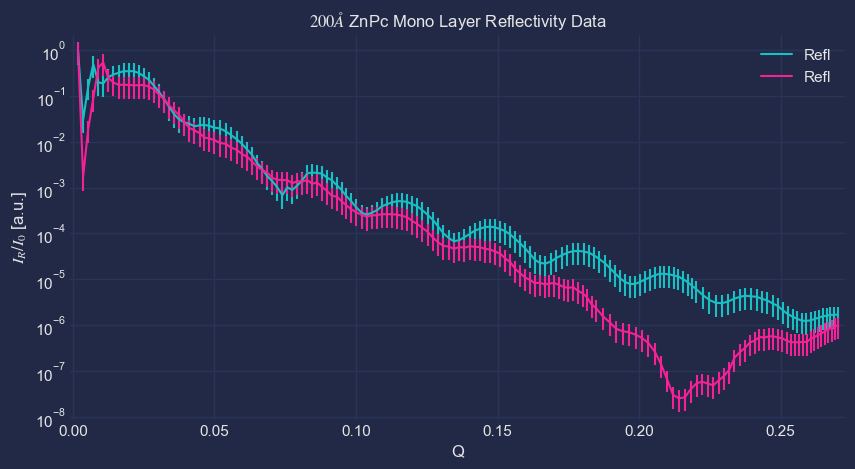

In [47]:
fig, ax = plt.subplots()

znpc_mono_283p7_s = znpc_mono["283.7"]["s"]
znpc_mono_283p7_p = znpc_mono["283.7"]["p"]

# Modify the error to 20 percent
scale = .5
znpc_mono_283p7_s["Err"] = znpc_mono_283p7_s["Refl"]*scale
znpc_mono_283p7_p["Err"] = znpc_mono_283p7_p["Refl"]*scale

znpc_mono_283p7_s.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_p.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err")
ax.set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

#### <a id='toc1_2_1_1_'></a>[Various Masking Attempts](#toc0_)

[Text(0.5, 0, 'Q [$\\AA^{-1}$]'), Text(0, 0.5, '$I_R / I_0$ [a.u.]'), None]

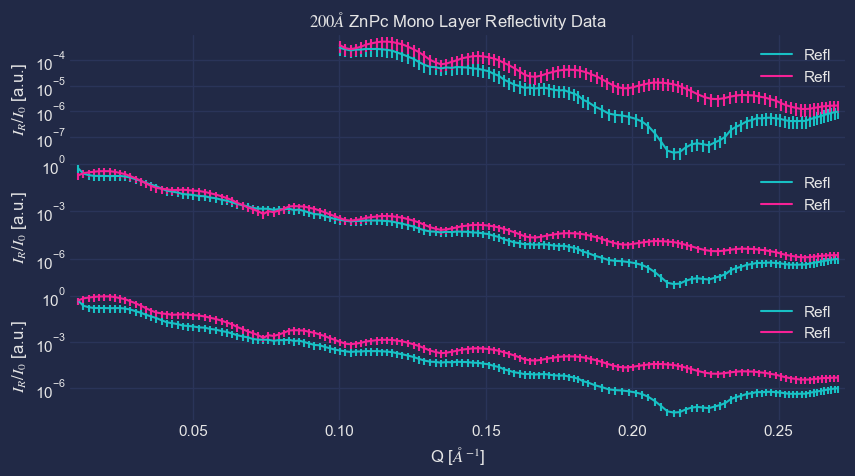

In [53]:
fig, ax = plt.subplots(nrows = 3, sharex=True, gridspec_kw={"hspace":0})
# (Extream Remove Low Q) Masking <.1

znpc_mono_283p7_s_extreme = znpc_mono_283p7_s[znpc_mono_283p7_s["Q"] > .1]
znpc_mono_283p7_p_extreme = znpc_mono_283p7_p[znpc_mono_283p7_p["Q"] > .1]

znpc_mono_283p7_p_extreme.plot(ax = ax[0], x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_s_extreme.plot(ax = ax[0], x = "Q", y = "Refl", yerr = "Err")
ax[0].set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

znpc_mono_283p7_extreme = rf.to_refnx_dataset(znpc_mono_283p7_s_extreme, pol = "sp", second_pol=znpc_mono_283p7_p_extreme)

# (Remove Low Q) Masking first 5 points
znpc_mono_283p7_s_lowq = znpc_mono_283p7_s.iloc[5:]
znpc_mono_283p7_p_lowq = znpc_mono_283p7_p.iloc[5:]

znpc_mono_283p7_p_lowq.plot(ax = ax[1], x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_s_lowq.plot(ax = ax[1], x = "Q", y = "Refl", yerr = "Err")
ax[1].set(
    xlabel = r"Q [$\AA^{-1}$]",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

znpc_mono_283p7_lowq = rf.to_refnx_dataset(znpc_mono_283p7_s_lowq, pol = "sp", second_pol=znpc_mono_283p7_p_lowq)

# (Remove Low Q + Scale)

znpc_mono_283p7_s_lowq_scale = znpc_mono_283p7_s_lowq.copy()
znpc_mono_283p7_p_lowq_scale = znpc_mono_283p7_p_lowq.copy()
scale = znpc_mono_283p7_p_lowq_scale["Refl"].iloc[0] / znpc_mono_283p7_s_lowq_scale["Refl"].iloc[0]
znpc_mono_283p7_s_lowq_scale["Refl"] *= scale
znpc_mono_283p7_s_lowq_scale["Err"] *= scale

znpc_mono_283p7_lowq_scale = rf.to_refnx_dataset(znpc_mono_283p7_s_lowq_scale, pol = "sp", second_pol=znpc_mono_283p7_p_lowq_scale)

znpc_mono_283p7_p_lowq_scale.plot(ax = ax[2], x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_s_lowq_scale.plot(ax = ax[2], x = "Q", y = "Refl", yerr = "Err")
ax[2].set(
    xlabel = r"Q [$\AA^{-1}$]",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)


### <a id='toc1_2_2_'></a>[Construct the slab structure for the data](#toc0_)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

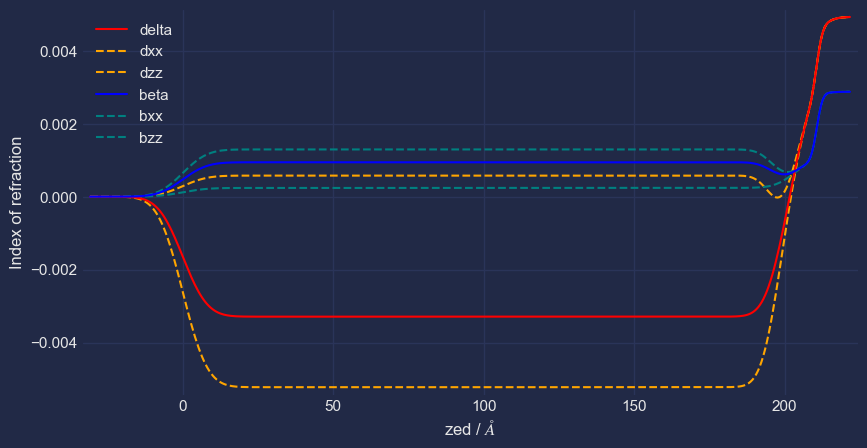

In [58]:
e = 283.7
vac = PXR_MaterialSLD("", 0, e)(0, 0)
si_1 = PXR_MaterialSLD("Si", si.sld.density, e, name="Si")(si_thick,si_rough)
sio2_1 = PXR_MaterialSLD("SiO2", sio2.sld.density, e, name="SiO2")(sio2_thick,sio2_rough)
c_amor_1 = PXR_MaterialSLD("C", c_amor.sld.density, e, name="C_Amorphous")(c_amor_thick, c_amor_rough)

n = np.array([znpc_oc["zz"].n(e), znpc_oc["xx"].n(e)])

biref = znpc_oc["zz"].delta(e) - znpc_oc["xx"].delta(e)
dicrho = znpc_oc["zz"].beta(e) - znpc_oc["xx"].beta(e)

znpc_1 = PXR_SLD(n, symmetry="uni", name = "ZnPc")(znpc_thick, znpc_rough)

struct_283p7 = vac | znpc_1 | c_amor_1 | sio2_1 | si_1
struct_283p7.plot()

### <a id='toc1_2_3_'></a>[Construct the Objective Function](#toc0_)

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

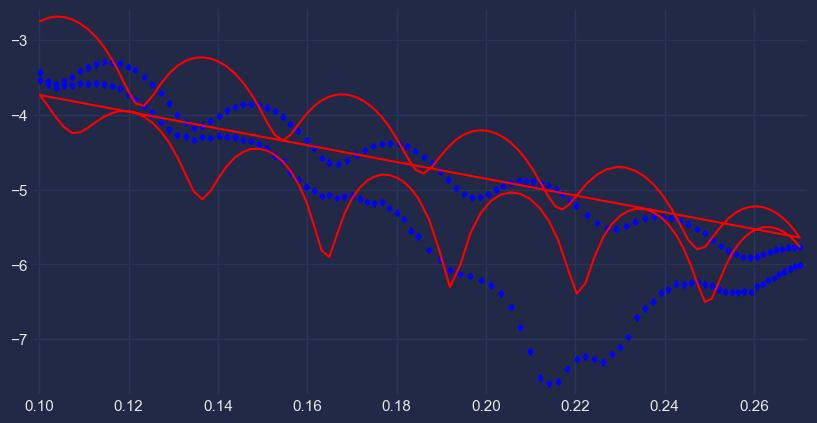

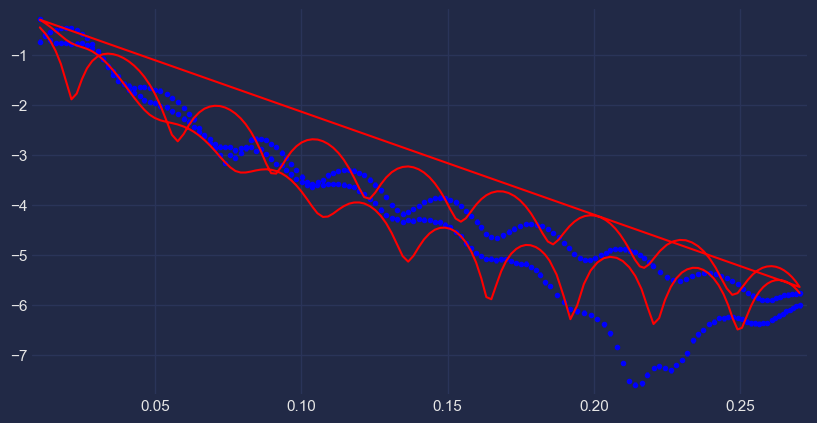

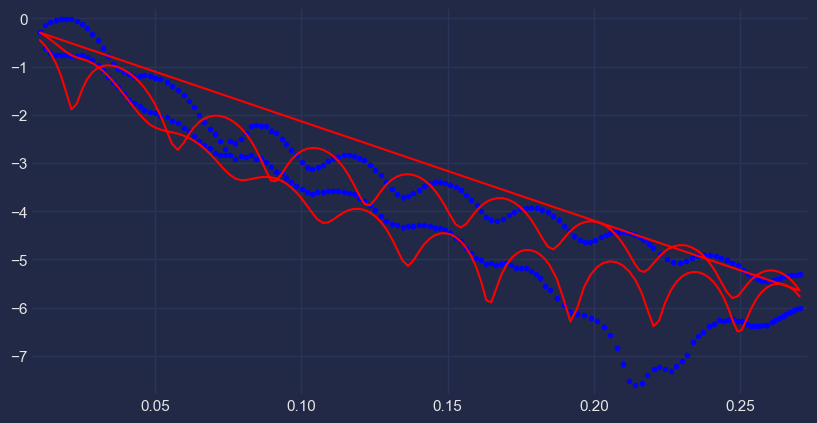

In [59]:
model_283p7 = PXR_ReflectModel(struct_283p7, pol = "sp", energy = e, name = "ZnPc Mono Layer 283p7eV")
model_283p7.scale.setp(vary = True, bounds = (0.6, 1.2))
model_283p7.bkg.setp(vary = True, bounds = (1e-9, 1e-6))

# Low q masking
from pyref.fitting.logp import LogpExtra_rough
obj_283p7_lowq = Objective(model_283p7, znpc_mono_283p7_extreme, transform=Transform("logY"))
logp = LogpExtra_rough(obj_283p7_lowq)
obj_283p7_lowq.logp_extra = logp

obj_283p7_lowq.plot()

# extream q masking
obj_283p7_extreme = Objective(model_283p7, znpc_mono_283p7_lowq, transform=Transform("logY"))
logp = LogpExtra_rough(obj_283p7_extreme)
obj_283p7_extreme.logp_extra = logp

obj_283p7_extreme.plot()

# Low q masking + scale
obj_283p7_lowq_scale = Objective(model_283p7, znpc_mono_283p7_lowq_scale, transform=Transform("logY"))
logp = LogpExtra_rough(obj_283p7_lowq_scale)
obj_283p7_lowq_scale.logp_extra = logp

obj_283p7_lowq_scale.plot()

### <a id='toc1_2_4_'></a>[Fitting the data](#toc0_)

In [60]:
# si slabs
si_1.thick.setp(vary = False)
si_1.rough.setp(vary = False)

# sio2 slabs
sio2_1.thick.setp(vary = None, constraint = sio2_thick) # These are well constrained allready by the Bare si fitting
sio2_1.rough.setp(vary = None, constraint = sio2_rough)
sio2_1.sld.density.setp(vary = None, constraint = sio2_density)

# c_amor slabs
c_amor_1.thick.setp(vary = None, constraint = c_amor_thick) # These are well constrained allready by the Bare si fitting
c_amor_1.rough.setp(vary = None, constraint = c_amor_rough)
c_amor_1.sld.density.setp(vary = None, constraint = c_amor_density)

# znpc slabs
znpc_1.thick.setp(vary = None, constraint = znpc_thick)
znpc_1.rough.setp(vary = None, constraint = znpc_rough)

znpc_1.sld.delta.setp(vary = True, bounds = (-0.01, 0))
znpc_1.sld.beta.setp(vary = True, bounds = (0, .01))

znpc_1.sld.dichroism.setp(vary = None, constraint = dicrho)
znpc_1.sld.birefringence.setp(vary = None, constraint = biref)


znpc_1.sld.xx.setp(vary=None,  constraint=(znpc_1.sld.delta + (1/3)*znpc_1.sld.birefringence))
znpc_1.sld.zz.setp(vary=None,  constraint=(znpc_1.sld.delta - (2/3)*znpc_1.sld.birefringence))
znpc_1.sld.ixx.setp(vary=None, constraint=(znpc_1.sld.beta  + (1/3)*znpc_1.sld.dichroism))
znpc_1.sld.izz.setp(vary=None, constraint=(znpc_1.sld.beta  - (2/3)*znpc_1.sld.dichroism))

100%|██████████| 200/200 [00:17<00:00, 11.22it/s]


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

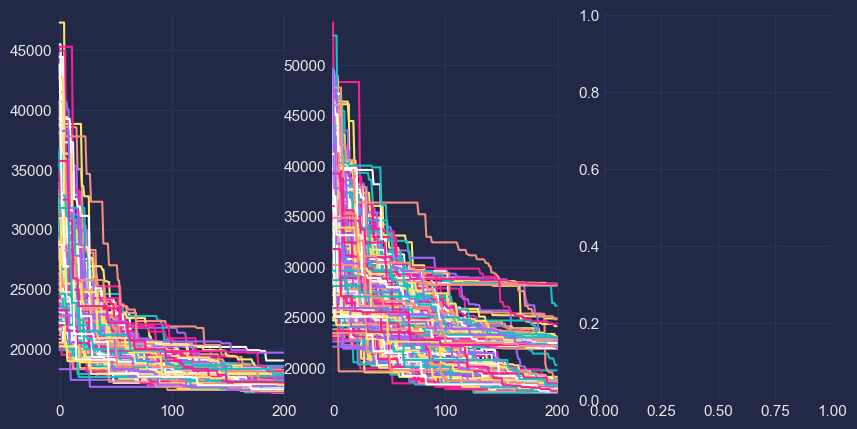

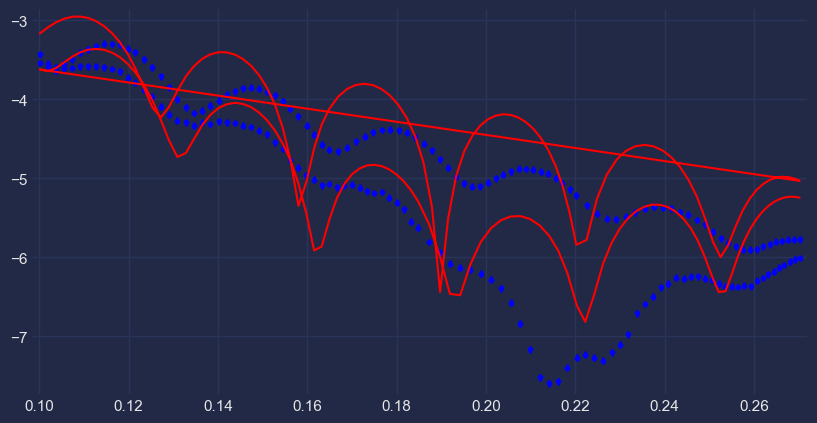

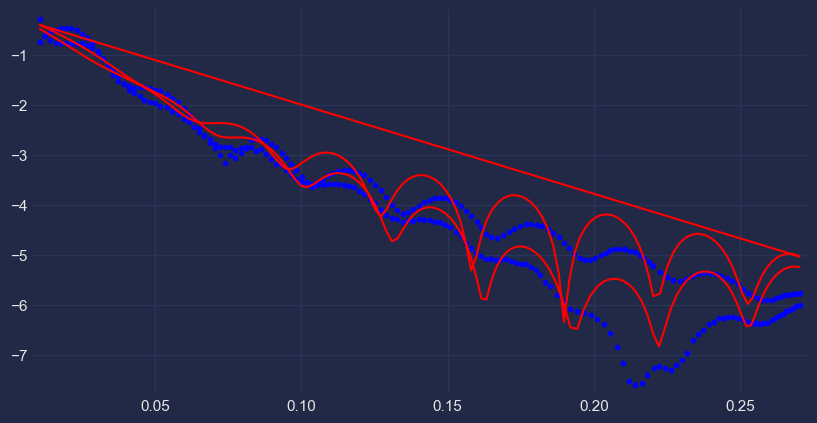

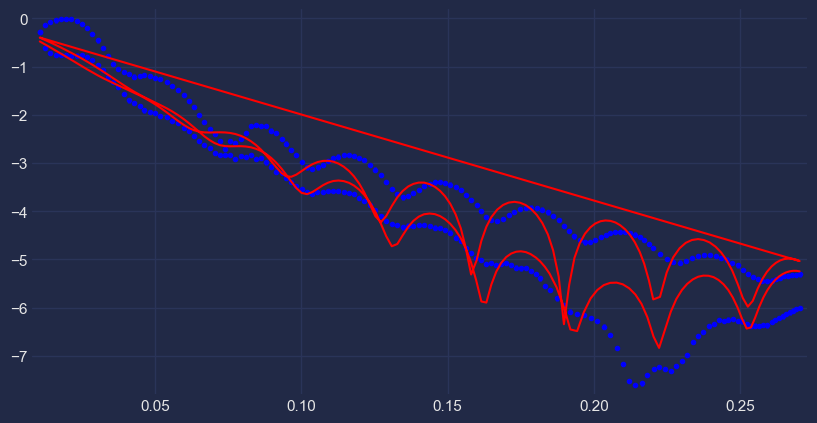

In [61]:
nwalkers = 200

fitter_1_lowq = CurveFitter(obj_283p7_lowq, nwalkers=nwalkers, moves = move)
fitter_1_extreme = CurveFitter(obj_283p7_extreme, nwalkers=nwalkers, moves = move)
fitter_1_lowq_scale = CurveFitter(obj_283p7_lowq_scale, nwalkers=nwalkers, moves = move)

fitter_1_lowq.initialise("prior")
fitter_1_extreme.initialise("prior")
fitter_1_lowq_scale.initialise("prior")

chain_1_lowq = fitter_1_lowq.sample(int(nwalkers), random_state=random_state)
chain_1_extreme = fitter_1_extreme.sample(int(nwalkers), random_state=random_state)
chain_1_lowq_scale = fitter_1_lowq_scale.sample(int(nwalkers), random_state=random_state)

lp_1_lowq = fitter_1_lowq.logpost
lp_1_extreme = fitter_1_extreme.logpost
lp_1_lowq_scale = fitter_1_lowq_scale.logpost

fig, ax = plt.subplots(ncols = 3)
ax[0].plot(-lp_1_lowq)
ax[1].plot(-lp_1_extreme)
ax[1].plot(-lp_1_lowq_scale)

obj_283p7_lowq.plot()
obj_283p7_extreme.plot()
obj_283p7_lowq_scale.plot()